# Take-home Assignment

# Imports

In [1]:
# To plot figures
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sklearn
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras
assert tf.__version__ >= "2.0"

import os
import datetime
import pandas as pd
import numpy as np

# Load the TensorBoard notebook extension
%load_ext tensorboard

# To make this notebook's output stable across runs
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

plt.rcParams['figure.figsize'] = (15.0, 10.0)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.subplot.bottom'] = 0.125
plt.rcParams['figure.edgecolor'] = 'white'

plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["savefig.pad_inches"] = 0.1

plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

Here we define the uris for the datasets and the models

In [3]:
nasdaq_url = 'stock_markets_datasets/Processed_NASDAQ.csv'
dji_url = 'stock_markets_datasets/Processed_DJI.csv'
nyse_url = 'stock_markets_datasets/Processed_NYSE.csv'
russel_url = 'stock_markets_datasets/Processed_RUSSELL.csv'
s_p_url = 'stock_markets_datasets/Processed_S%26P.csv'

cnn_pred_uri = 'nn_models/2D-CNNPred'
lstm_uri = 'nn_models/LSTM'
mlp_uri = 'nn_models/MLP'
cnn_lstm_uri = 'nn_models/CNN_LSTM'

# Dataset exploration

In this section we will upload and explore the dataset "**Processed_NASDAQ**",  containing several daily features of NASDAQ Composite from 2010 to 2017. The dataset was acquired from [this repository](https://archive.ics.uci.edu/ml/datasets/CNNpred%3A+CNN-based+stock+market+prediction+using+a+diverse+set+of+variables#).

It covers features from various categories of technical indicators, future contracts, price of commodities, important indices of markets around the world, price of major companies in the U.S. market, and treasury bill rates. Sources and thorough description of features have been mentioned in the paper "[CNNpred: CNN-based stock market prediction using a diverse set of variables](https://arxiv.org/pdf/1810.08923.pdf)".

## 1 - Loading the dataset

In [4]:
nasdaq_df = pd.read_csv(nasdaq_url, parse_dates=["Date"], index_col="Date")
# Dataset is now stored in a Pandas Dataframe

We load the .csv file telling pandas to parse the date column and to use it to index the data.

## 2 - Exploring the dataset

Now that we have loaded the dataset we can start inspecting the data.

In [5]:
nasdaq_df.head(10)

Close    Volume       mom      mom1      mom2      mom3  \
Date                                                                        
2009-12-31  2269.149902       NaN       NaN       NaN       NaN       NaN   
2010-01-04  2308.419922  0.560308  0.017306       NaN       NaN       NaN   
2010-01-05  2308.709961  0.225994  0.000126  0.017306       NaN       NaN   
2010-01-06  2301.090088 -0.048364 -0.003300  0.000126  0.017306       NaN   
2010-01-07  2300.050049  0.007416 -0.000452 -0.003300  0.000126  0.017306   
2010-01-08  2317.169922 -0.054915  0.007443 -0.000452 -0.003300  0.000126   
2010-01-11  2312.409912 -0.031463 -0.002054  0.007443 -0.000452 -0.003300   
2010-01-12  2282.310059  0.139772 -0.013017 -0.002054  0.007443 -0.000452   
2010-01-13  2307.899902 -0.021099  0.011212 -0.013017 -0.002054  0.007443   
2010-01-14  2316.739990 -0.027683  0.003830  0.011212 -0.013017 -0.002054   

               ROC_5  ROC_10  ROC_15  ROC_20  ...   NZD  silver-F  RUSSELL-F  \
Date                                          ...                              
2009-12-31       NaN     NaN     NaN     NaN  ...  0.03      0.26      -1.08   
2010-01-04       NaN     NaN     NaN     NaN  ...  1.52      3.26       1.61   
2010-01-05       NaN     NaN     NaN     NaN  ... -0.07      1.96      -0.20   
2010-01-06       NaN     NaN     NaN     NaN  ...  0.56      2.15      -0.02   
2010-01-07       NaN     NaN     NaN     NaN  ... -0.72      0.94       0.50   
2010-01-08  2.116212     NaN     NaN     NaN  ...  0.61      0.68       0.64   
2010-01-11  0.172845     NaN     NaN     NaN  ...  0.64     -0.13      -1.01   
2010-01-12 -1.143491     NaN     NaN     NaN  ... -0.47     -2.36      -0.67   
2010-01-13  0.295939     NaN     NaN     NaN  ...  0.26      1.62       0.82   
2010-01-14  0.725634     NaN     NaN     NaN  ...  0.27      0.57       0.76   

            S&P-F   CHF  Dollar index-F  Dollar index  wheat-F   XAG   XAU  
Date                                                                        
2009-12-31  -1.00 -0.11           -0.08         -0.06    -0.48  0.30  0.39  
2010-01-04   1.62 -0.57           -0.59         -0.42     3.12  3.91  2.10  
2010-01-05   0.31  0.43            0.03          0.12    -0.90  1.42 -0.12  
2010-01-06   0.07 -0.56           -0.24         -0.17     2.62  2.25  1.77  
2010-01-07   0.40  0.58            0.58          0.54    -1.85  0.22 -0.58  
2010-01-08   0.35 -0.98           -0.58         -0.56     2.07  1.26  0.38  
2010-01-11   0.09 -0.66           -0.64         -0.61     1.08  0.65  1.44  
2010-01-12  -0.74  0.22           -0.05         -0.06    -6.33 -1.78 -2.19  
2010-01-13   0.66 -0.15           -0.17         -0.13    -0.51  1.97  0.98  
2010-01-14   0.33  0.12           -0.13         -0.16    -1.49  0.32  0.39  

[10 rows x 83 columns]

Taking a peak at the first ten elements we can already see that there are a lot of missing values. They will be treated accordingly in [this section](#missing_values).


We can also see that the dates inculuded in the dataset are referring only to working days as the stock market is open only on those days.

We can get a confirmation of this by looking at the following rows where we see that 16,17 January 2010 are not present because it was a weekend and 18 January 2010 is not present because of the federal U.S. festivity of "Martin Luther King Jr. Day".

This is not a problem for our machine learning pipeline as we will map the 'Date' feature into a categorical feature representing the day of the week.
More information on this will be provided in [this section](#cathegorical_values).

In [6]:
nasdaq_df.iloc[9:13]

Close    Volume       mom      mom1      mom2      mom3  \
Date                                                                        
2010-01-14  2316.739990 -0.027683  0.003830  0.011212 -0.013017 -0.002054   
2010-01-15  2287.989990  0.170174 -0.012410  0.003830  0.011212 -0.013017   
2010-01-19  2320.399902 -0.224614  0.014165 -0.012410  0.003830  0.011212   
2010-01-20  2291.250000  0.149905 -0.012562  0.014165 -0.012410  0.003830   

               ROC_5    ROC_10  ROC_15  ROC_20  ...   NZD  silver-F  \
Date                                            ...                   
2010-01-14  0.725634       NaN     NaN     NaN  ...  0.27      0.57   
2010-01-15 -1.259292  0.830271     NaN     NaN  ... -0.55     -1.24   
2010-01-19  0.345527  0.518969     NaN     NaN  ... -0.95      0.49   
2010-01-20  0.391706 -0.756265     NaN     NaN  ... -1.64     -4.89   

            RUSSELL-F  S&P-F   CHF  Dollar index-F  Dollar index  wheat-F  \
Date                                                                        
2010-01-14       0.76   0.33  0.12           -0.13         -0.16    -1.49   
2010-01-15      -1.42  -1.14  0.64            0.77          0.77    -3.27   
2010-01-19       1.54   1.19  0.89            0.58          0.57    -2.08   
2010-01-20      -1.30  -1.03  1.05            1.09          1.08    -2.08   

             XAG   XAU  
Date                    
2010-01-14  0.32  0.39  
2010-01-15 -1.45 -1.08  
2010-01-19  0.70  0.45  
2010-01-20 -4.69 -2.32  

[4 rows x 83 columns]

### Features

The datasets described in [the paper](https://arxiv.org/pdf/1810.08923.pdf) contain 1984 entries, each representing a day of trading in a stock market. Each entry has 82 features which are grouped in the following way:

*   Primitive features
*   Technical indicators
*   Economic data
*   World stock markets
*   The exchange rate of U.S. dollar
*   Commodities
*   Big U.S. Companies
*   Futures contracts

The authors have made available five datasets, each representing a different stock market. The available markets are: S&P 500, NASDAQ Composite, Dow Jones Industrial Average, RUSSELL 2000, and NYSE Composite. In this work we will explore and analyse the NASDAQ Composite dataset, but all the insights we are going to gain will be valid for all datasets.

The primitive featrues and the technical indicators are unique for each dataset, while all the other features are common among datasets.

A tabular description of the features is also reported in the following images.

<img src="feature_description/feature_table_1.png" width="2000">
<img src="feature_description/feature_table_2.png" width="2000">

Let's reorder the features in our data frame to match the description.

In [7]:
technical_indeces = ["Volume","mom","mom1","mom2","mom3","ROC_5","ROC_10","ROC_15","ROC_20","EMA_10","EMA_20","EMA_50","EMA_200"]
economic_indices = ["DTB4WK","DTB3","DTB6","DGS5","DGS10","DAAA","DBAA","TE1","TE2","TE3","TE5","TE6","DE1","DE2","DE4","DE5","DE6","CTB3M","CTB6M","CTB1Y"]
comodities_indices = ["Oil","Brent","WIT-oil","Gold","gold-F","XAU","XAG","GAS-F","silver-F","copper-F","wheat-F"]
word_indices = ["GSPC","DJI","NYSE","RUT","HSI","SSEC","FCHI","FTSE","GDAXI"]
exchannge_indices = ["JPY","GBP","CAD","CNY","AUD","NZD","CHF","EUR","Dollar index","Dollar index-F"]
companies_indices = ["XOM","JPM","AAPL","MSFT","GE","JNJ","WFC","AMZN"]
futures_indices = ["CAC-F","FTSE-F","DAX-F","HSI-F","Nikkei-F","KOSPI-F","NASDAQ-F","DJI-F","S&P-F","RUSSELL-F"]


nasdaq_df = nasdaq_df[["Name","Close"] +
                       technical_indeces +
                       economic_indices +
                       comodities_indices +
                       word_indices +
                       exchannge_indices +
                       companies_indices +
                       futures_indices]

By looking at the info of the NASDAQ dataset we can see features, their types and the number of non-null values.

In [8]:
nasdaq_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1984 entries, 2009-12-31 to 2017-11-15
Data columns (total 83 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            1984 non-null   object 
 1   Close           1984 non-null   float64
 2   Volume          1983 non-null   float64
 3   mom             1983 non-null   float64
 4   mom1            1982 non-null   float64
 5   mom2            1981 non-null   float64
 6   mom3            1980 non-null   float64
 7   ROC_5           1979 non-null   float64
 8   ROC_10          1974 non-null   float64
 9   ROC_15          1969 non-null   float64
 10  ROC_20          1964 non-null   float64
 11  EMA_10          1975 non-null   float64
 12  EMA_20          1965 non-null   float64
 13  EMA_50          1935 non-null   float64
 14  EMA_200         1785 non-null   float64
 15  DTB4WK          1984 non-null   float64
 16  DTB3            1984 non-null   float64
 17  DTB6           

If we analyze carefully the features availaible in the actual dataset we may notice a few differences from those described in the paper.

Apart from the fact that the same feature may have different names in the two descriptions, in the loaded dataset we may find two **new** features:

| # | Feature | Description | Type |
| --- | --- | --- | --- |
| 83 | mom | Return of 1 day before | Technical indicator |
| 84| wheat-F | Relative change of wheat price| Comodity |

The features descriptions and types come from my best intution, as I could not find any detailed description ot these two features.

In each market's dataset we may also see that there is a feature indicating the name of the market from where the data comes.



In [9]:
nasdaq_df["Name"].value_counts()

NASDAQ    1984
Name: Name, dtype: int64

For now we are considering only one market so we can drop this feature.

In [10]:
nasdaq_df.drop(labels=["Name"], axis=1, inplace=True)

<a name="return_equation_cell"/>

Lastly, **mom** represents the return of 1 day before at time $t$. So among the features IXIC, GSPC, DJI, NYSE and RUSSEL, the one referring to the market from where the dataset is from is dropped as the same data is contained in **mom**.
 
The return of a market (mom) at time $t$ can be computed from the "Close" feature as $$Return_{t} = \frac{Close_{t}}{Close_{t-1}} - 1$$

For example, in our dataset *Processed_NASDAQ* the feature IXIC is not present.

Therefore, we can understand why in our data frame we have 84 columns: Date (which is the index) and 83 features. This is the result of the addition of "mom", "wheat-F" and "Name" to the 82 features described in the paper considering the absence of one feature among IXIC, GSPC, DJI, NYSE and RUSSEL.

All features are floats except for Date (that has been parsed as datetime64) and Name that is a string.

---

We also want to insert the feature describing the day of the week.

We do this in the following way:

In [11]:
nasdaq_df.insert(0,'day_of_week',nasdaq_df.index.dayofweek)

In [12]:
nasdaq_df.head(3)

day_of_week        Close    Volume       mom      mom1  mom2  \
Date                                                                       
2009-12-31            3  2269.149902       NaN       NaN       NaN   NaN   
2010-01-04            0  2308.419922  0.560308  0.017306       NaN   NaN   
2010-01-05            1  2308.709961  0.225994  0.000126  0.017306   NaN   

            mom3  ROC_5  ROC_10  ROC_15  ...  CAC-F  FTSE-F  DAX-F  HSI-F  \
Date                                     ...                                
2009-12-31   NaN    NaN     NaN     NaN  ...   0.15    0.27   0.48   1.68   
2010-01-04   NaN    NaN     NaN     NaN  ...   1.99    1.74   0.96  -0.52   
2010-01-05   NaN    NaN     NaN     NaN  ...  -0.11    0.38  -0.14   2.03   

            Nikkei-F  KOSPI-F  NASDAQ-F  DJI-F  S&P-F  RUSSELL-F  
Date                                                              
2009-12-31      0.67    -0.07     -0.96  -1.19  -1.00      -1.08  
2010-01-04      0.31     0.54      1.51   1.28   1.62       1.61  
2010-01-05      0.47    -0.18     -0.08  -0.04   0.31      -0.20  

[3 rows x 83 columns]

In [13]:
nasdaq_df["day_of_week"].value_counts()

2    408
1    407
3    401
4    397
0    371
Name: day_of_week, dtype: int64

In [14]:
nasdaq_df.describe()

day_of_week        Close       Volume          mom         mom1  \
count  1984.000000  1984.000000  1983.000000  1983.000000  1982.000000   
mean      2.023185  3965.459844     0.019092     0.000603     0.000605   
std       1.398604  1245.321969     0.245713     0.010564     0.010566   
min       0.000000  2091.790039    -1.000000    -0.068994    -0.068994   
25%       1.000000  2814.597473    -0.077510    -0.004070    -0.004033   
50%       2.000000  4026.599976    -0.000627     0.000951     0.000954   
75%       3.000000  4952.234985     0.085552     0.006165     0.006165   
max       4.000000  6789.120117     6.546584     0.052946     0.052946   

              mom2         mom3        ROC_5       ROC_10       ROC_15  ...  \
count  1981.000000  1980.000000  1979.000000  1974.000000  1969.000000  ...   
mean      0.000607     0.000607     0.298402     0.592334     0.890409  ...   
std       0.010568     0.010571     2.275964     3.012111     3.643972  ...   
min      -0.068994    -0.068994   -14.097455   -17.064517   -15.392485  ...   
25%      -0.004044    -0.004057    -0.861425    -1.027999    -1.026613  ...   
50%       0.000957     0.000954     0.482555     0.834406     1.197383  ...   
75%       0.006165     0.006167     1.648537     2.534191     3.150252  ...   
max       0.052946     0.052946     9.856024    11.948208    15.566623  ...   

             CAC-F       FTSE-F        DAX-F        HSI-F     Nikkei-F  \
count  1980.000000  1978.000000  1980.000000  1909.000000  1984.000000   
mean      0.020717     0.016603     0.039303     0.022666     0.044279   
std       1.307374     0.955724     1.229589     1.190320     1.347234   
min      -8.080000    -4.830000    -6.630000    -7.390000    -8.670000   
25%      -0.630000    -0.470000    -0.550000    -0.590000    -0.660000   
50%       0.040000     0.050000     0.070000     0.050000     0.070000   
75%       0.690000     0.540000     0.660000     0.710000     0.770000   
max       9.640000     4.910000     5.520000     5.790000     7.410000   

           KOSPI-F     NASDAQ-F        DJI-F        S&P-F    RUSSELL-F  
count  1905.000000  1984.000000  1984.000000  1984.000000  1984.000000  
mean      0.021816     0.062853     0.042334     0.043674     0.063634  
std       1.025523     1.042482     0.859720     0.942540     1.254398  
min      -6.180000    -6.810000    -5.930000    -7.220000    -7.540000  
25%      -0.440000    -0.390000    -0.320000    -0.342500    -0.570000  
50%       0.040000     0.100000     0.060000     0.060000     0.120000  
75%       0.530000     0.610000     0.470000     0.500000     0.740000  
max       5.750000     5.740000     4.360000     5.440000     7.390000  

[8 rows x 83 columns]

This gives us some information on how the data are distributed. NaN values are excluded.

## 3 - Plotting the time series

The data in this dataset are representing a **time series**.

This is not the typical dataset for a supervised learning prediction, so we will have to modify some things in order to apply the supervised learning algorithms we know. This will be done in [this section](#transforming_the_dataset).

But first, let's see the evolution over time of the close price of the NASDAQ market.

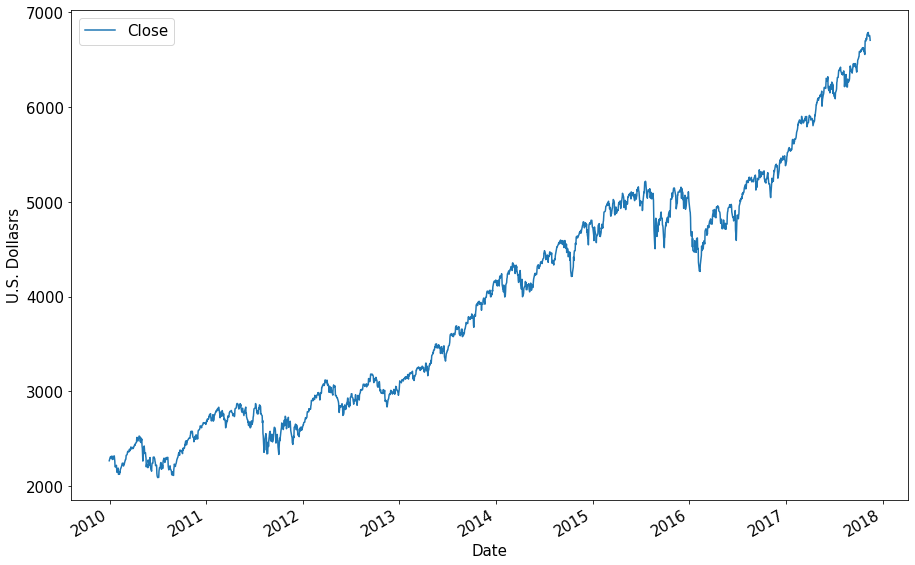

In [15]:
ax = nasdaq_df.plot(y=["Close"], ylabel='U.S. Dollasrs')

We can also plot the returns for all the markets.

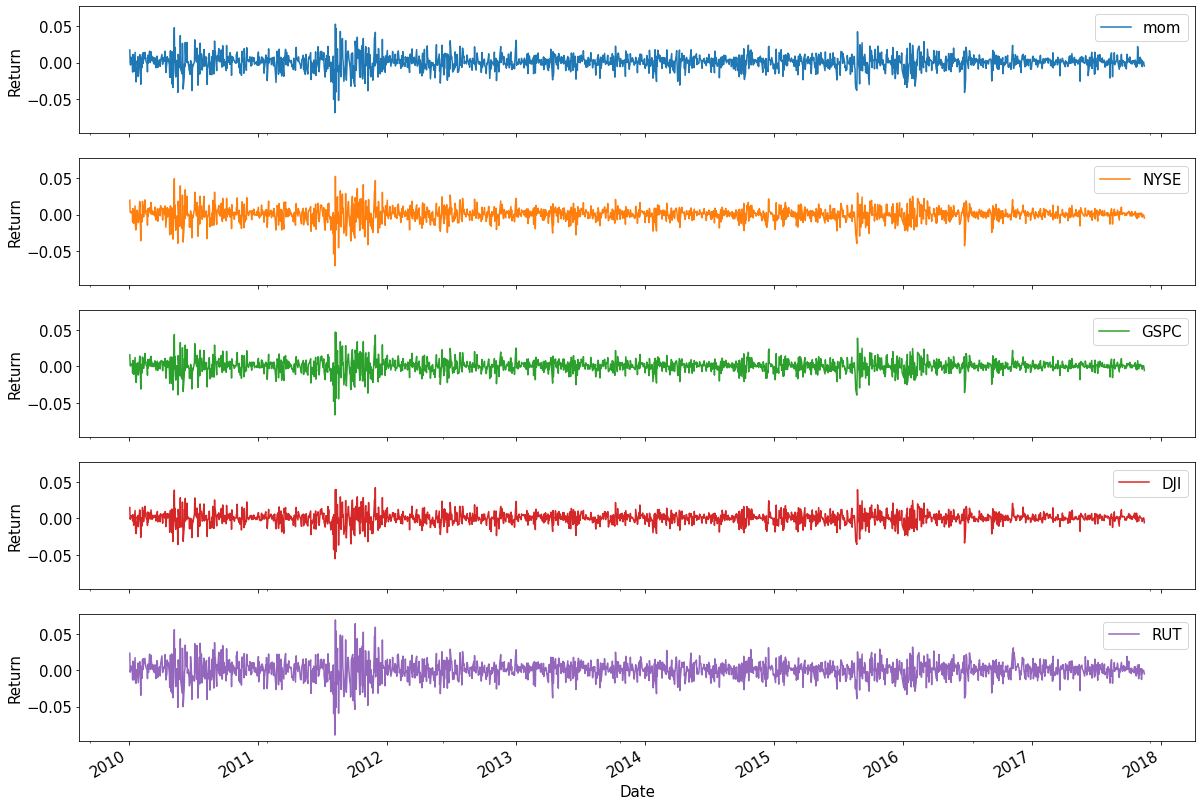

In [16]:
axes = nasdaq_df.plot(y=["mom","NYSE","GSPC","DJI","RUT"], subplots=True, layout=(5,1), figsize=(20,15), sharey=True, sharex=True, ylabel='Return')

We can see that there are some common trends.

One example is the big oscillation we can observe between 2011 and 2012

---

Another interesting aspect to look into is the comparison of Nasdaq return among the different years.

As for different years we may have a different number of data points, here we compare only the years for which have the same amount of data points and for which the number of data points corresponds to the maximum.

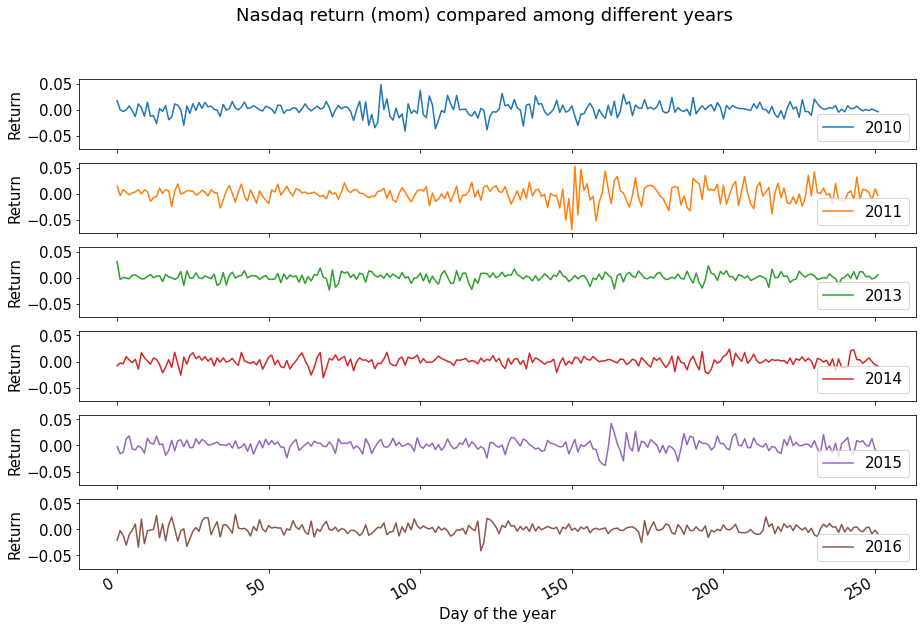

In [17]:
groups = nasdaq_df["mom"].groupby(pd.Grouper(freq='A'))

max_size = 0
for _, group in groups:
    if group.values.shape[0] > max_size:
        max_size = group.values.shape[0]

years = pd.DataFrame()
for name, group in groups:
    if group.values.shape[0] == max_size:
        years[name.year] = group.values

axes = years.plot(subplots=True, xlabel="Day of the year", title="Nasdaq return (mom) compared among different years", ylabel='Return', sharey=True)
for ax in axes:
    ax.legend(loc='lower right')

Apart from some common trends between 2013 and 2014, there are no major similarities between different years.

This gives us an intuition that return depends more on other features rather than time of the year.

---

Here we report also a whisker plot for the return of NASDAQ over the years.

This plot draws a box around the 25th and 75th percentiles of the data that captures the middle 50% of observations. A line is drawn at the 50th percentile (the median) and whiskers are drawn above and below the box to summarize the general extents of the observations. Dots are drawn for outliers outside the whiskers or extents of the data.

Text(0, 0.5, 'Return')

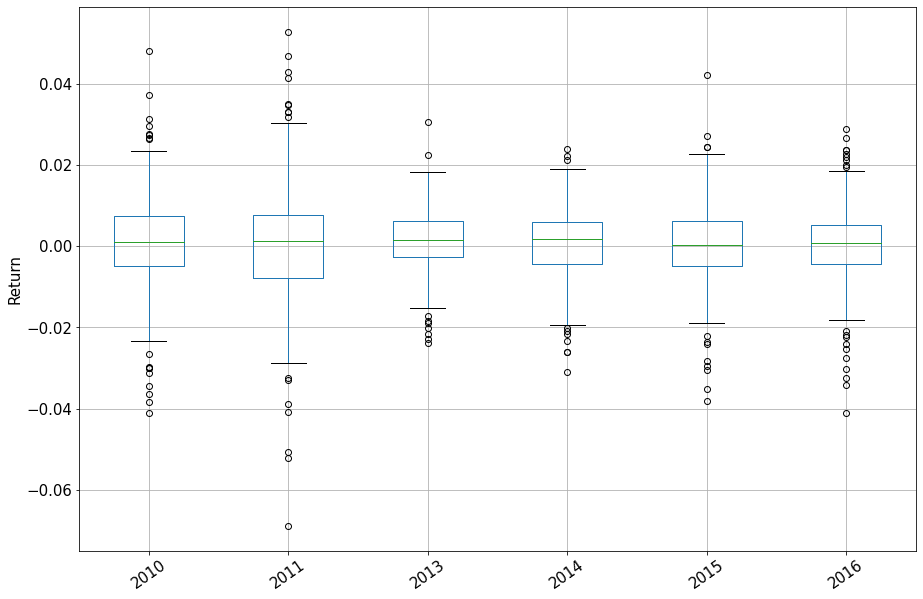

In [18]:
ax = years.boxplot(rot=35)
ax.set_ylabel('Return')

Another interesting plot to visualize is the distribution of the featrues, we can look at this by plotting an histogram for each feature.

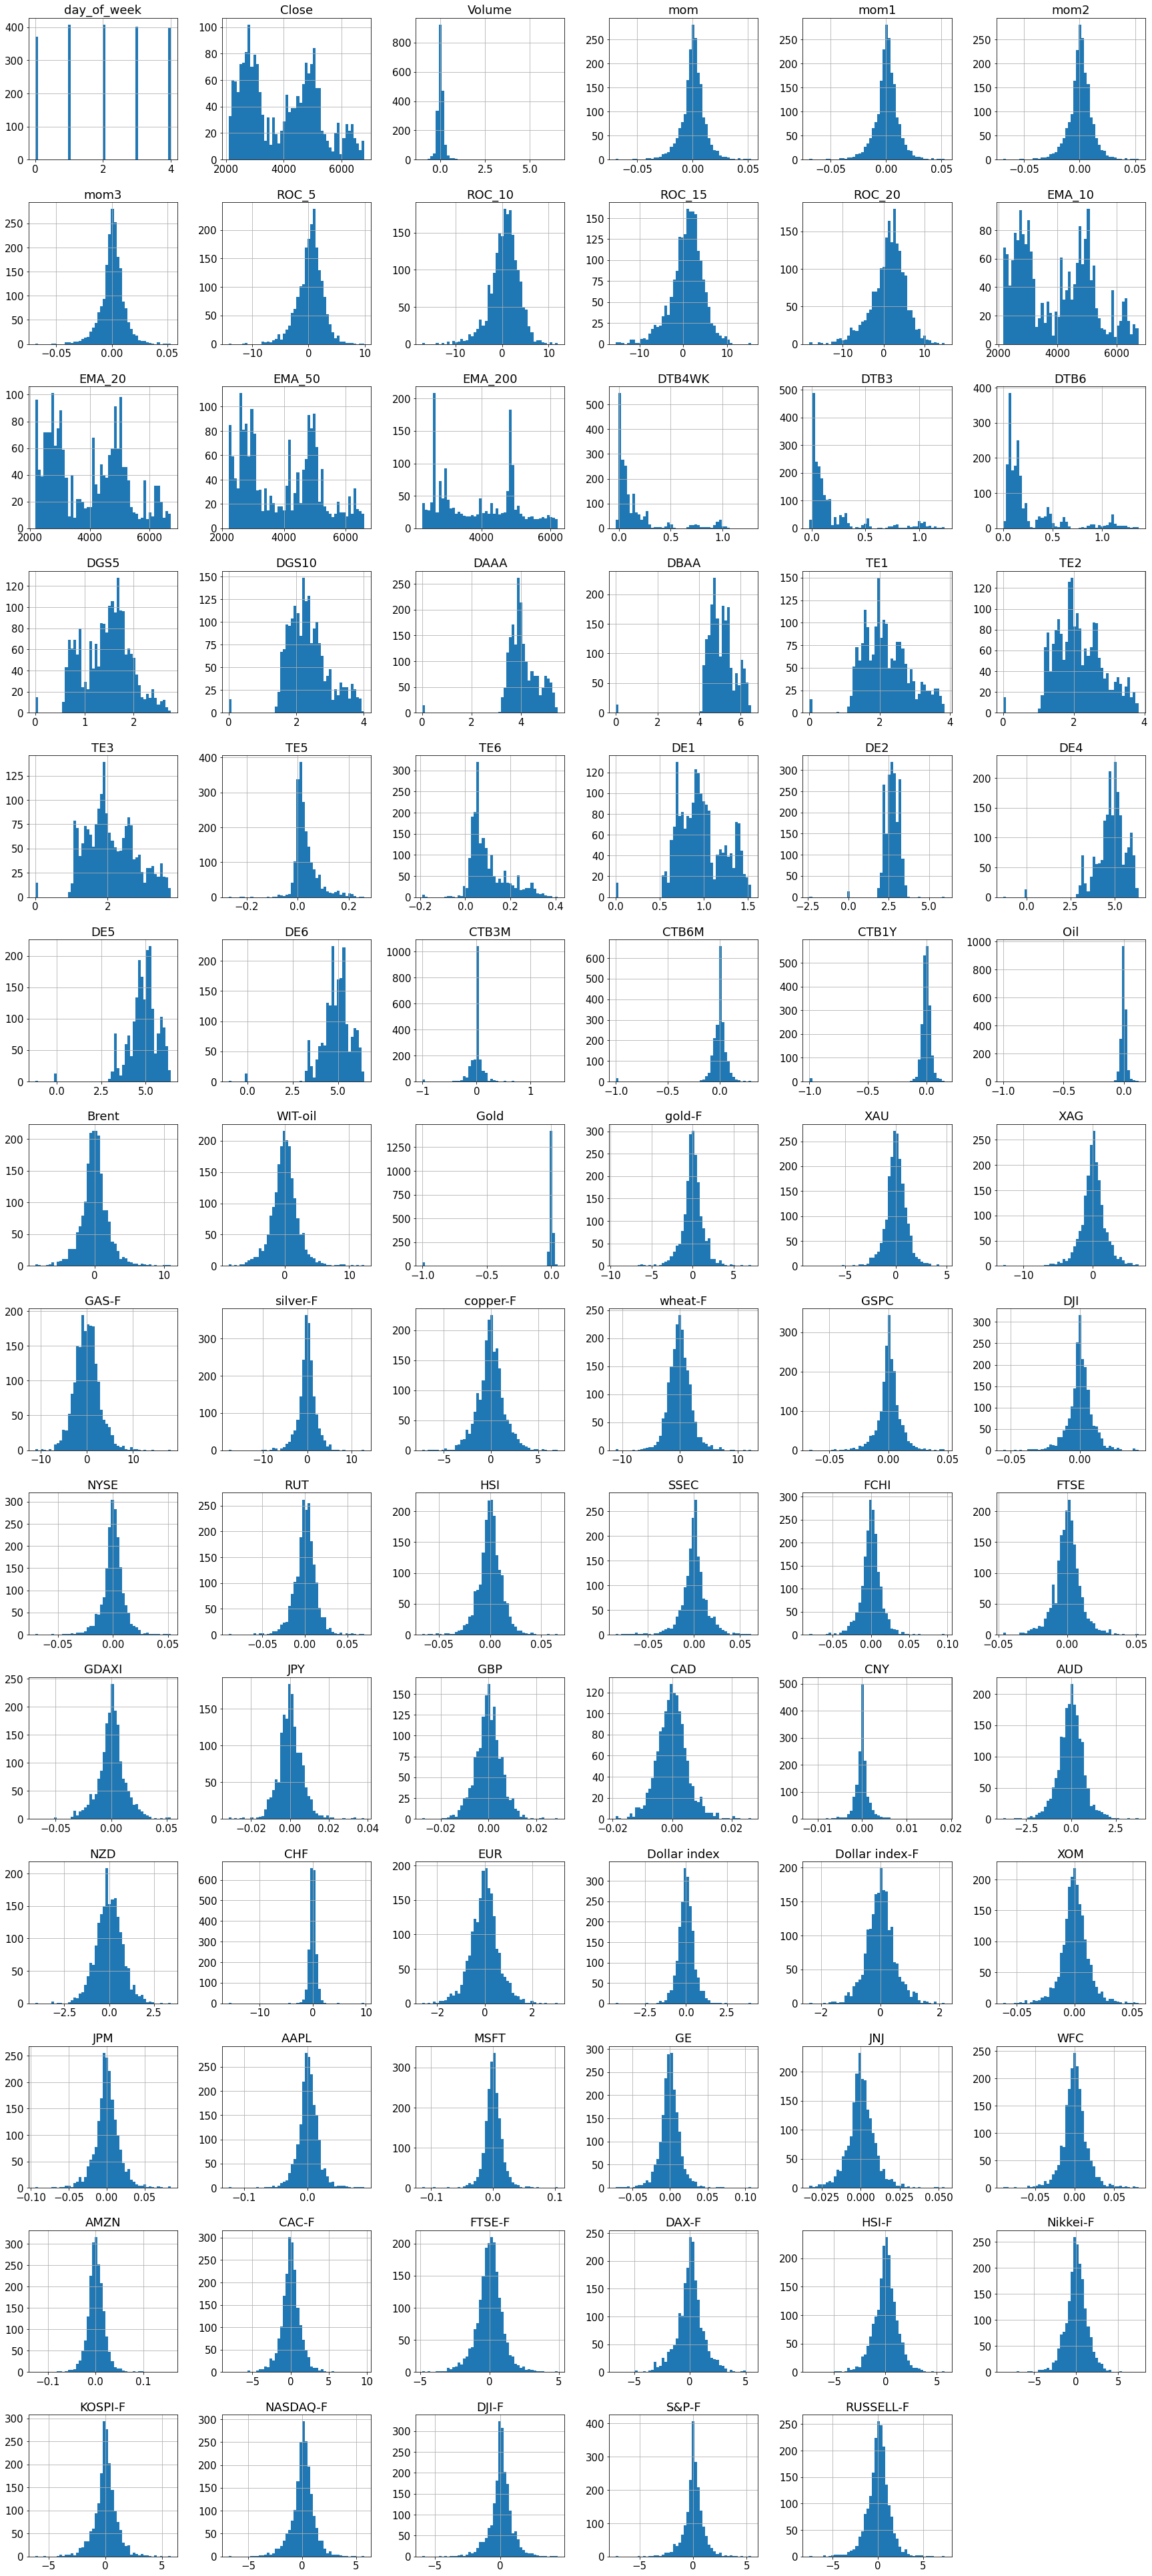

In [19]:
axes = nasdaq_df.hist(figsize=(30,70), bins=50, layout=(-1,6))

We see that a great part of the features is distributed as a gaussian centered in 0.

---

## 4 - Splitting the data: training, validation and test

As already mentioned, our dataset represents a time series. Therefore, random or stratified train/test split strategies cannot be used as it would not enable the machine learning algorithm to benefit from the fact that the data are temporally correlated with each other.

Given this considerations, the only possibility we have is to split the dataset in the most traditional way:

*   The first 60% of the entries will form the **training set**
*   The subsequent 20% will form the **validation set**
*   The last 20% will form the **test set**

Before performing the split we also compute the target vector. For each entry, the target is 1 if there is an increase in the Close price in the following entry and 0 otherwise.

$$ Target_{t} = \begin{cases} 1, & \mbox{if } Close_{t+1}>Close_{t} \\ 0, & \mbox{otherwise} \end{cases}$$

In [20]:
target_df =  nasdaq_df["Close"].shift(-1) - nasdaq_df["Close"]
target = np.where(target_df[:-1].values > 0, 1, 0) # We have to remove the last value as we have no target for it

target.shape

(1983,)

In [21]:
nasdaq_df = nasdaq_df.iloc[:-1,:] # We have to remove the last value as we have no target for it

nasdaq_train = nasdaq_df[:int(nasdaq_df.shape[0]*0.6)]
nasdaq_train_target = target[:int(target.shape[0]*0.6)]

nasdaq_val = nasdaq_df[int(nasdaq_df.shape[0]*0.6):int(nasdaq_df.shape[0]*0.8)]
nasdaq_val_target = target[int(target.shape[0]*0.6):int(target.shape[0]*0.8)]

nasdaq_test =  nasdaq_df[int(nasdaq_df.shape[0]*0.8):]
nasdaq_test_target = target[int(target.shape[0]*0.8):]

In [22]:
print(nasdaq_train.shape, nasdaq_train_target.shape,
      nasdaq_val.shape, nasdaq_val_target.shape,
      nasdaq_test.shape, nasdaq_test_target.shape)

(1189, 83) (1189,) (397, 83) (397,) (397, 83) (397,)


The sets are still in the form of a time series. We will proceed to make them suitable for a supervised learning classical task in [this section](#transforming_the_dataset)

Given the nature of the data it is very difficult to split the dataset properly. This is because the data in the time series is closely correlated with each other and with time. Certain features refer to timesteps that go back even 200 days in the data (like EMA_200).

Therefore it is impossible to ensure that the training, validation and test set will be independent between each other. Our evaluations will always be a bit biased. Note that this is caused by the fact that the data we are analysing is a multivariate time series and by the fact that some features refer to previous timesteps.

To ensure the least interdependence between the sets we split them in the shown way. Only after this split we will proceed to build the superviesed learning dataset. Therefore for each set the first $n-1$ targets (where $n$ is the number of training days considered for the prediction) will not be used, as those are the targets that come from input that is partially of other sets or is not available.

---

Furthermore, we can look at the proportion of the target values in each set:

In [23]:
def subset_proportions(subset):
    props = {}
    for value in set(subset):
        data_value = [i for i in subset if i==value]
        props[value] = len(data_value) / len(subset)
    return props

   
compare_props = pd.DataFrame({
    "Overall": subset_proportions(target),
    "Train": subset_proportions(nasdaq_train_target),
    "Validation": subset_proportions(nasdaq_val_target),
    "Test" : subset_proportions(nasdaq_test_target),
})

compare_props

Overall     Train  Validation      Test
0  0.439738  0.439024    0.463476  0.418136
1  0.560262  0.560976    0.536524  0.581864

We can see that they are pretty balanced. Each class is well represented.

All the three sets of data mantain the proportions of each class similar to the original proportions in the full dataset.

## 5 - Correlations

Now that we have split the dataset we can use our training and validation sets to gain some insights on the correlation of the features.

Let's use nasdaq_train_val for this objective.

In [24]:
nasdaq_train_val = nasdaq_df[:int(nasdaq_df.shape[0]*0.8)]
nasdaq_train_val_target = target[:int(target.shape[0]*0.8)]

nasdaq_train_val.shape, nasdaq_train_val_target.shape

((1586, 83), (1586,))

By doing this we ensure no data leakage between the training/validation sets and test set. The results on the test set are thus a fair evaluation the algorithm's performance.

---

### Autocorrelation

As we said our dataset contains a time series.

Therefore we can analyse the time series of various features.

Let's build the series for:

*   Close, the close price of the Nasdaq market
*   mom, Nasdaq return

In [25]:
close_series = pd.Series(nasdaq_train_val["Close"])

return_series = pd.Series(nasdaq_train_val["mom"].bfill()) # We temporarly backward fill the only NaN in the mom column as we need all the values for plotting

Now that we have mapped the two series to the pandas Series object we can look at their autocorrelation plots.

The autocorrelation plot is a way of measuring and explaining the internal association between observations in a time series. We can check how strong an internal correlation is in an given amount of time.

The autocorrelation plot shows how much the value of the time series is correlated with itself $n$ timesteps in the past. $n$ is called lag.

The dotted lines are just above and below the first quartile, or within the 95% confidence interval. This will indicate the significance of the correlation. If the line is above or below the dotted line, not in between, we can say that the correlation is significant, and that the close value is correlated to time.

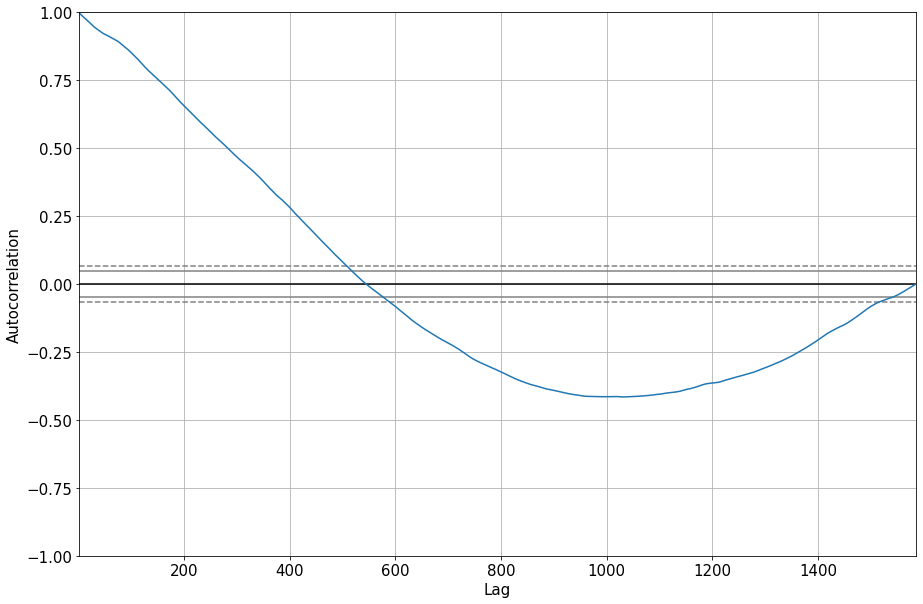

In [26]:
from pandas.plotting import autocorrelation_plot

ax = autocorrelation_plot(close_series)

In this plot we can see that the close price is highly correlated with itself in the first part of the graph. The correlation decreases with the increase of the lag as we can expect.
This is intuitive as the close price is a variable that we expect to be correlated with itself for small lags.

There is an interesting negative correlation in the second half of the plot. This could suggest a trend of stock markets to rebalance themselves every three-four years. This could also be an effect of the economic crisis.

This plot suggestes that there is an association between time and close price.

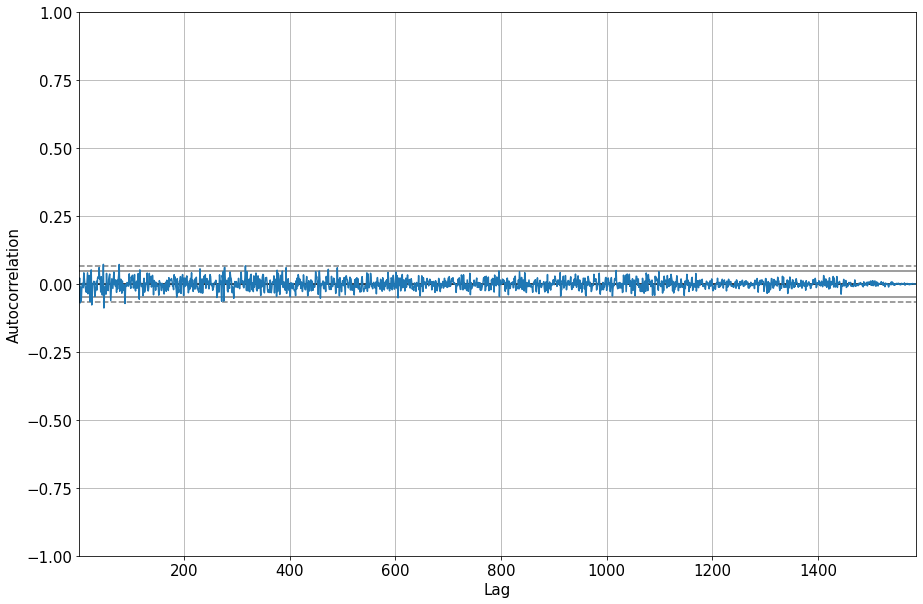

In [27]:
ax = autocorrelation_plot(return_series)

This plot shows that the return of NASDAQ is not correlated with itself in the past and therefore we will rely on other features to predict our target.

---

Now let's look at the correlation among the features.

First we will plot the correlation matrix among features of the same category.

In [28]:
primitive_indices = ["Close","mom"]

These are the features that resemble our target, therefore we will see the correlation of these with all the other features grouped by cathegory

### Technical indicators

Let's see the correlation between primitive features and technincal indicators.

In [29]:
technical_indeces.remove("mom")
correlation_matrix = nasdaq_train_val[primitive_indices + technical_indeces].corr()
correlation_matrix

Close       mom    Volume      mom1      mom2      mom3     ROC_5  \
Close    1.000000  0.013161 -0.011268  0.012950  0.013817  0.011290  0.030924   
mom      0.013161  1.000000 -0.108134 -0.016773  0.022035 -0.069554  0.422672   
Volume  -0.011268 -0.108134  1.000000 -0.003307  0.033640  0.013937 -0.037671   
mom1     0.012950 -0.016773 -0.003307  1.000000 -0.016750  0.022016  0.422485   
mom2     0.013817  0.022035  0.033640 -0.016750  1.000000 -0.016665  0.464974   
mom3     0.011290 -0.069554  0.013937  0.022016 -0.016665  1.000000  0.426354   
ROC_5    0.030924  0.422672 -0.037671  0.422485  0.464974  0.426354  1.000000   
ROC_10   0.038706  0.285440 -0.013203  0.286032  0.294239  0.271127  0.651907   
ROC_15   0.043148  0.240468 -0.027852  0.245355  0.254517  0.237996  0.557919   
ROC_20   0.041405  0.202192 -0.037264  0.202210  0.217310  0.190382  0.461700   
EMA_10   0.998540 -0.015352 -0.006736 -0.010861 -0.005034 -0.001915 -0.014659   
EMA_20   0.996993 -0.021869 -0.006284 -0.017482 -0.014936 -0.012700 -0.035387   
EMA_50   0.993306 -0.016100 -0.008496 -0.014904 -0.013651 -0.013477 -0.032125   
EMA_200  0.979900 -0.017654 -0.012860 -0.017184 -0.017302 -0.017970 -0.039907   

           ROC_10    ROC_15    ROC_20    EMA_10    EMA_20    EMA_50   EMA_200  
Close    0.038706  0.043148  0.041405  0.998540  0.996993  0.993306  0.979900  
mom      0.285440  0.240468  0.202192 -0.015352 -0.021869 -0.016100 -0.017654  
Volume  -0.013203 -0.027852 -0.037264 -0.006736 -0.006284 -0.008496 -0.012860  
mom1     0.286032  0.245355  0.202210 -0.010861 -0.017482 -0.014904 -0.017184  
mom2     0.294239  0.254517  0.217310 -0.005034 -0.014936 -0.013651 -0.017302  
mom3     0.271127  0.237996  0.190382 -0.001915 -0.012700 -0.013477 -0.017970  
ROC_5    0.651907  0.557919  0.461700 -0.014659 -0.035387 -0.032125 -0.039907  
ROC_10   1.000000  0.776096  0.675935 -0.004512 -0.033586 -0.045388 -0.063019  
ROC_15   0.776096  1.000000  0.827647  0.004394 -0.025975 -0.052894 -0.077817  
ROC_20   0.675935  0.827647  1.000000  0.007143 -0.020521 -0.058151 -0.093433  
EMA_10  -0.004512  0.004394  0.007143  1.000000  0.999490  0.996589  0.983569  
EMA_20  -0.033586 -0.025975 -0.020521  0.999490  1.000000  0.998476  0.986642  
EMA_50  -0.045388 -0.052894 -0.058151  0.996589  0.998476  1.000000  0.992866  
EMA_200 -0.063019 -0.077817 -0.093433  0.983569  0.986642  0.992866  1.000000

In [30]:
correlation_matrix["mom"].sort_values(ascending=False)

mom        1.000000
ROC_5      0.422672
ROC_10     0.285440
ROC_15     0.240468
ROC_20     0.202192
mom2       0.022035
Close      0.013161
EMA_10    -0.015352
EMA_50    -0.016100
mom1      -0.016773
EMA_200   -0.017654
EMA_20    -0.021869
mom3      -0.069554
Volume    -0.108134
Name: mom, dtype: float64

In [31]:
correlation_matrix["Close"].sort_values(ascending=False)

Close      1.000000
EMA_10     0.998540
EMA_20     0.996993
EMA_50     0.993306
EMA_200    0.979900
ROC_15     0.043148
ROC_20     0.041405
ROC_10     0.038706
ROC_5      0.030924
mom2       0.013817
mom        0.013161
mom1       0.012950
mom3       0.011290
Volume    -0.011268
Name: Close, dtype: float64

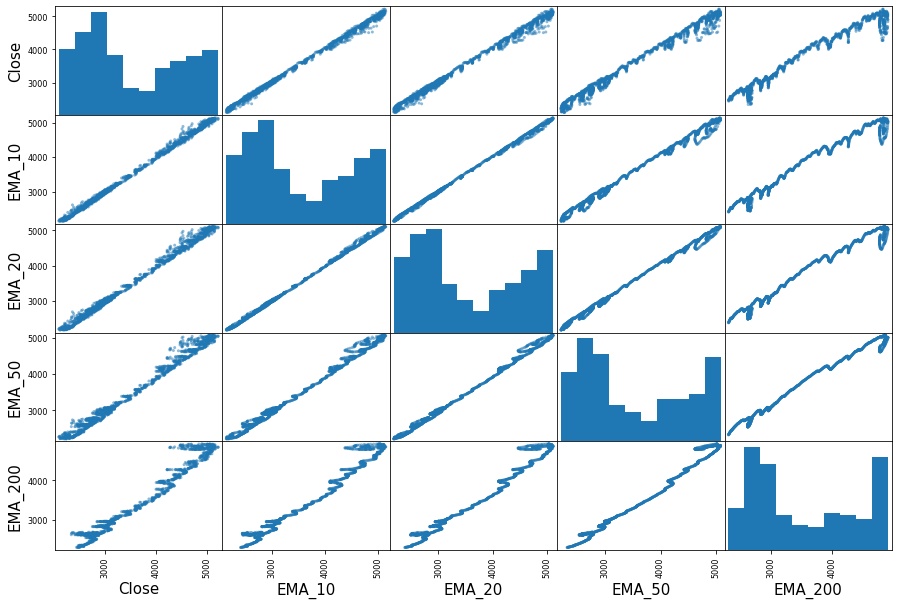

In [32]:
from pandas.plotting import scatter_matrix

attributes = ["Close","EMA_10","EMA_20","EMA_50","EMA_200"]
axes = scatter_matrix(nasdaq_train_val[attributes])

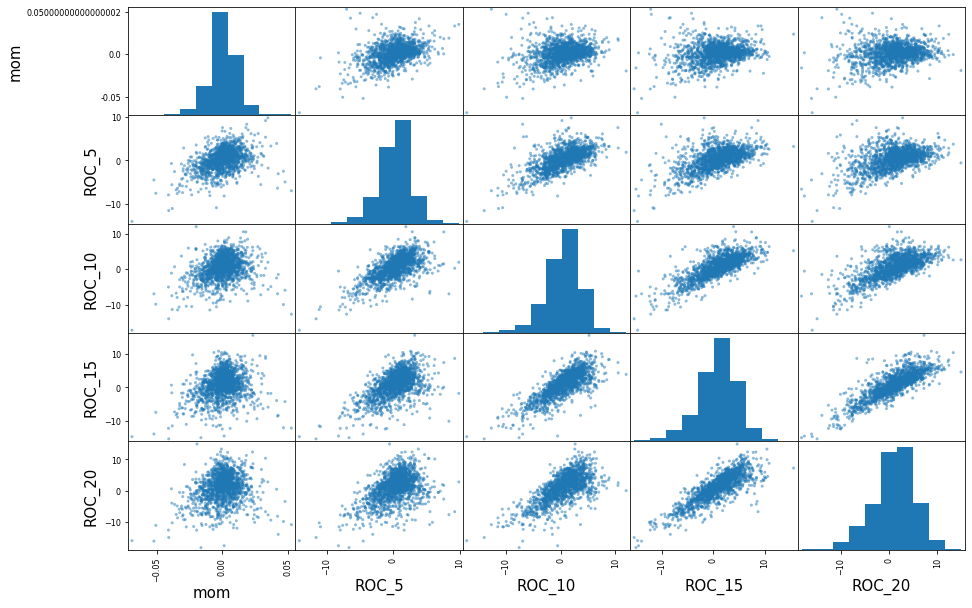

In [33]:
attributes = ["mom","ROC_5","ROC_10","ROC_15","ROC_20"]
axes = scatter_matrix(nasdaq_train_val[attributes])

We see that the close price is very correlated with all the EMA features and the return slightly correlates with the ROC features.

### Economic indicators

In [34]:
correlation_matrix = nasdaq_train_val[primitive_indices + economic_indices].corr()
correlation_matrix

Close       mom    DTB4WK      DTB3      DTB6      DGS5     DGS10  \
Close   1.000000  0.013161 -0.140384 -0.146324  0.084550  0.046720 -0.321696   
mom     0.013161  1.000000  0.000515  0.000126 -0.020002  0.002118  0.009458   
DTB4WK -0.140384  0.000515  1.000000  0.907245  0.792518  0.089288  0.079501   
DTB3   -0.146324  0.000126  0.907245  1.000000  0.904716  0.138286  0.114980   
DTB6    0.084550 -0.020002  0.792518  0.904716  1.000000  0.197716  0.059810   
DGS5    0.046720  0.002118  0.089288  0.138286  0.197716  1.000000  0.889013   
DGS10  -0.321696  0.009458  0.079501  0.114980  0.059810  0.889013  1.000000   
DAAA   -0.371742  0.008784  0.131336  0.167665  0.108481  0.755180  0.928366   
DBAA   -0.426038  0.004862  0.271920  0.337785  0.312782  0.625489  0.791311   
TE1    -0.308606  0.009435 -0.020307  0.024558 -0.019298  0.882719  0.995015   
TE2    -0.307973  0.009508 -0.018317  0.007344 -0.037864  0.879934  0.994185   
TE3    -0.333942  0.012547 -0.044046 -0.026125 -0.095966  0.855730  0.987863   
TE5    -0.038684 -0.000833 -0.045227  0.379140  0.405232  0.132008  0.098187   
TE6     0.277159 -0.032349  0.243808  0.516519  0.784668  0.223660  0.014301   
DE1    -0.195090 -0.008831  0.382639  0.464320  0.543922 -0.223847 -0.217353   
DE2    -0.203514 -0.006234  0.316265  0.368843  0.410653 -0.318462 -0.218184   
DE4    -0.454384  0.008046  0.162926  0.214367  0.174139  0.618785  0.811403   
DE5    -0.423785  0.004996  0.186707  0.245005  0.229058  0.630060  0.803266   
DE6    -0.421950  0.004919  0.183222  0.259279  0.244585  0.630533  0.800857   
CTB3M   0.018982  0.016548  0.042106  0.056368  0.083578  0.140037  0.184384   
CTB6M   0.016861  0.106094  0.071746  0.086419  0.102466  0.216721  0.284083   
CTB1Y   0.008552  0.126057  0.078514  0.093466  0.109504  0.237949  0.318466   

            DAAA      DBAA       TE1  ...       TE5       TE6       DE1  \
Close  -0.371742 -0.426038 -0.308606  ... -0.038684  0.277159 -0.195090   
mom     0.008784  0.004862  0.009435  ... -0.000833 -0.032349 -0.008831   
DTB4WK  0.131336  0.271920 -0.020307  ... -0.045227  0.243808  0.382639   
DTB3    0.167665  0.337785  0.024558  ...  0.379140  0.516519  0.464320   
DTB6    0.108481  0.312782 -0.019298  ...  0.405232  0.784668  0.543922   
DGS5    0.755180  0.625489  0.882719  ...  0.132008  0.223660 -0.223847   
DGS10   0.928366  0.791311  0.995015  ...  0.098187  0.014301 -0.217353   
DAAA    1.000000  0.922319  0.917982  ...  0.109278  0.039010 -0.053366   
DBAA    0.922319  1.000000  0.766456  ...  0.204044  0.220998  0.336657   
TE1     0.917982  0.766456  1.000000  ...  0.103003 -0.010048 -0.256278   
TE2     0.916364  0.759956  0.998969  ...  0.057741 -0.041595 -0.269130   
TE3     0.908858  0.740400  0.995202  ...  0.034852 -0.107839 -0.301375   
TE5     0.109278  0.204044  0.103003  ...  1.000000  0.690402  0.260992   
TE6     0.039010  0.220998 -0.010048  ...  0.690402  1.000000  0.476026   
DE1    -0.053366  0.336657 -0.256278  ...  0.260992  0.476026  1.000000   
DE2     0.097033  0.424033 -0.250472  ...  0.180247  0.331563  0.859305   
DE4     0.939918  0.989780  0.797512  ...  0.150702  0.111312  0.267365   
DE5     0.932791  0.995295  0.786972  ...  0.171152  0.174474  0.298984   
DE6     0.929789  0.995851  0.784904  ...  0.212721  0.202709  0.307734   
CTB3M   0.292802  0.347553  0.180724  ...  0.041246  0.090150  0.184494   
CTB6M   0.435856  0.510346  0.277754  ...  0.047413  0.090055  0.256531   
CTB1Y   0.486958  0.567914  0.311564  ...  0.049261  0.094370  0.280753   

             DE2       DE4       DE5       DE6     CTB3M     CTB6M     CTB1Y  
Close  -0.203514 -0.454384 -0.423785 -0.421950  0.018982  0.016861  0.008552  
mom    -0.006234  0.008046  0.004996  0.004919  0.016548  0.106094  0.126057  
DTB4WK  0.316265  0.162926  0.186707  0.183222  0.042106  0.071746  0.078514  
DTB3    0.368843  0.214367  0.245005  0.259279  0.056368  0.086419  0.093466  
DTB6    0.410653  0.174139  0.229058  0.244585  0

In [35]:
correlation_matrix["mom"].sort_values(ascending=False)

mom       1.000000
CTB1Y     0.126057
CTB6M     0.106094
CTB3M     0.016548
Close     0.013161
TE3       0.012547
TE2       0.009508
DGS10     0.009458
TE1       0.009435
DAAA      0.008784
DE4       0.008046
DE5       0.004996
DE6       0.004919
DBAA      0.004862
DGS5      0.002118
DTB4WK    0.000515
DTB3      0.000126
TE5      -0.000833
DE2      -0.006234
DE1      -0.008831
DTB6     -0.020002
TE6      -0.032349
Name: mom, dtype: float64

In [36]:
correlation_matrix["Close"].sort_values(ascending=False)

Close     1.000000
TE6       0.277159
DTB6      0.084550
DGS5      0.046720
CTB3M     0.018982
CTB6M     0.016861
mom       0.013161
CTB1Y     0.008552
TE5      -0.038684
DTB4WK   -0.140384
DTB3     -0.146324
DE1      -0.195090
DE2      -0.203514
TE2      -0.307973
TE1      -0.308606
DGS10    -0.321696
TE3      -0.333942
DAAA     -0.371742
DE6      -0.421950
DE5      -0.423785
DBAA     -0.426038
DE4      -0.454384
Name: Close, dtype: float64

array([[<AxesSubplot:xlabel='Close', ylabel='Close'>,
        <AxesSubplot:xlabel='mom', ylabel='Close'>,
        <AxesSubplot:xlabel='TE6', ylabel='Close'>,
        <AxesSubplot:xlabel='DE4', ylabel='Close'>,
        <AxesSubplot:xlabel='DBAA', ylabel='Close'>],
       [<AxesSubplot:xlabel='Close', ylabel='mom'>,
        <AxesSubplot:xlabel='mom', ylabel='mom'>,
        <AxesSubplot:xlabel='TE6', ylabel='mom'>,
        <AxesSubplot:xlabel='DE4', ylabel='mom'>,
        <AxesSubplot:xlabel='DBAA', ylabel='mom'>],
       [<AxesSubplot:xlabel='Close', ylabel='TE6'>,
        <AxesSubplot:xlabel='mom', ylabel='TE6'>,
        <AxesSubplot:xlabel='TE6', ylabel='TE6'>,
        <AxesSubplot:xlabel='DE4', ylabel='TE6'>,
        <AxesSubplot:xlabel='DBAA', ylabel='TE6'>],
       [<AxesSubplot:xlabel='Close', ylabel='DE4'>,
        <AxesSubplot:xlabel='mom', ylabel='DE4'>,
        <AxesSubplot:xlabel='TE6', ylabel='DE4'>,
        <AxesSubplot:xlabel='DE4', ylabel='DE4'>,
        <AxesSubplot:xlabe

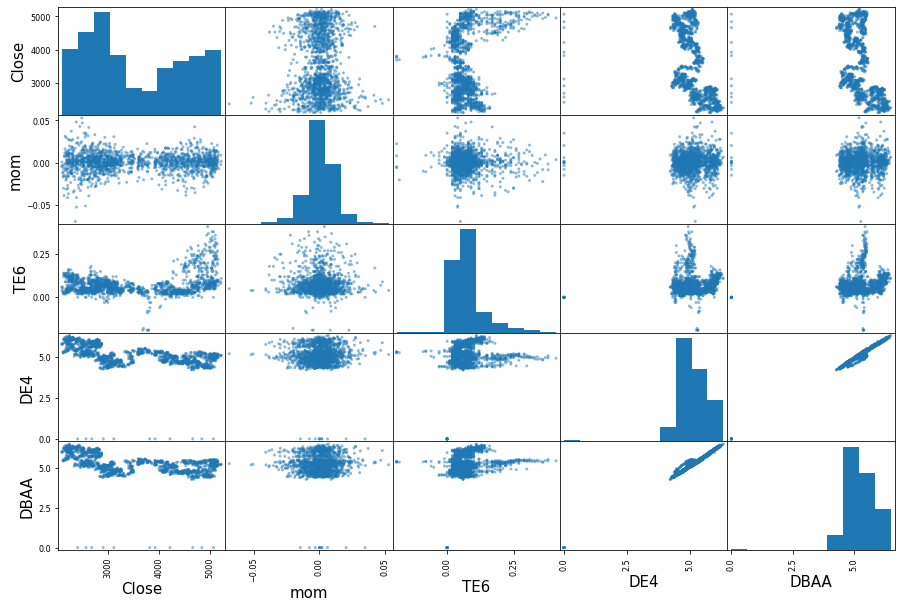

In [37]:
attributes = ["Close", "mom", "TE6", "DE4", "DBAA"]
scatter_matrix(nasdaq_train_val[attributes])

We can see some other correlations in the data

### Word markets indices

In [38]:
correlation_matrix = nasdaq_train_val[primitive_indices + word_indices].corr()
correlation_matrix

Close       mom      GSPC       DJI      NYSE       RUT       HSI  \
Close  1.000000  0.013161  0.008516  0.005252  0.003352 -0.002501  0.009781   
mom    0.013161  1.000000  0.957004  0.910326  0.920707  0.934170  0.227250   
GSPC   0.008516  0.957004  1.000000  0.977023  0.980936  0.920757  0.212040   
DJI    0.005252  0.910326  0.977023  1.000000  0.958752  0.874119  0.204410   
NYSE   0.003352  0.920707  0.980936  0.958752  1.000000  0.916206  0.251728   
RUT   -0.002501  0.934170  0.920757  0.874119  0.916206  1.000000  0.190366   
HSI    0.009781  0.227250  0.212040  0.204410  0.251728  0.190366  1.000000   
SSEC   0.038348  0.160957  0.141986  0.131946  0.156987  0.128614  0.537265   
FCHI   0.019246  0.624372  0.663368  0.667839  0.697693  0.594675  0.375158   
FTSE  -0.000397  0.615035  0.655497  0.662310  0.690107  0.584461  0.416957   
GDAXI  0.010870  0.621112  0.650377  0.658623  0.675278  0.595792  0.366131   

           SSEC      FCHI      FTSE     GDAXI  
Close  0.038348  0.019246 -0.000397  0.010870  
mom    0.160957  0.624372  0.615035  0.621112  
GSPC   0.141986  0.663368  0.655497  0.650377  
DJI    0.131946  0.667839  0.662310  0.658623  
NYSE   0.156987  0.697693  0.690107  0.675278  
RUT    0.128614  0.594675  0.584461  0.595792  
HSI    0.537265  0.375158  0.416957  0.366131  
SSEC   1.000000  0.174730  0.207577  0.162856  
FCHI   0.174730  1.000000  0.889692  0.933846  
FTSE   0.207577  0.889692  1.000000  0.859446  
GDAXI  0.162856  0.933846  0.859446  1.000000

In [39]:
correlation_matrix["mom"].sort_values(ascending=False)

mom      1.000000
GSPC     0.957004
RUT      0.934170
NYSE     0.920707
DJI      0.910326
FCHI     0.624372
GDAXI    0.621112
FTSE     0.615035
HSI      0.227250
SSEC     0.160957
Close    0.013161
Name: mom, dtype: float64

In [40]:
correlation_matrix["Close"].sort_values(ascending=False)

Close    1.000000
SSEC     0.038348
FCHI     0.019246
mom      0.013161
GDAXI    0.010870
HSI      0.009781
GSPC     0.008516
DJI      0.005252
NYSE     0.003352
FTSE    -0.000397
RUT     -0.002501
Name: Close, dtype: float64

In [41]:
nasdaq_train_val.describe()

day_of_week        Close       Volume          mom         mom1  \
count  1586.000000  1586.000000  1585.000000  1585.000000  1584.000000   
mean      2.018916  3532.080770     0.020195     0.000556     0.000555   
std       1.398835   957.688434     0.258684     0.011263     0.011267   
min       0.000000  2091.790039    -1.000000    -0.068994    -0.068994   
25%       1.000000  2710.084900    -0.079956    -0.004554    -0.004554   
50%       2.000000  3192.015014     0.000661     0.000951     0.000940   
75%       3.000000  4473.302612     0.088186     0.006720     0.006721   
max       4.000000  5218.859863     6.546584     0.052946     0.052946   

              mom2         mom3        ROC_5       ROC_10       ROC_15  ...  \
count  1583.000000  1582.000000  1581.000000  1576.000000  1571.000000  ...   
mean      0.000558     0.000555     0.272818     0.533787     0.805126  ...   
std       0.011270     0.011273     2.439414     3.218140     3.908539  ...   
min      -0.068994    -0.068994   -14.097455   -17.064517   -15.392485  ...   
25%      -0.004554    -0.004554    -1.054697    -1.318952    -1.319184  ...   
50%       0.000951     0.000940     0.502718     0.847296     1.136129  ...   
75%       0.006721     0.006722     1.761723     2.624453     3.326006  ...   
max       0.052946     0.052946     9.856024    11.948208    15.566623  ...   

             CAC-F      FTSE-F        DAX-F        HSI-F     Nikkei-F  \
count  1584.000000  1581.00000  1582.000000  1526.000000  1586.000000   
mean      0.014122     0.01000     0.035550     0.007379     0.035631   
std       1.386483     1.00414     1.298325     1.257147     1.396037   
min      -7.100000    -4.83000    -6.040000    -7.390000    -8.670000   
25%      -0.702500    -0.49000    -0.607500    -0.680000    -0.750000   
50%       0.050000     0.05000     0.080000     0.025000     0.070000   
75%       0.770000     0.58000     0.710000     0.740000     0.810000   
max       9.640000     4.91000     5.520000     5.790000     7.410000   

           KOSPI-F     NASDAQ-F        DJI-F        S&P-F    RUSSELL-F  
count  1531.000000  1586.000000  1586.000000  1586.000000  1586.000000  
mean      0.007120     0.057919     0.036885     0.041822     0.063108  
std       1.091241     1.106648     0.923887     1.017434     1.323603  
min      -6.180000    -6.810000    -5.930000    -7.220000    -7.540000  
25%      -0.520000    -0.450000    -0.390000    -0.400000    -0.620000  
50%       0.020000     0.100000     0.070000     0.070000     0.140000  
75%       0.550000     0.650000     0.520000     0.550000     0.790000  
max       5.750000     5.740000     4.360000     5.440000     7.390000  

[8 rows x 83 columns]

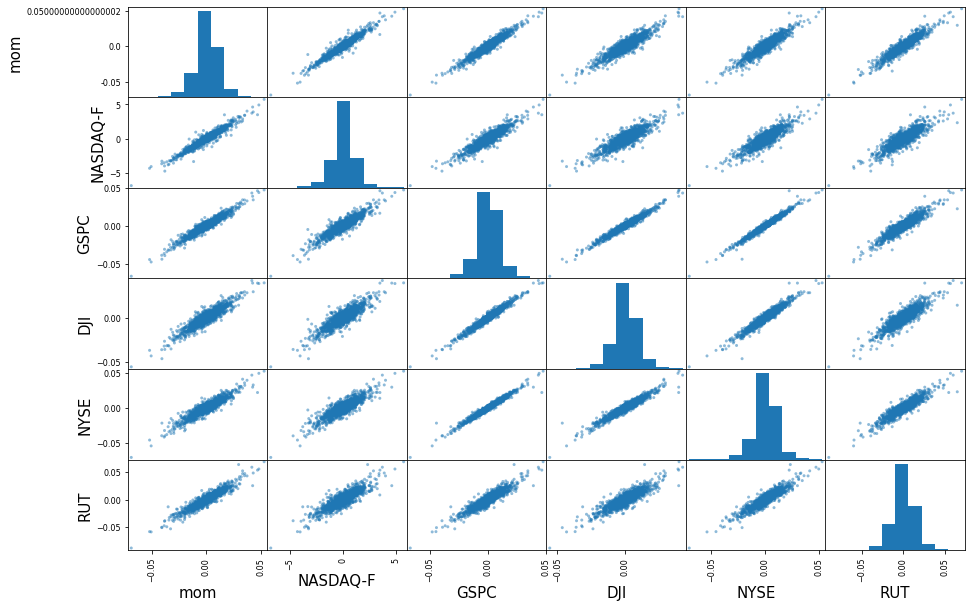

In [42]:
attributes = primitive_indices[1:] + futures_indices[6:7] + word_indices[:4]
axes = scatter_matrix(nasdaq_train_val[attributes])

Here we can se that all the returns from the stock markets are very closely correlated with each other and nasdaq return correlates with its futures.

### All features

Now we look at the correlation between the primitive features and all other features.

In [43]:
correlation_matrix = nasdaq_train_val.corr()
correlation_matrix

day_of_week     Close    Volume       mom      mom1      mom2  \
day_of_week     1.000000 -0.012143  0.036965 -0.000538  0.012834  0.015087   
Close          -0.012143  1.000000 -0.011268  0.013161  0.012950  0.013817   
Volume          0.036965 -0.011268  1.000000 -0.108134 -0.003307  0.033640   
mom            -0.000538  0.013161 -0.108134  1.000000 -0.016773  0.022035   
mom1            0.012834  0.012950 -0.003307 -0.016773  1.000000 -0.016750   
...                  ...       ...       ...       ...       ...       ...   
KOSPI-F        -0.022613 -0.011907 -0.019405  0.232341  0.401254  0.037789   
NASDAQ-F       -0.004584  0.011671 -0.092936  0.962628  0.010604  0.020419   
DJI-F           0.026998  0.001422 -0.076953  0.883515 -0.026927  0.031725   
S&P-F           0.024065  0.007044 -0.084694  0.933641 -0.037846  0.021664   
RUSSELL-F       0.003713  0.008845 -0.088742  0.907180 -0.044585  0.008577   

                 mom3     ROC_5    ROC_10    ROC_15  ...     CAC-F    FTSE-F  \
day_of_week  0.009849  0.000494  0.000615 -0.006653  ...  0.044035  0.035365   
Close        0.011290  0.030924  0.038706  0.043148  ...  0.015351 -0.005074   
Volume       0.013937 -0.037671 -0.013203 -0.027852  ... -0.077432 -0.099410   
mom         -0.069554  0.422672  0.285440  0.240468  ...  0.604830  0.607417   
mom1         0.022016  0.422485  0.286032  0.245355  ...  0.142612  0.191975   
...               ...       ...       ...       ...  ...       ...       ...   
KOSPI-F      0.013971  0.324174  0.199642  0.169046  ...  0.308410  0.358025   
NASDAQ-F    -0.054712  0.419921  0.284305  0.236409  ...  0.589933  0.598192   
DJI-F       -0.042801  0.376035  0.246781  0.207020  ...  0.657017  0.675478   
S&P-F       -0.058007  0.386577  0.247182  0.210279  ...  0.647423  0.655735   
RUSSELL-F   -0.049065  0.366675  0.235462  0.209878  ...  0.561275  0.562968   

                DAX-F     HSI-F  Nikkei-F   KOSPI-F  NASDAQ-F     DJI-F  \
day_of_week  0.010408  0.049752  0.031316 -0.022613 -0.004584  0.026998   
Close        0.010063  0.003176  0.016234 -0.011907  0.011671  0.001422   
Volume      -0.082091 -0.045228 -0.016217 -0.019405 -0.092936 -0.076953   
mom          0.611141  0.246801  0.200413  0.232341  0.962628  0.883515   
mom1         0.168887  0.392972  0.421369  0.401254  0.010604 -0.026927   
...               ...       ...       ...       ...       ...       ...   
KOSPI-F      0.305860  0.599778  0.522184  1.000000  0.243994  0.225118   
NASDAQ-F     0.595033  0.249128  0.204856  0.243994  1.000000  0.882729   
DJI-F        0.654959  0.246927  0.190190  0.225118  0.882729  1.000000   
S&P-F        0.639322  0.246341  0.193073  0.227532  0.930835  0.973171   
RUSSELL-F    0.562270  0.199343  0.160713  0.195510  0.857320  0.854137   

                S&P-F  RUSSELL-F  
day_of_week  0.024065   0.003713  
Close        0.007044   0.008845  
Volume      -0.084694  -0.088742  
mom          0.933641   0.907180  
mom1        -0.037846  -0.044585  
...               ...        ...  
KOSPI-F      0.227532   0.195510  
NASDAQ-F     0.930835   0.857320  
DJI-F        0.973171   0.854137  
S&P-F        1.000000   0.901335  
RUSSELL-F    0.901335   1.000000  

[83 rows x 83 columns]

In [44]:
correlation_matrix["mom"].sort_values(ascending=False)

mom               1.000000
NASDAQ-F          0.962628
GSPC              0.957004
RUT               0.934170
S&P-F             0.933641
                    ...   
mom3             -0.069554
Volume           -0.108134
Dollar index-F   -0.212775
Dollar index     -0.217677
CAD              -0.249093
Name: mom, Length: 83, dtype: float64

In [45]:
correlation_matrix["Close"].sort_values(ascending=False)

Close      1.000000
EMA_10     0.998540
EMA_20     0.996993
EMA_50     0.993306
EMA_200    0.979900
             ...   
DAAA      -0.371742
DE6       -0.421950
DE5       -0.423785
DBAA      -0.426038
DE4       -0.454384
Name: Close, Length: 83, dtype: float64

As we can see the return is very correlated with the returns of other stock markets and with its and their futures. We can also see a significant negative correlation with the relative change in the U.S dollar index.

The close price is very correlated with the exponential moving average and negatively correlated with economic features.

## 6 - Data transformations

Now that we have explored the attributes and their correlation we can transform our data to prepare it for the machine learning algorithms.

<a name="missing_values"></a>

### Missing values

In our dataset there are some missing values. Therefore we need to define a strategy to treat them.

Given the fact that we are working with time series we use the interpolation function provided by pandas, which interpolates the missing values using the time index.

Then to fill the remaining missing values in the first rows of the dataset, we perform backwards filling using pandas' `bfill()` function. This function propagates backwards the first valid value to fill the remaining missing values.

In [46]:
nasdaq_train = nasdaq_train.interpolate(method='time')
nasdaq_train = nasdaq_train.bfill()

nasdaq_train_val = nasdaq_train_val.interpolate(method='time')
nasdaq_train_val = nasdaq_train_val.bfill()

nasdaq_val = nasdaq_val.interpolate(method='time')
nasdaq_val = nasdaq_val.bfill()

nasdaq_test = nasdaq_test.interpolate(method='time')
nasdaq_test = nasdaq_test.bfill()

<a name="cathegorical_values"></a>

### Categorical features

In the dataset we have just one categorical feature which is "day_of_week"

It is already expressed as an int, with the following mapping:

*   0 -> Monday
*   1 -> Tuesday
*   2 -> Wednesday
*   3 -> Thursday
*   4 -> Friday

In this case we do not need to map it to a one-hot encoding, as we want the alogrithm to benefit from the similarity given from this encoding of the days of the week.

Note that we never have data on Saturdays and Sundays, as in those days the stock market is closed.




### Feature scaling

Finally, we want to standardise our features as they have various different ranges.

To do this we perform standard scaling of the features.

In [47]:
from sklearn.preprocessing import StandardScaler

nasdaq_train = pd.DataFrame(data=StandardScaler().fit_transform(nasdaq_train), columns=nasdaq_train.columns, index=nasdaq_train.index)

nasdaq_train_val = pd.DataFrame(data=StandardScaler().fit_transform(nasdaq_train_val), columns=nasdaq_train_val.columns, index=nasdaq_train_val.index)

nasdaq_val = pd.DataFrame(data=StandardScaler().fit_transform(nasdaq_val), columns=nasdaq_val.columns, index=nasdaq_val.index)

nasdaq_test = pd.DataFrame(data=StandardScaler().fit_transform(nasdaq_test), columns=nasdaq_test.columns, index=nasdaq_test.index)

In [48]:
nasdaq_train_val.describe()

day_of_week         Close        Volume           mom          mom1  \
count  1.586000e+03  1.586000e+03  1.586000e+03  1.586000e+03  1.586000e+03   
mean   8.624179e-17 -1.433630e-16 -5.600116e-18 -1.680035e-18 -2.128044e-17   
std    1.000315e+00  1.000315e+00  1.000315e+00  1.000315e+00  1.000315e+00   
min   -1.443739e+00 -1.504398e+00 -3.942172e+00 -6.175259e+00 -6.171862e+00   
25%   -7.286326e-01 -8.585831e-01 -3.881590e-01 -4.544447e-01 -4.550097e-01   
50%   -1.352660e-02 -3.552022e-01 -7.606851e-02  3.473354e-02  3.382976e-02   
75%    7.015794e-01  9.831159e-01  2.615394e-01  5.465118e-01  5.458507e-01   
max    1.416685e+00  1.761858e+00  2.520912e+01  4.650098e+00  4.645998e+00   

               mom2          mom3         ROC_5        ROC_10        ROC_15  \
count  1.586000e+03  1.586000e+03  1.586000e+03  1.586000e+03  1.586000e+03   
mean   2.184045e-17 -6.160128e-18  6.720139e-18 -4.480093e-18 -3.136065e-17   
std    1.000315e+00  1.000315e+00  1.000315e+00  1.000315e+00  1.000315e+00   
min   -6.169089e+00 -6.165767e+00 -5.899121e+00 -5.487969e+00 -4.142408e+00   
25%   -4.559070e-01 -4.563284e-01 -5.448321e-01 -5.767346e-01 -5.660317e-01   
50%    3.316410e-02  3.242220e-02  9.357010e-02  9.295006e-02  8.633357e-02   
75%    5.448203e-01  5.450826e-01  6.145095e-01  6.499524e-01  6.455329e-01   
max    4.641826e+00  4.638064e+00  3.930014e+00  3.558586e+00  3.790774e+00   

       ...         CAC-F        FTSE-F         DAX-F         HSI-F  \
count  ...  1.586000e+03  1.586000e+03  1.586000e+03  1.586000e+03   
mean   ... -1.008021e-17  1.456030e-17  1.540032e-17 -2.464051e-17   
std    ...  1.000315e+00  1.000315e+00  1.000315e+00  1.000315e+00   
min    ... -5.135948e+00 -4.828650e+00 -4.683399e+00 -5.892639e+00   
25%    ... -5.156267e-01 -4.989781e-01 -4.946941e-01 -5.300588e-01   
50%    ...  2.581725e-02  3.973686e-02  3.539971e-02  1.754959e-02   
75%    ...  5.437986e-01  5.684756e-01  5.211584e-01  5.830797e-01   
max    ...  6.949080e+00  4.888171e+00  4.229888e+00  4.605513e+00   

           Nikkei-F      KOSPI-F      NASDAQ-F         DJI-F         S&P-F  \
count  1.586000e+03  1586.000000  1.586000e+03  1.586000e+03  1.586000e+03   
mean  -5.600116e-18     0.000000  5.040105e-18  7.280151e-18  2.240046e-18   
std    1.000315e+00     1.000315  1.000315e+00  1.000315e+00  1.000315e+00   
min   -6.237928e+00    -5.680892 -6.208013e+00 -6.460495e+00 -7.139641e+00   
25%   -5.629353e-01    -0.486593 -4.591157e-01 -4.621993e-01 -4.343885e-01   
50%    2.462709e-02     0.019047  3.803737e-02  3.585417e-02  2.770371e-02   
75%    5.548663e-01     0.497107  5.351904e-01  5.230803e-01  4.996276e-01   
max    5.284027e+00     5.286894  5.136116e+00  4.680744e+00  5.307353e+00   

          RUSSELL-F  
count  1.586000e+03  
mean  -7.280151e-18  
std    1.000315e+00  
min   -5.746063e+00  
25%   -5.162605e-01  
50%    5.811093e-02  
75%    5.493496e-01  
max    5.537312e+00  

[8 rows x 83 columns]

<a name="transforming_the_dataset"></a>

### Sliding window, transforming the dataset for supervised learning

Now that we have prepared our data, we can build the dataset for our prediction task.

To do this we will make use of the following function:

In [49]:
# from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

def series_to_supervised(data, n_in, dropnan=True, with_names=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (n).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in - 1, -1, -1):
        cols.append(df.shift(i))
        if with_names:
            if i != 0:
                names += [f'{feature}(t-{i})' for feature in nasdaq_df.columns]
            else:
                names += [f'{feature}(t)' for feature in nasdaq_df.columns]

    # put it all together
    agg = pd.concat(cols, axis=1)
    if with_names:
        agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

This function takes as input the time series dataset and outputs a DataFrame containing for each row $n * 83$ values. These values are the values of the features for all the $n$ previous training days.

As mentioned before, for each dataset we drop the first $n-1$ lines as they would have inputs for which we don't have all the data. This is done by setting the *dropnan* flag.

---

Now we select the number of previous training days that we want to consider for our prediction.

With use the value of $60$ as it is the one chosen by the authors of the paper.

In [50]:
n = 60

Now let's use the function described above to obtain our new dataset.

In [51]:
nasdaq_train_y = nasdaq_train_target[n-1:]  # We drop the first n-1 targets as we do not have the data to predict them
nasdaq_train_X = series_to_supervised(nasdaq_train.values, n)

nasdaq_train_X

day_of_week(t-59)  Close(t-59)  Volume(t-59)  mom(t-59)  mom1(t-59)  \
59             0.694812    -1.230191      1.972537   1.468759    1.465999   
60            -1.449129    -1.171933      1.972537   1.468759    1.465999   
61            -0.734482    -1.171502      0.746560  -0.047147    1.465999   
62            -0.019835    -1.182807     -0.259552  -0.349450   -0.049254   
63             0.694812    -1.184350     -0.054999  -0.098113   -0.351427   
...                 ...          ...           ...        ...         ...   
1184          -1.449129     1.884524     -1.441112  -0.045302    0.115882   
1185          -0.734482     1.857331      0.563855  -0.428447   -0.047410   
1186          -0.019835     1.900961     -0.613472   0.538259   -0.430390   
1187           0.694812     1.899908     -0.441390  -0.072536    0.535900   
1188           1.409459     1.927918      5.606726   0.322192   -0.074632   

      mom2(t-59)  mom3(t-59)  ROC_5(t-59)  ROC_10(t-59)  ROC_15(t-59)  ...  \
59      1.463239    1.461329     0.741663      0.062238     -0.899760  ...   
60      1.463239    1.461329     0.741663      0.062238     -0.899760  ...   
61      1.463239    1.461329     0.741663      0.062238     -0.899760  ...   
62      1.463239    1.461329     0.741663      0.062238     -0.899760  ...   
63     -0.050714    1.461329     0.741663      0.062238     -0.899760  ...   
...          ...         ...          ...           ...           ...  ...   
1184   -0.132677    0.457408     0.320858      0.036161      0.564029  ...   
1185    0.114280   -0.133348    -0.010202     -0.110923      0.471952  ...   
1186   -0.048872    0.113417     0.025166      0.149154      0.540922  ...   
1187   -0.431523   -0.049609     0.051920      0.400024      0.260857  ...   
1188    0.533938   -0.431963     0.148068      0.441358      0.220415  ...   

      CAC-F(t)  FTSE-F(t)  DAX-F(t)  HSI-F(t)  Nikkei-F(t)  KOSPI-F(t)  \
59    0.209646   0.251675  0.586614  0.444673     0.578560    0.007352   
60   -0.195586  -0.755197 -0.138436  0.687859     0.645622    0.362411   
61   -0.342943  -0.339992 -0.260635 -0.544842    -0.166574   -0.321727   
62    1.167468   1.310447  1.132438  1.090374     0.839356    1.392948   
63   -0.630289   1.092465  0.757693 -0.050084     0.295409    0.449011   
...        ...        ...       ...       ...          ...         ...   
1184 -0.306104  -0.153150 -0.317661 -0.796414     0.049515    0.085292   
1185  0.305428  -0.059729  0.325922  0.645931    -0.315601    0.942629   
1186  0.555935   0.407377  0.945066 -0.779642     0.913870   -0.451626   
1187  0.099128   0.905622  0.317775  0.469830     0.995834    0.154572   
1188 -0.622922  -1.980051 -0.651673 -1.056371    -0.308149   -1.153084   

      NASDAQ-F(t)  DJI-F(t)  S&P-F(t)  RUSSELL-F(t)  
59       0.338687  0.265428  0.386509      0.037158  
60       0.183866  0.200371  0.008399      0.175315  
61      -0.517383 -0.623692 -0.398797     -0.602727  
62      -0.235062  0.579874  0.657973      0.487987  
63       0.939758  0.438915  0.716144      0.880644  
...           ...       ...       ...           ...  
1184     0.675651  0.644931  0.696754      0.182587  
1185     0.083688  0.048570  0.047179      0.189858  
1186     0.639223  0.634088  0.473766      0.328015  
1187     0.393330  0.634088  0.444680      0.073515  
1188    -1.637561 -1.740515 -1.785203     -1.118998  

[1130 rows x 4980 columns]

As we can see now our dataset is suited for the classification task.

Let's reshape it into a 3 dimensional array.

In [52]:
nasdaq_train_X = nasdaq_train_X.values
nasdaq_train_X_3D = nasdaq_train_X.reshape(-1, n, nasdaq_train.shape[1])

nasdaq_train_X_3D.shape, nasdaq_train_y.shape

((1130, 60, 83), (1130,))

We obtain a training set with 1130 entries.

Each entry has $n * 83$ features, where n represents the number of previous training days considered and 83 is the number of features we have for each day.

---

<a name="train_val"></a>

We also convert the set containing both the training and validation set.

This set will be bigger than the union of the converted training and validation sets. This is because when we convert it we do not need to throw away the first $n-1$ entries of the validation set.

We will use this set for [time series cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)

In [53]:
nasdaq_train_val_y = nasdaq_train_val_target[n-1:]
nasdaq_train_val_X = series_to_supervised(nasdaq_train_val.values, n)
nasdaq_train_val_X = nasdaq_train_val_X.values
nasdaq_train_val_X_3D = nasdaq_train_val_X.reshape(-1, n, nasdaq_train_val.shape[1])

nasdaq_train_val_X_3D.shape, nasdaq_train_val_y.shape

((1527, 60, 83), (1527,))


Let's convert also the validation and testing datasets.

In [54]:
nasdaq_val_y = nasdaq_val_target[n-1:]
nasdaq_val_X = series_to_supervised(nasdaq_val.values, n)
nasdaq_val_X = nasdaq_val_X.values
nasdaq_val_X_3D = nasdaq_val_X.reshape(-1, n, nasdaq_val.shape[1])

nasdaq_val_X_3D.shape, nasdaq_val_y.shape

((338, 60, 83), (338,))

In [55]:
nasdaq_test_y = nasdaq_test_target[n-1:]
nasdaq_test_X = series_to_supervised(nasdaq_test.values, n)
nasdaq_test_X = nasdaq_test_X.values
nasdaq_test_X_3D = nasdaq_test_X.reshape(-1, n, nasdaq_test.shape[1])

nasdaq_test_X_3D.shape, nasdaq_test_y.shape

((338, 60, 83), (338,))

## Extra - Processing the NYSE dataset for testing

In this section we briefly load the NYSE dataset and process it according to our pipeline.

We will compute the results of our models on this dataset but we will show them only in the last section of this notebook.

The test set for the NYSE dataset will be composed just by the last 20% of the data as the return of the stock markets is highly correlated and it would be biased to test on the first 80% given that we used very similar data for training and validating our models.

In [56]:
def series_to_supervised_nyse(data, n_in, dropnan=True, with_names=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (n).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in - 1, -1, -1):
        cols.append(df.shift(i))
        if with_names:
            if i != 0:
                names += [f'{feature}(t-{i})' for feature in nyse_df.columns]
            else:
                names += [f'{feature}(t)' for feature in nyse_df.columns]

    # put it all together
    agg = pd.concat(cols, axis=1)
    if with_names:
        agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [57]:
nyse_df = pd.read_csv(nyse_url, parse_dates=["Date"], index_col="Date")


technical_indeces = ["Volume","mom","mom1","mom2","mom3","ROC_5","ROC_10","ROC_15","ROC_20","EMA_10","EMA_20","EMA_50","EMA_200"]
economic_indices = ["DTB4WK","DTB3","DTB6","DGS5","DGS10","DAAA","DBAA","TE1","TE2","TE3","TE5","TE6","DE1","DE2","DE4","DE5","DE6","CTB3M","CTB6M","CTB1Y"]
comodities_indices = ["Oil","Brent","WIT-oil","Gold","gold-F","XAU","XAG","GAS-F","silver-F","copper-F","wheat-F"]
word_indices = ["S&P","DJI","IXIC","RUT","HSI","SSEC","FCHI","FTSE","GDAXI"]
exchannge_indices = ["JPY","GBP","CAD","CNY","AUD","NZD","CHF","EUR","Dollar index","Dollar index-F"]
companies_indices = ["XOM","JPM","AAPL","MSFT","GE","JNJ","WFC","AMZN"]
futures_indices = ["CAC-F","FTSE-F","DAX-F","HSI-F","Nikkei-F","KOSPI-F","NASDAQ-F","DJI-F","S&P-F","RUSSELL-F"]



nyse_df = nyse_df[["Name","Close"] +
                       technical_indeces +
                       economic_indices +
                       comodities_indices +
                       word_indices +
                       exchannge_indices +
                       companies_indices +
                       futures_indices]



nyse_df.drop(labels=["Name"], axis=1, inplace=True)
nyse_df.insert(0,'day_of_week',nyse_df.index.dayofweek)


target_df =  nyse_df["Close"].shift(-1) - nyse_df["Close"]
target = np.where(target_df[:-1].values > 0, 1, 0)  # We have to remove the last value as we have no target for it

nyse_df = nyse_df.iloc[:-1,:] # We have to remove the last value as we have no target for it

nyse_test = nyse_df[int(nyse_df.shape[0]*0.8):]
nyse_test_target = target[int(target.shape[0]*0.8):]
nyse_test = nyse_test.interpolate(method='time')
nyse_test = nyse_test.bfill()

nyse_test = pd.DataFrame(data=StandardScaler().fit_transform(nyse_test), columns=nyse_test.columns, index=nyse_test.index)


nyse_test_y = nyse_test_target[n-1:]
nyse_test_X = series_to_supervised_nyse(nyse_test.values, n)
nyse_test_X = nyse_test_X.values
nyse_test_X_3D = nyse_test_X.reshape(-1, n, nyse_test.shape[1])

nyse_test_X_3D.shape, nyse_test_y.shape

((338, 60, 83), (338,))

# Visualisation and dimensionality reduction

Now we will look a bit into visualising the data.

Having 83 features the data is has a high dimensionality.

Thnaks to PCA ans t-SNE we can visualise and plot the data in two dimensions.

By moving the comments in the folowing cell you can decide wheather to visualise the data before or after it has been transoformed with the sliding wondow for the classification task.

The current setting will plot the training date before this transformation.

In [58]:
X = nasdaq_train
# X = nasdaq_train_X

y = nasdaq_train_target
# y = nasdaq_train_y

### PCA

PCA is a fundamental technique for indentifying the principal components in the data and visualizing them:

In this cell we plot the 2 first components obtained by applying PCA:

(83,) (83, 83) (1189, 83)


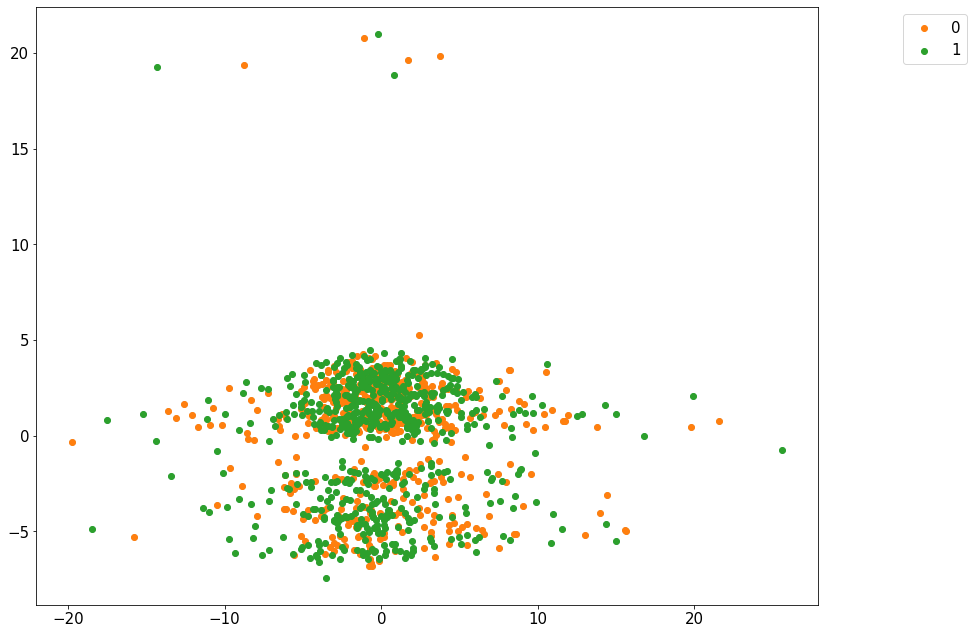

In [59]:
from sklearn import decomposition

pca = sklearn.decomposition.PCA()
pca_result = pca.fit_transform(X)

# Find the predictions from the PCA model, using just the first component
print(pca.mean_.shape, pca.components_.shape, pca_result.shape)

p1,p2 = pca_result[:,0], pca_result[:,1]

fig,ax = plt.subplots(figsize=(14,11))
ax.scatter(p1, p2, alpha=.2)

for lvl in set(nasdaq_train_y):
    i = (y == lvl)
    plt.scatter(p1[i], p2[i], label=lvl)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

Now let's see the 3 principal components:

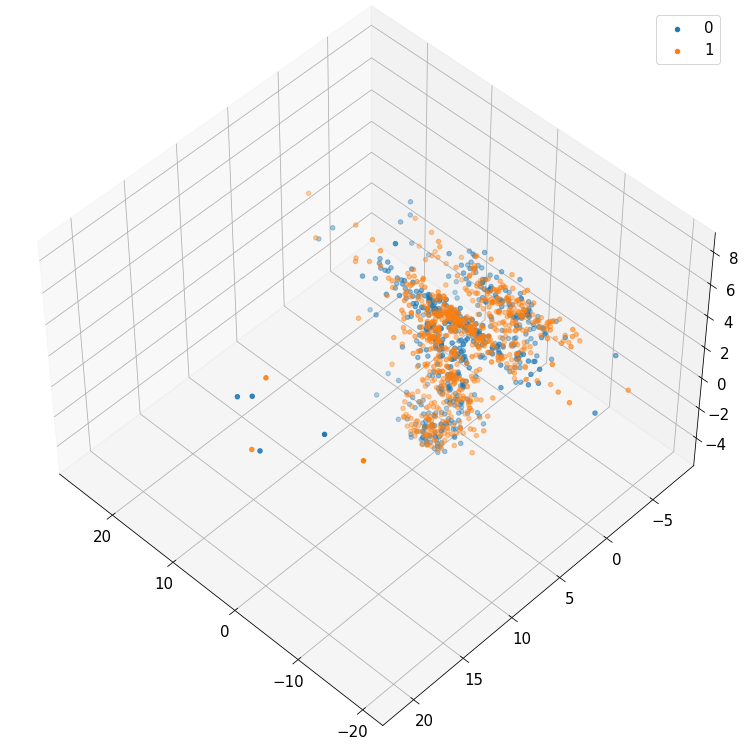

In [60]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1)
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

p1,p2, p3 = pca_result[:,0], pca_result[:,1], pca_result[:,2]

plt.cla()
for lvl in set(nasdaq_train_y):
    i = (y == lvl)
    ax.scatter(p1[i], p2[i], p3[i], label=lvl)
    ax.legend()


### Building a dataset from PCA

PCA can also be used to reduce the number of features before feedind the data to the machine learning algorthms.

In the following we build a dataset from the original one containg only the first 20 features selected by the PCA:

In [61]:
number_of_pca_features_to_keep = 20

In [62]:
pca_train = pca.fit_transform(nasdaq_train)[:,:number_of_pca_features_to_keep]
pca_val = pca.fit_transform(nasdaq_val)[:,:number_of_pca_features_to_keep]
pca_test = pca.fit_transform(nasdaq_test)[:,:number_of_pca_features_to_keep]

In [63]:
pca_train_X = series_to_supervised(pca_train, n, with_names=False)
pca_train_X = pca_train_X.values
pca_train_X_3D = pca_train_X.reshape(-1, n, pca_train.shape[1])

pca_train_X_3D.shape, nasdaq_train_y.shape

((1130, 60, 20), (1130,))

In [64]:
pca_val_X = series_to_supervised(pca_val, n, with_names=False)
pca_val_X = pca_val_X.values
pca_val_X_3D = pca_val_X.reshape(-1, n, pca_val.shape[1])

pca_val_X_3D.shape, nasdaq_val_y.shape

((338, 60, 20), (338,))

In [65]:
pca_test_X = series_to_supervised(pca_test, n, with_names=False)
pca_test_X = pca_test_X.values
pca_test_X_3D = pca_test_X.reshape(-1, n, pca_test.shape[1])

pca_test_X_3D.shape, nasdaq_test_y.shape

((338, 60, 20), (338,))

We can use this dataset as an alternative to the original one for the machine learning pipeline.

Unfortunately all of our trials of apllying the models to this dataset produced bad results, therefore I ended up not using the above created dataset.

The reason for the failure is that the features of our dataset are very particular and correlated and the principal components may not summarize the data very efficiently.

### t-SNE

Now we apply t-SNE to visualise the data. We put n_components=2.



In [66]:
from sklearn import manifold

tsne = sklearn.manifold.TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1189 samples in 0.005s...
[t-SNE] Computed neighbors for 1189 samples in 0.223s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1189
[t-SNE] Computed conditional probabilities for sample 1189 / 1189
[t-SNE] Mean sigma: 2.471885
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.576996
[t-SNE] KL divergence after 1000 iterations: 1.399016


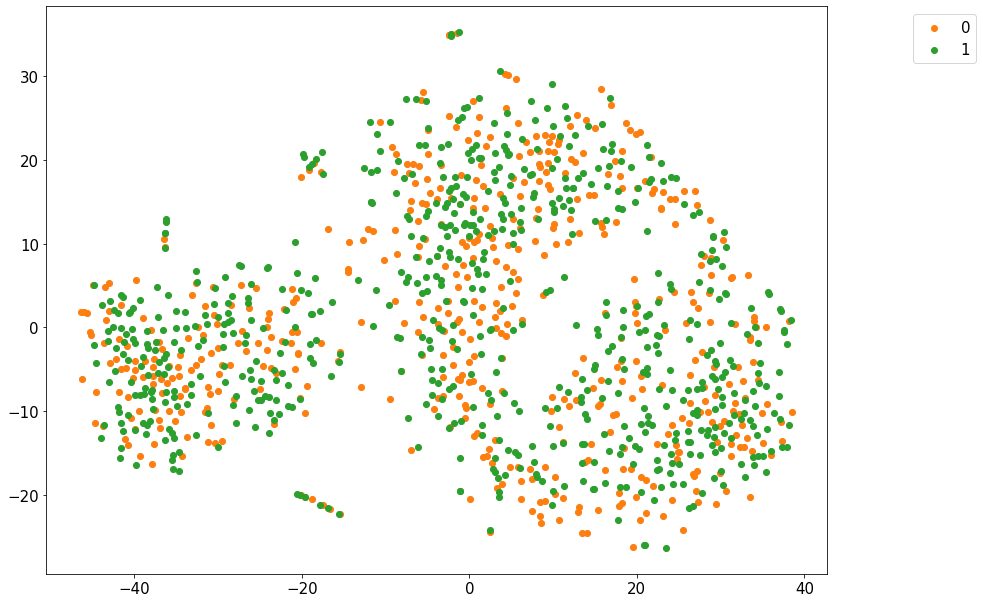

In [67]:
p1,p2 = tsne_results[:,0], tsne_results[:,1]

fig,ax = plt.subplots(figsize=(14,11))
ax.scatter(p1, p2, alpha=.2)
ax.set_aspect('equal')
for lvl in set(nasdaq_train_y):
    i = (y == lvl)
    plt.scatter(p1[i], p2[i], label=lvl)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

We now look at the different plots obtained by changing the perplexity:

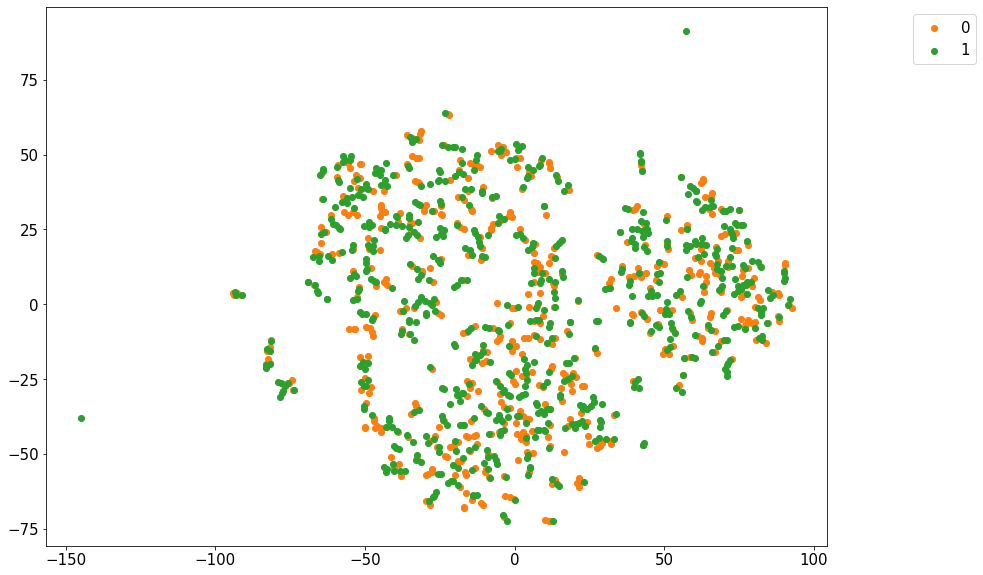

In [68]:
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=5)
tsne_results = tsne.fit_transform(X)

p1,p2 = tsne_results[:,0], tsne_results[:,1]

fig,ax = plt.subplots(figsize=(14,11))
ax.scatter(p1, p2, alpha=.2)
ax.set_aspect('equal')
for lvl in set(nasdaq_train_y):
    i = (y == lvl)
    plt.scatter(p1[i], p2[i], label=lvl)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

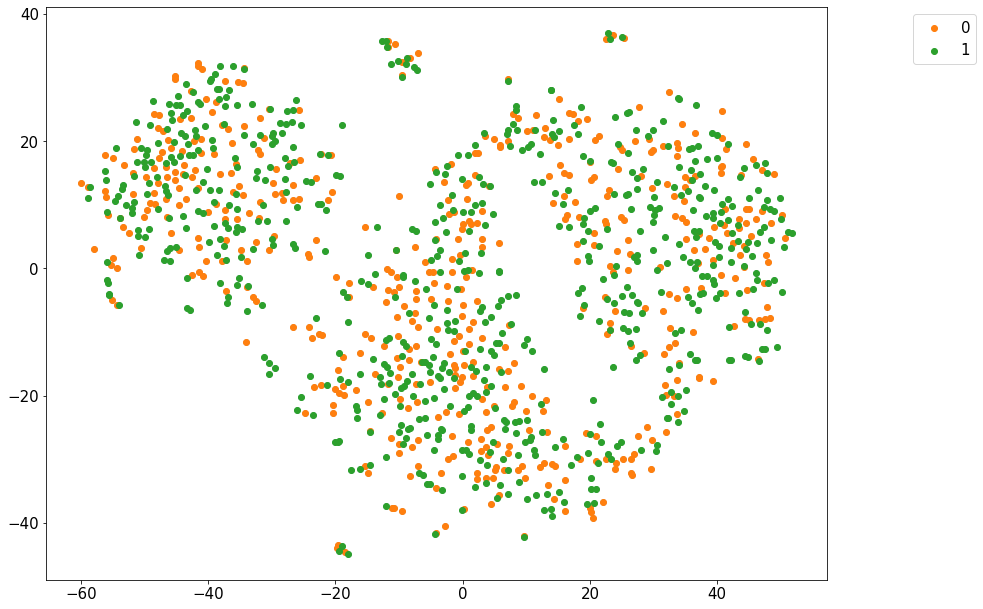

In [69]:
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=20)
tsne_results = tsne.fit_transform(X)

p1,p2 = tsne_results[:,0], tsne_results[:,1]

fig,ax = plt.subplots(figsize=(14,11))
ax.scatter(p1, p2, alpha=.2)
ax.set_aspect('equal')
for lvl in set(nasdaq_train_y):
    i = (y == lvl)
    plt.scatter(p1[i], p2[i], label=lvl)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

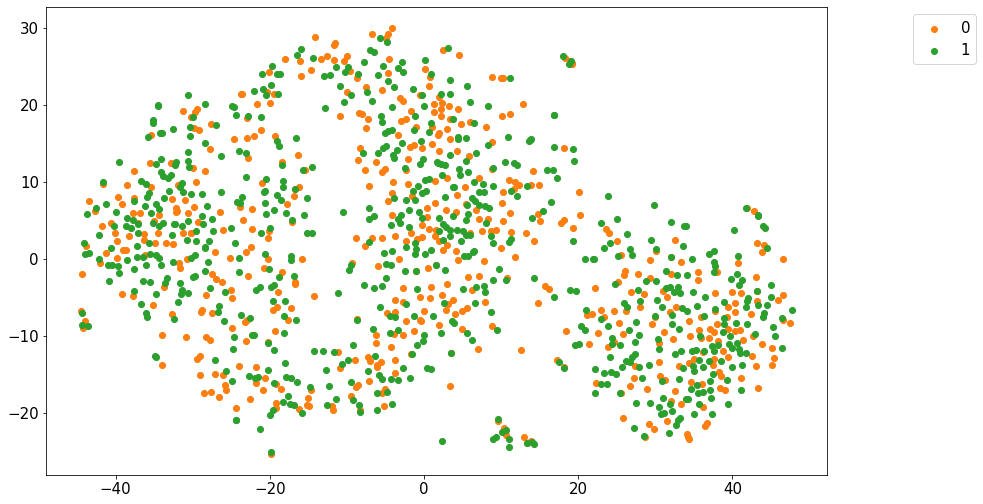

In [70]:
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=30)
tsne_results = tsne.fit_transform(X)

p1,p2 = tsne_results[:,0], tsne_results[:,1]

fig,ax = plt.subplots(figsize=(14,11))
ax.scatter(p1, p2, alpha=.2)
ax.set_aspect('equal')
for lvl in set(nasdaq_train_y):
    i = (y == lvl)
    plt.scatter(p1[i], p2[i], label=lvl)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

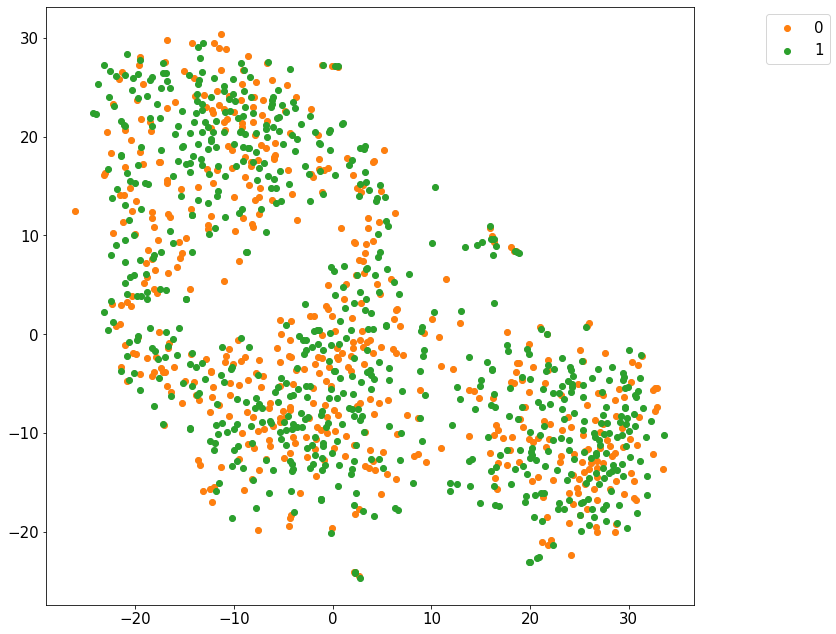

In [71]:
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=40)
tsne_results = tsne.fit_transform(X)

p1,p2 = tsne_results[:,0], tsne_results[:,1]

fig,ax = plt.subplots(figsize=(14,11))
ax.scatter(p1, p2, alpha=.2)
ax.set_aspect('equal')
for lvl in set(nasdaq_train_y):
    i = (y == lvl)
    plt.scatter(p1[i], p2[i], label=lvl)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

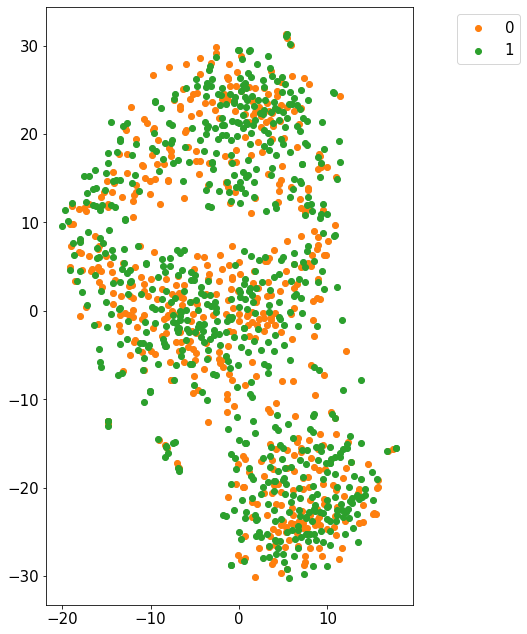

In [72]:
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=50)
tsne_results = tsne.fit_transform(X)

p1,p2 = tsne_results[:,0], tsne_results[:,1]

fig,ax = plt.subplots(figsize=(14,11))
ax.scatter(p1, p2, alpha=.2)
ax.set_aspect('equal')
for lvl in set(nasdaq_train_y):
    i = (y == lvl)
    plt.scatter(p1[i], p2[i], label=lvl)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

plt.show()

Lastly, we look at the 3 dimensional plot with perplexity equal to 30

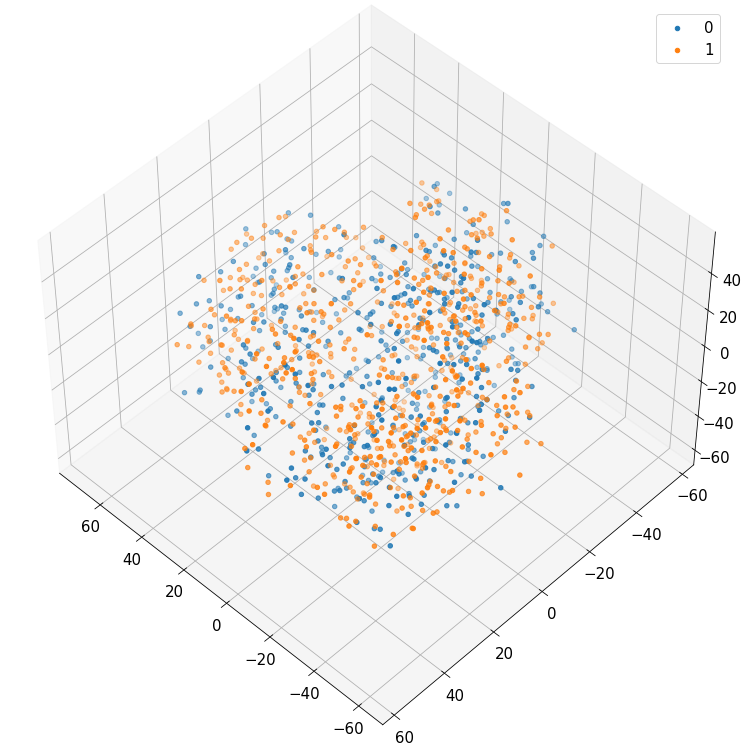

In [73]:
tsne = sklearn.manifold.TSNE(n_components=3, perplexity=30)
tsne_results = tsne.fit_transform(X)


fig = plt.figure(1)
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

p1,p2,p3 = tsne_results[:,0], tsne_results[:,1], tsne_results[:,2]

plt.cla()
for lvl in set(nasdaq_train_y):
    i = (y == lvl)
    ax.scatter(p1[i], p2[i], p3[i], label=lvl)
    ax.legend()

Visualisation with t-SNE seems not to be really useful for our dataset.

# Machine learning algorithms

Now we will apply some algorithms for supervised learning and, in particular, binary classification.

## Metrics

We will evaluate our models on the following metrics:


* *Accuracy* represents the proportion of correct classifications our model makes over all the samples. In order to maximise accuracy, you'll need to maximise on the number of true positives and true negatives.
$$
ACC = \frac{TP + TN}{TP + TN + FP + FN}
$$
 
* *Precision* measures how reliable or trustworthy your classifier is. It tells you how often when the classifier predicts that the stock market close price will increase in the next day (class $1$) it actually increases. It relies on the number of $TP$'s and $FP$'s:
$$
P = \frac{TP}{TP+FP}
$$

* *Recall* measures the coverage of your classifier. It tells you how many of the actual increases your classifier can detect at all. It relies on the number of $TP$'s and $FN$'s:
$$
R = \frac{TP}{TP+FN}
$$

* Finally, $F_1$*-score* combines the two measures above to give you an overall idea of your classifier's performance. $F_1$*-score* is estimated as follows:
$$
F_1 = 2 \times \frac{P \times R}{P+R}
$$


In the paper the authors select Macro-Averaged-$F_{1}$-Measure as their evaluation metric. This is equal to the unweighted mean of the $F_1$ scores between the two classes.

Their choice is guided by the fact that accuracy may be biased towards models that tend to predict the more frequent class.

We agree with this statement.

For this project we will use all the metrics above in their *weighted* version.
*Weighted* is  similar to macro, with the difference that the resulting metric is a weighted average of the metric for the two classes.

In particular the one we are more interested in is the Weighted-$F_1$-Score


To see how our models perform, we will also look into:

*   the *Confusion matrix*, that represents the number of $TP, TN, FP, FN$ in a matrix:

|                  | predicted class 0.  | predicted class 1.   |
|  -------------   |   :-------------:   |    :-------------:   |
| **actual class 0** | TN                  |   FP                 |
| **actual class 1** | FN                  |   TP                 |

*  the Receiver Operating Characteristic (ROC) (when possible to plot) that shows the true positive rate (TPR) against the false positive rate (FPR) at various discrimination thresholds.



To do this let's import the metrics utilities of sk-learn:

In [74]:
from sklearn.metrics import *

We also save the *Accuracy* and *Weighted-$F_1$-Score* for each model and for both validation and testing.

This will be used at the end to plot the performance of the models and compare them.

The same will be done for the testing on the NYSE test set

In [75]:
val_performance_acc = {}
val_performance_f1_weighted = {}

test_performance_acc = {}
test_performance_f1_weighted = {}

In [76]:
test_performance_acc_nyse = {}
test_performance_f1_weighted_nyse = {}

## Logistic regression

First let's train a logistic regressor.

The selected starting learning rate and the learning rate schedule have been chosen after a process of tuning by looking at the results given by the metrics on the validation set.

The starting learning rate is **0.4**

The learning rate schedule is **adaptive** ([see](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html))




In [77]:
from sklearn.linear_model import SGDClassifier

log_reg = SGDClassifier(max_iter=400, tol=None, random_state=42,
                        loss="log", eta0=0.4, learning_rate="adaptive", penalty=None, n_jobs=-1)

log_reg.fit(nasdaq_train_X, nasdaq_train_y)

SGDClassifier(eta0=0.4, learning_rate='adaptive', loss='log', max_iter=400,
              n_jobs=-1, penalty=None, random_state=42, tol=None)

Let's see what results it achieved on the training set.

In [78]:
pred_train = log_reg.predict(nasdaq_train_X)

confusion_matrix(nasdaq_train_y, pred_train)

array([[498,   0],
       [  0, 632]])

Cool! It was able to find a separation boundary that correctly classifies all the training instances.


<a name="cross_val"></a>

### Cross-validation

Now let's evaluate how well it generalises performing cross-validation.

Given the fact that our input is a time series, we cannot perform stratified K-fold or normal K-fold cross-validation, instead we can just split the time series incrementally (because test indieces must always be higher than training indices [see](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)).

The default number of splits is 5 and we will keep that.

For cross-validation we use the set containing both trianing and validation samples ([see](#train_val))

In [79]:
from sklearn.model_selection import TimeSeriesSplit, cross_validate

tscv = TimeSeriesSplit()
ts_split = tscv.split(nasdaq_train_val_X, nasdaq_train_val_y)

for i, [train_index, test_index] in enumerate(ts_split):
    print(f"GROUP N°{i+1}: NUM OF SAMPLES IN THE SETS-> TRAIN: {len(train_index)}, TEST: {len(test_index)}")

GROUP N°1: NUM OF SAMPLES IN THE SETS-> TRAIN: 257, TEST: 254
GROUP N°2: NUM OF SAMPLES IN THE SETS-> TRAIN: 511, TEST: 254
GROUP N°3: NUM OF SAMPLES IN THE SETS-> TRAIN: 765, TEST: 254
GROUP N°4: NUM OF SAMPLES IN THE SETS-> TRAIN: 1019, TEST: 254
GROUP N°5: NUM OF SAMPLES IN THE SETS-> TRAIN: 1273, TEST: 254


Now we perform cross-validation and we tell sklearn what metrics we want to evaluate



In [80]:
metrics = ["accuracy","precision_weighted","recall_weighted","f1_weighted"]

In [81]:
cross_val_result = cross_validate(log_reg, nasdaq_train_val_X, nasdaq_train_val_y, cv=tscv.split(nasdaq_train_val_X, nasdaq_train_val_y), scoring=metrics, n_jobs=-1)

Now let's compute the avarege value for the metrics across the 5 groups:

In [82]:
for i in cross_val_result:
    cross_val_result[i] = cross_val_result[i].mean()
cross_val_result

{'fit_time': 6.0727616310119625,
 'score_time': 0.009603357315063477,
 'test_accuracy': 0.49606299212598426,
 'test_precision_weighted': 0.5037011329728032,
 'test_recall_weighted': 0.49606299212598426,
 'test_f1_weighted': 0.49262109145107014}

We see that the result is not that good.

This is because this type of cross-validation is not as effective as stratified K-fold validation and because logistic regression may not be the best model for our task.

### Validation

Let's try evaluating the model on the validation set:

In [83]:
pred_val = log_reg.predict(nasdaq_val_X)

In [84]:
print(classification_report(nasdaq_val_y, pred_val, digits=4))

              precision    recall  f1-score   support

           0     0.5548    0.5062    0.5294       160
           1     0.5885    0.6348    0.6108       178

    accuracy                         0.5740       338
   macro avg     0.5717    0.5705    0.5701       338
weighted avg     0.5726    0.5740    0.5723       338



The lines of the ouput we are interested in are the one about accuracy and the last one containing the weighted metrics.

As we can see the result of this validation is better than the one we had for cross-validation. This is because cross-validation is not highly reliable for time series.

Let's also look at the confusion matrix:

In [85]:
confusion_matrix(nasdaq_val_y, pred_val)

array([[ 81,  79],
       [ 65, 113]])

And finally we plot also the ROC curve for our model.

To do this we calculate the classification scores for the instances of the validation set.

Note that we cannot use `cross_val_predict()` as it is not compatible with TimeSeries split for obvious reasons.

In [86]:
pred_val_scores = log_reg.decision_function(nasdaq_val_X)

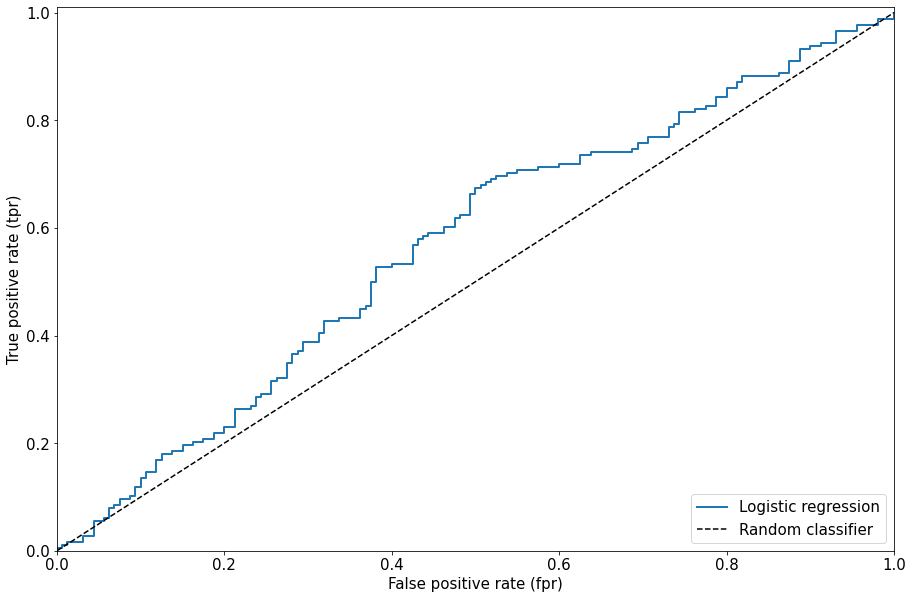

In [87]:
fpr_log_reg, tpr_log_reg, thresholds = roc_curve(nasdaq_val_y, pred_val_scores)

def plot_roc_curve(fpr, tpr, labels=None):
    for fpr_i, tpr_i, label_i in zip(fpr, tpr, labels):
        plt.plot(fpr_i, tpr_i, linewidth=2, label=label_i)
    plt.plot([0, 1], [0, 1], "k--", label="Random classifier")
    plt.axis([0, 1, 0, 1.01])
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    plt.legend(loc="lower right")
    
plot_roc_curve([fpr_log_reg], [tpr_log_reg], labels=["Logistic regression"])

Looking at the area underneath the curve we can see how well our model performs compared to the random classifier:

In [88]:
roc_auc_score(nasdaq_val_y, pred_val_scores)

0.5670294943820224

The more the area is grater than 0.5, the more our model performs better than random.

### Considerations

This model achieves a Weighted-$F_1$-Score of 0.5723 on the validation set.

The authors of the paper run their algorithm multiple times for comparison porpuses and obtain, for 2D-CNNPred, a Macro-Averaged-$F_{1}$-Measure mean of 0.4779, with a maximum value of 0.5219 on the NASDAQ dataset.

However their runs refer to the test set, for which we still don't know how this model will preform.

It is also to be kept in mind that 2D-CNNPred is trained using all the datasets, while our model considers only NASDAQ Composite.

We will not yet look at the performance of our models on the test set.
This wil be done only at the very end of the project after we select the best performing model based on the validation performances.

In [89]:
val_performance_acc['Log Reg'] = accuracy_score(nasdaq_val_y, pred_val)
val_performance_f1_weighted['Log Reg'] = f1_score(nasdaq_val_y, pred_val, average='weighted')

pred_test =  log_reg.predict(nasdaq_test_X)

test_performance_acc['Log Reg'] = accuracy_score(nasdaq_test_y, pred_test)
test_performance_f1_weighted['Log Reg'] = f1_score(nasdaq_test_y, pred_test, average='weighted')

pred_test_nyse =  log_reg.predict(nyse_test_X)

test_performance_acc_nyse['Log Reg'] = accuracy_score(nyse_test_y, pred_test_nyse)
test_performance_f1_weighted_nyse['Log Reg'] = f1_score(nyse_test_y, pred_test_nyse, average='weighted')

## Ensemble hard voting

Now we try to use an ensemble of 4 classifiers, the used classifiers are:

*   Gaussian Naive Bayes (we infer the prior of the classes directly from the data)
*   Logistic Regression (the one that we just used)
*   Perceptron
*   Support Vector Machine

We use hard voting as the SGD classifier used to model the perceptron does not provide probability estimates.

In [90]:
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB


gnb_clf = GaussianNB()
log_clf = SGDClassifier(max_iter=400, tol=None, random_state=42,
                        loss="log", eta0=0.4, learning_rate="adaptive", penalty=None, n_jobs=-1)
perc_clf = SGDClassifier(max_iter=400, tol=None, random_state=42,
                   loss="perceptron", eta0=1, learning_rate="constant", penalty=None, n_jobs=-1)
svm_clf = SVC(random_state=42, probability=True)

voting_clf = VotingClassifier(
    estimators=[('gnb', gnb_clf), ('log', log_clf), ('perc', perc_clf), ('svm',svm_clf)],
    voting='hard')

Let's now see the evaluation metrics on each single classifier and on the voting classifier.

In [91]:
for clf in (gnb_clf, log_clf, perc_clf, svm_clf, voting_clf):
    clf.fit(nasdaq_train_X, nasdaq_train_y)
    pred_val = clf.predict(nasdaq_val_X)
    print(clf.__class__.__name__, '\n', classification_report(nasdaq_val_y, pred_val, digits=3))

GaussianNB 
               precision    recall  f1-score   support

           0      0.469     0.431     0.450       160
           1      0.524     0.562     0.542       178

    accuracy                          0.500       338
   macro avg      0.496     0.497     0.496       338
weighted avg      0.498     0.500     0.498       338

SGDClassifier 
               precision    recall  f1-score   support

           0      0.555     0.506     0.529       160
           1      0.589     0.635     0.611       178

    accuracy                          0.574       338
   macro avg      0.572     0.571     0.570       338
weighted avg      0.573     0.574     0.572       338

SGDClassifier 
               precision    recall  f1-score   support

           0      0.542     0.487     0.513       160
           1      0.577     0.629     0.602       178

    accuracy                          0.562       338
   macro avg      0.559     0.558     0.558       338
weighted avg      0.560     0

We can see that singularly SVM and Naive Bayes do nat perform very good, but in the ensemble with the Logistic Regresssion and the Perceptron (which we see performing slightly better) they provide surprising results.

Although it is hard to train the models in a way that they provide uncorrelated errors, the result we obtain with this method is an improvement with respect to the Logistic Regression classifier (treated in the previous section) alone.

The voting classifier achieves perfect results on the training set.

In [92]:
pred_train = voting_clf.predict(nasdaq_train_X)

confusion_matrix(nasdaq_train_y, pred_train)

array([[498,   0],
       [  0, 632]])

### Cross-validation

Now let's evaluate how well it generalises performing cross-validation (details on this have been given in [this section](#cross_val)).

In [93]:
cross_val_result = cross_validate(voting_clf, nasdaq_train_val_X, nasdaq_train_val_y, cv=tscv.split(nasdaq_train_val_X, nasdaq_train_val_y), scoring=metrics, n_jobs=-1)

Now let's compute the avarege value for the metrics across the 5 groups:

In [94]:
for i in cross_val_result:
    cross_val_result[i] = cross_val_result[i].mean()
cross_val_result

{'fit_time': 31.005366468429564,
 'score_time': 1.2555941581726073,
 'test_accuracy': 0.4984251968503937,
 'test_precision_weighted': 0.5070726555536382,
 'test_recall_weighted': 0.4984251968503937,
 'test_f1_weighted': 0.4930030936228465}

We see that the result is not that good.

This is because this type of cross-validation is not as effective as stratified K-fold validation.

### Validation

Let's try evaluating the model on the validation set:

In [95]:
pred_val = voting_clf.predict(nasdaq_val_X)

In [96]:
print(classification_report(nasdaq_val_y, pred_val, digits=4))

              precision    recall  f1-score   support

           0     0.5816    0.5125    0.5449       160
           1     0.6041    0.6685    0.6347       178

    accuracy                         0.5947       338
   macro avg     0.5928    0.5905    0.5898       338
weighted avg     0.5934    0.5947    0.5922       338



The lines of the ouput we are interested in are the one about accuracy and the last one containing the weighted metrics.

As we can see the result of this validation is better than the one we had for cross-validation. This is because cross-validation is not highly reliable for time series.

Let's also look at the confusion matrix:

In [97]:
confusion_matrix(nasdaq_val_y, pred_val)

array([[ 82,  78],
       [ 59, 119]])

We cannot loo at the ROC Curve as the classifier uses hard voting and therefore doesn't output the probability of the predictions.

### Considerations

This model achieves a Weighted-$F_1$-Score of 0.592 on the validation set, which is better than the result achieved by Logistic Regression alone.

We will not yet look at the performance of our models on the test set.
This wil be done only at the very end of the project after we select the best performing model based on the validation performances.

In [98]:
val_performance_acc['Voting Clf'] = accuracy_score(nasdaq_val_y, pred_val)
val_performance_f1_weighted['Voting Clf'] = f1_score(nasdaq_val_y, pred_val, average='weighted')

pred_test =  voting_clf.predict(nasdaq_test_X)

test_performance_acc['Voting Clf'] = accuracy_score(nasdaq_test_y, pred_test)
test_performance_f1_weighted['Voting Clf'] = f1_score(nasdaq_test_y, pred_test, average='weighted')

pred_test_nyse =  voting_clf.predict(nyse_test_X)

test_performance_acc_nyse['Voting Clf'] = accuracy_score(nyse_test_y, pred_test_nyse)
test_performance_f1_weighted_nyse['Voting Clf'] = f1_score(nyse_test_y, pred_test_nyse, average='weighted')

## Neural networks

This is the function we will use to compule and fit our neuarl networks.

It uses early stopping, which means that the training will stop as soon as the validation loss starts to increase. The patience for early stopping is chosen by the user.

The default optimizer used is Adam.

The function gives to the user the possibility to add a dimension to the data (that is used for 3D CNNs).

It also gives the optiption to choose between binary cross-entropy or sparse categorical cross-entropy depending on the last layer of the network used for classification.

The default batch size is 32.

The user can also choose to train and validate the model on the smaller sets obtained using PCA. This option was investigated and evaluations showed that using PCA's features do not introduce major benefits to the training time, while they reduce a lot the accuracy of the models.

Finally the evaluation metric is the accuracy.


In [99]:
MAX_EPOCHS = 20

def compile_and_fit(model, patience=2, add_dim=False, use_sparse=False, batch_size=32, optimizer=tf.keras.optimizers.Adam(), pca_set=False):

    tf.keras.backend.clear_session()

    if pca_set:
        train_set = pca_train_X_3D
        val_set = pca_val_X_3D
    else:
        train_set = nasdaq_train_X_3D
        val_set = nasdaq_val_X_3D

    if add_dim:
        train_set = train_set[:,:,:,np.newaxis]
        val_set = val_set[:,:,:,np.newaxis]
   


    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='auto')


    loss = tf.losses.SparseCategoricalCrossentropy() if use_sparse else tf.losses.BinaryCrossentropy()

    model.compile(loss=loss,
                optimizer=optimizer,
                metrics=['accuracy'])

    history = model.fit(train_set, nasdaq_train_y, 
                        epochs=MAX_EPOCHS,
                        validation_data=(val_set, nasdaq_val_y),
                        callbacks=[early_stopping],
                        batch_size=batch_size)
        
    return history

## 2D-CNNPred

In this section we try to recreate the 2D-CNNPred model from the paepr.

Given the great amount of information that is missing in the paper, some parameters have been chosen by me.

To measure the loss we use `BinaryCrossEntropy()` and we use early stopping on the validation loss with a patience of 4.


In the first part of the next cell we can see the architecture of the network.

We create and train 20 models. For each model we compute: accuracy, weighted precision, weighted recall and weigthed f1 on the validation set and on the test set. We perform 20 runs to obtain a fair evaluation of the architeture performance, factoring out the stochasticity introduced by the random initialisation of the weights.

At the end of all the training we take the mean of each metric among the 20 models. We will use this for the final comparison.

In [100]:
validation_2d_cnn_pred = {'accuracy' : [], 'precision' : [], 'recall' : [], 'f1' : []}
test_2d_cnn_pred = {'accuracy' : [], 'precision' : [], 'recall' : [], 'f1' : []}
nyse_test_2d_cnn_pred = {'accuracy' : [], 'precision' : [], 'recall' : [], 'f1' : []}


for i in range(20):

    print(f'\nTraining model number {i+1} of 20\n')

    cnn2d_pred_model = keras.models.Sequential([
        keras.layers.Conv2D(filters=8, kernel_size=(1,83), input_shape=[60, 83, 1], activation='relu'),
        keras.layers.Dropout(rate=0.1),
        keras.layers.Conv2D(filters=8, kernel_size=(3,1), activation='relu'),
        keras.layers.Dropout(rate=0.1),
        keras.layers.MaxPooling2D(pool_size=(2,1)),
        keras.layers.Conv2D(filters=8, kernel_size=(3,1), activation='relu'),
        keras.layers.Dropout(rate=0.1),
        keras.layers.MaxPooling2D(pool_size=(2,1)),
        keras.layers.Flatten(),
        keras.layers.Dense(units=1, activation='sigmoid')
    ])

    history = compile_and_fit(cnn2d_pred_model, add_dim=True, batch_size=128, patience=4)

    pred_val = np.where(cnn2d_pred_model.predict(nasdaq_val_X_3D[:,:,:,np.newaxis]) > 0.5, 1, 0)
    report = classification_report(nasdaq_val_y, pred_val, digits=4, output_dict=True)

    validation_2d_cnn_pred['accuracy'].append(report['accuracy'])
    validation_2d_cnn_pred['precision'].append(report['weighted avg']['precision'])
    validation_2d_cnn_pred['recall'].append(report['weighted avg']['recall'])
    validation_2d_cnn_pred['f1'].append(report['weighted avg']['f1-score'])

    pred_test = np.where(cnn2d_pred_model.predict(nasdaq_test_X_3D[:,:,:,np.newaxis]) > 0.5, 1, 0)
    report = classification_report(nasdaq_test_y, pred_test, digits=4, output_dict=True)

    test_2d_cnn_pred['accuracy'].append(report['accuracy'])
    test_2d_cnn_pred['precision'].append(report['weighted avg']['precision'])
    test_2d_cnn_pred['recall'].append(report['weighted avg']['recall'])
    test_2d_cnn_pred['f1'].append(report['weighted avg']['f1-score'])

    pred_test_nyse =  np.where(cnn2d_pred_model.predict(nyse_test_X_3D[:,:,:,np.newaxis]) > 0.5, 1, 0)
    report = classification_report(nyse_test_y, pred_test_nyse, digits=4, output_dict=True)

    nyse_test_2d_cnn_pred['accuracy'].append(report['accuracy'])
    nyse_test_2d_cnn_pred['precision'].append(report['weighted avg']['precision'])
    nyse_test_2d_cnn_pred['recall'].append(report['weighted avg']['recall'])
    nyse_test_2d_cnn_pred['f1'].append(report['weighted avg']['f1-score'])


Training model number 1 of 20

Epoch 1/20
9/9 [==============================] - 0s 35ms/step - loss: 0.6955 - accuracy: 0.5053 - val_loss: 0.6996 - val_accuracy: 0.4970
Epoch 2/20
9/9 [==============================] - 0s 15ms/step - loss: 0.6918 - accuracy: 0.5451 - val_loss: 0.7006 - val_accuracy: 0.5148
Epoch 3/20
9/9 [==============================] - 0s 13ms/step - loss: 0.6898 - accuracy: 0.5336 - val_loss: 0.6984 - val_accuracy: 0.5178
Epoch 4/20
9/9 [==============================] - 0s 13ms/step - loss: 0.6818 - accuracy: 0.5619 - val_loss: 0.6965 - val_accuracy: 0.5148
Epoch 5/20
9/9 [==============================] - 0s 14ms/step - loss: 0.6826 - accuracy: 0.5558 - val_loss: 0.6961 - val_accuracy: 0.5178
Epoch 6/20
9/9 [==============================] - 0s 14ms/step - loss: 0.6795 - accuracy: 0.5646 - val_loss: 0.6962 - val_accuracy: 0.5207
Epoch 7/20
9/9 [==============================] - 0s 14ms/step - loss: 0.6760 - accuracy: 0.5690 - val_loss: 0.6956 - val_accuracy: 0.

9/9 [==============================] - 0s 22ms/step - loss: 0.6923 - accuracy: 0.5558 - val_loss: 0.6941 - val_accuracy: 0.5296
Epoch 3/20
9/9 [==============================] - 0s 21ms/step - loss: 0.6830 - accuracy: 0.5646 - val_loss: 0.6909 - val_accuracy: 0.5148
Epoch 4/20
9/9 [==============================] - 0s 21ms/step - loss: 0.6787 - accuracy: 0.5761 - val_loss: 0.6911 - val_accuracy: 0.5059
Epoch 5/20
9/9 [==============================] - 0s 23ms/step - loss: 0.6779 - accuracy: 0.5655 - val_loss: 0.6917 - val_accuracy: 0.5266
Epoch 6/20
9/9 [==============================] - 0s 21ms/step - loss: 0.6726 - accuracy: 0.5619 - val_loss: 0.6917 - val_accuracy: 0.5325
Epoch 7/20
9/9 [==============================] - 0s 20ms/step - loss: 0.6682 - accuracy: 0.5858 - val_loss: 0.6900 - val_accuracy: 0.5414
Epoch 8/20
9/9 [==============================] - 0s 22ms/step - loss: 0.6679 - accuracy: 0.5850 - val_loss: 0.6907 - val_accuracy: 0.5385
Epoch 9/20
9/9 [======================

9/9 [==============================] - 0s 14ms/step - loss: 0.6699 - accuracy: 0.5912 - val_loss: 0.6986 - val_accuracy: 0.5533
Epoch 6/20
9/9 [==============================] - 0s 13ms/step - loss: 0.6623 - accuracy: 0.5965 - val_loss: 0.6998 - val_accuracy: 0.5237

Training model number 15 of 20

Epoch 1/20
9/9 [==============================] - 0s 28ms/step - loss: 0.7008 - accuracy: 0.5062 - val_loss: 0.6989 - val_accuracy: 0.5266
Epoch 2/20
9/9 [==============================] - 0s 12ms/step - loss: 0.6893 - accuracy: 0.5593 - val_loss: 0.6965 - val_accuracy: 0.5266
Epoch 3/20
9/9 [==============================] - 0s 13ms/step - loss: 0.6797 - accuracy: 0.5619 - val_loss: 0.6919 - val_accuracy: 0.5237
Epoch 4/20
9/9 [==============================] - 0s 16ms/step - loss: 0.6762 - accuracy: 0.5770 - val_loss: 0.6923 - val_accuracy: 0.5296
Epoch 5/20
9/9 [==============================] - 0s 15ms/step - loss: 0.6753 - accuracy: 0.5681 - val_loss: 0.6940 - val_accuracy: 0.5296
Epoch

In [101]:
validation_2d_cnn_pred['average'] = {}
validation_2d_cnn_pred['average']['accuarcy'] = np.mean(validation_2d_cnn_pred['accuracy'])
validation_2d_cnn_pred['average']['precision'] = np.mean(validation_2d_cnn_pred['precision'])
validation_2d_cnn_pred['average']['recall'] = np.mean(validation_2d_cnn_pred['recall'])
validation_2d_cnn_pred['average']['f1'] = np.mean(validation_2d_cnn_pred['f1'])


val_performance_acc['2D-CNNPred'] = validation_2d_cnn_pred['average']['accuarcy']
val_performance_f1_weighted['2D-CNNPred'] = validation_2d_cnn_pred['average']['f1']

In [102]:
test_2d_cnn_pred['average'] = {}
test_2d_cnn_pred['average']['accuarcy'] = np.mean(test_2d_cnn_pred['accuracy'])
test_2d_cnn_pred['average']['precision'] = np.mean(test_2d_cnn_pred['precision'])
test_2d_cnn_pred['average']['recall'] = np.mean(test_2d_cnn_pred['recall'])
test_2d_cnn_pred['average']['f1'] = np.mean(test_2d_cnn_pred['f1'])


test_performance_acc['2D-CNNPred'] = test_2d_cnn_pred['average']['accuarcy']
test_performance_f1_weighted['2D-CNNPred'] = test_2d_cnn_pred['average']['f1']

In [103]:
nyse_test_2d_cnn_pred['average'] = {}
nyse_test_2d_cnn_pred['average']['accuarcy'] = np.mean(nyse_test_2d_cnn_pred['accuracy'])
nyse_test_2d_cnn_pred['average']['precision'] = np.mean(nyse_test_2d_cnn_pred['precision'])
nyse_test_2d_cnn_pred['average']['recall'] = np.mean(nyse_test_2d_cnn_pred['recall'])
nyse_test_2d_cnn_pred['average']['f1'] = np.mean(nyse_test_2d_cnn_pred['f1'])

test_performance_acc_nyse['2D-CNNPred'] = nyse_test_2d_cnn_pred['average']['accuarcy']
test_performance_f1_weighted_nyse['2D-CNNPred'] = nyse_test_2d_cnn_pred['average']['f1']

The results just computed over the 20 models will be used later for comparison between different models.

Now, we look into one particular model to go more insights. For this purpose, we load a model that achieved good results. 

If you do not want to use this model just comment the next cell and you will automatically use the last model trained in the set of 20.

In [104]:
cnn2d_pred_model = tf.keras.models.load_model(cnn_pred_uri)

Now we evaluate the model on the validation set:

In [105]:
score = cnn2d_pred_model.evaluate(nasdaq_val_X_3D[:,:,:,np.newaxis], nasdaq_val_y)
score

11/11 [==============================] - 0s 2ms/step - loss: 0.6859 - accuracy: 0.5533


[0.6858754754066467, 0.5532544255256653]

In [106]:
pred_val = np.where(cnn2d_pred_model.predict(nasdaq_val_X_3D[:,:,:,np.newaxis]) > 0.5, 1, 0)
print(classification_report(nasdaq_val_y, pred_val, digits=4))

              precision    recall  f1-score   support

           0     0.5413    0.3688    0.4387       160
           1     0.5590    0.7191    0.6290       178

    accuracy                         0.5533       338
   macro avg     0.5501    0.5439    0.5338       338
weighted avg     0.5506    0.5533    0.5389       338



The confusion matrix:

In [107]:
confusion_matrix(nasdaq_val_y, pred_val)

array([[ 59, 101],
       [ 50, 128]])

The ROC curve:

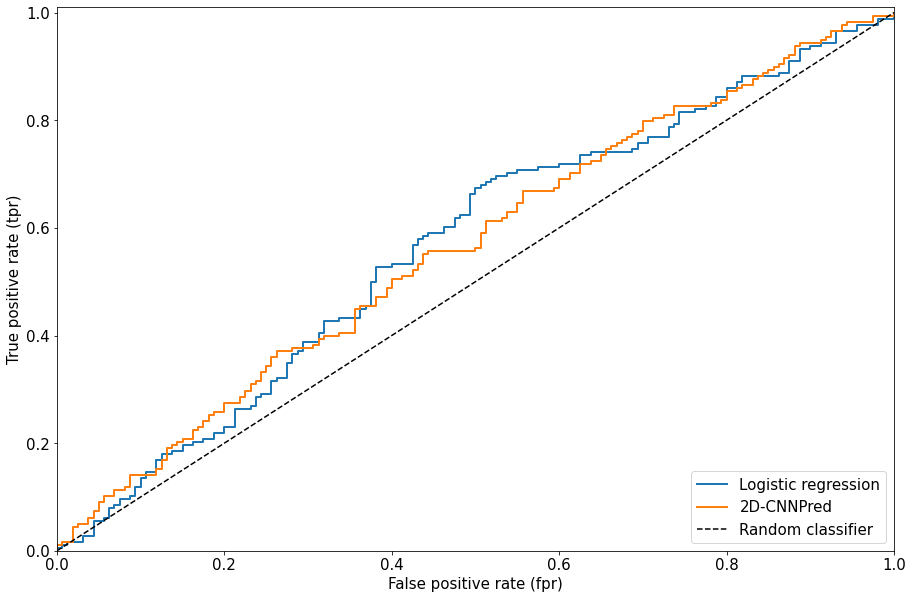

In [108]:
pred_val_probs = cnn2d_pred_model.predict(nasdaq_val_X_3D[:,:,:,np.newaxis])
fpr_2d_cnnpred, tpr_2d_cnnpred, thresholds = roc_curve(nasdaq_val_y, pred_val_probs)

    
plot_roc_curve([fpr_log_reg, fpr_2d_cnnpred], [tpr_log_reg, tpr_2d_cnnpred], labels=["Logistic regression","2D-CNNPred"])

Looking at the area underneath the curve we can see how well our model performs compared to the random classifier:

In [109]:
roc_auc_score(nasdaq_val_y, pred_val_probs)

0.5635884831460674

It seems to be way worse compared to the other models, but remember, we still haven't looked at the test set.

Let's see a graphical visualization of the network:

In [110]:
tf.keras.utils.plot_model(cnn2d_pred_model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


And a plot of the loss and accuracy:

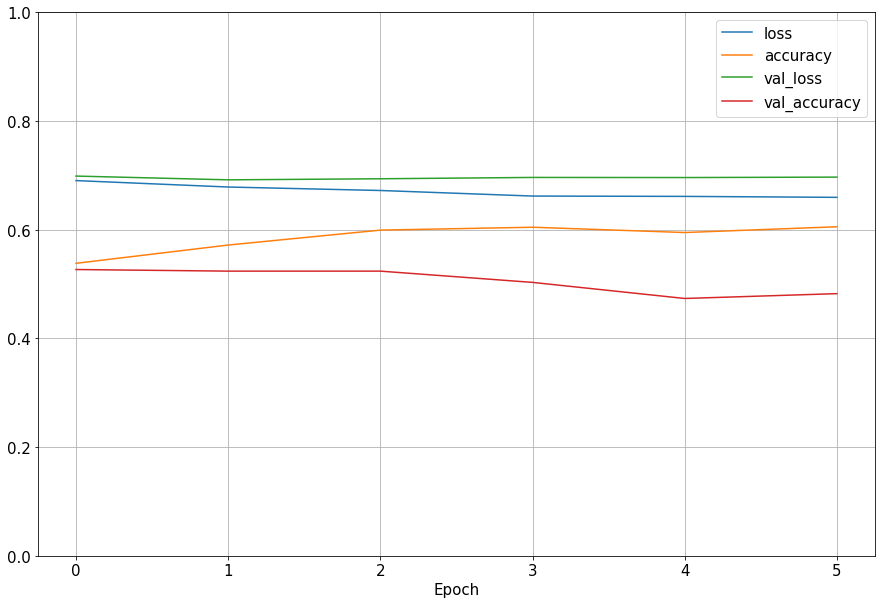

In [111]:
def plot_history(history):
    pd.DataFrame(history.history).plot()
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.gca().set_xlabel("Epoch")
    plt.show()

plot_history(history)

## LSTM

Long-Short-Term memory cells are able to learn what to remember and what to forget from previously seen data.

For this reason it seems reasonable to apply them to time series prediction. As they will be able to model the correlations in the time series and predict the next step.

The LSTM layer is fed a $n*83$ vector, with $n$ the number of days.

It analyses incrementally day by day and provides one output.

In our scenario we want to output just the prediction at the last time step so we set `return_sequences` to `False`.

The output in this case is a vector containing the probabilities of classes 0 and 1. Therefore the loss function used will be `SparseCategoricalCrossentropy`.

 



### Hyperparams search

For this model we perform hyperparameter grid search using the *hparams* plugin of tensorboard.

A first pass of hyperparameters selection has shown that SGD was the best optimizer for this model.

In the second pass, reported in this section, we are investigating the number of LSTM units in the LSTM layer and the learning rate for SGD.

The chosen interval to investigate for the learning rate is (0.01, 0.1) as values in this range have been found to provide the highest performance.

First we set the hyperparameters in which we are interested and their domains:

In [112]:
!rm -rf ./logs

HP_NUM_UNITS_LSTM = hp.HParam('num_units_lstm', hp.IntInterval(1,200))
HP_LEARNING_RATE = hp.HParam('alpha', hp.RealInterval(0.01, 0.1))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_LSTM, HP_LEARNING_RATE],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

Then we define a function for training the model that is parametric in the hyperparameters and interacts with tensorboard through two callbacks.

This function is very similar to the genear purpose `compile_and_fit` function defined above, but contains the network layers definition inside and also performs evaluation outputting the accuracy achieved on the validation set.

In [113]:
def auto_compile_and_fit(hparams, hparam_dir, patience=2, add_dim=False, use_sparse=True, batch_size=32):

    tf.keras.backend.clear_session()

    lstm_model = tf.keras.models.Sequential([                                  
        tf.keras.layers.LSTM(hparams[HP_NUM_UNITS_LSTM], return_sequences=False),
        tf.keras.layers.Dense(units=2, activation='softmax')
    ])

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=hparam_dir, histogram_freq=1)


    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=patience,
                                                mode='auto')

    loss = tf.losses.SparseCategoricalCrossentropy() if use_sparse else tf.losses.BinaryCrossentropy()

    lstm_model.compile(loss=loss,
                optimizer=tf.keras.optimizers.SGD(learning_rate=hparams[HP_LEARNING_RATE]),
                metrics=['accuracy'])

    history = lstm_model.fit(nasdaq_train_X_3D, nasdaq_train_y, 
                        epochs=MAX_EPOCHS,
                        validation_data=(nasdaq_val_X_3D, nasdaq_val_y),
                        callbacks=[tensorboard_callback, # log metrics
                                    hp.KerasCallback(hparam_dir, hparams),
                                    early_stopping],
                        batch_size=batch_size)
    
    _, accuracy = lstm_model.evaluate(nasdaq_val_X_3D, nasdaq_val_y)
        
    return accuracy

Then, for each hyperparameter that we are interested in, we perform the grid search. Writing the resulting accuracy in the logs file.

This process takes a lot of time. To perform it just uncomment the following cell.

In [114]:
'''
session_num = 0

for learning_rate in np.arange(HP_LEARNING_RATE.domain.min_value, HP_LEARNING_RATE.domain.max_value, 0.02):
    for num_units_lstm in np.arange(HP_NUM_UNITS_LSTM.domain.min_value, HP_NUM_UNITS_LSTM.domain.max_value, 30):
        hparams = {
            HP_LEARNING_RATE: learning_rate,
            HP_NUM_UNITS_LSTM: num_units_lstm
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run_dir = 'logs/hparam_tuning/' + run_name

        with tf.summary.create_file_writer(run_dir).as_default():
            accuracy = auto_compile_and_fit(hparams, hparam_dir=run_dir)
            tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
        session_num += 1

'''

'\nsession_num = 0\n\nfor learning_rate in np.arange(HP_LEARNING_RATE.domain.min_value, HP_LEARNING_RATE.domain.max_value, 0.02):\n    for num_units_lstm in np.arange(HP_NUM_UNITS_LSTM.domain.min_value, HP_NUM_UNITS_LSTM.domain.max_value, 30):\n        hparams = {\n            HP_LEARNING_RATE: learning_rate,\n            HP_NUM_UNITS_LSTM: num_units_lstm\n        }\n        run_name = "run-%d" % session_num\n        print(\'--- Starting trial: %s\' % run_name)\n        print({h.name: hparams[h] for h in hparams})\n        run_dir = \'logs/hparam_tuning/\' + run_name\n\n        with tf.summary.create_file_writer(run_dir).as_default():\n            accuracy = auto_compile_and_fit(hparams, hparam_dir=run_dir)\n            tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)\n        session_num += 1\n\n'

After the search is finished, we are able to visualize in tensorboard the hyperparameters that provide the best results.

In our case these are:

*   61 LSTM cells
*   0.08 as learning rate for SGD

In [115]:
%tensorboard --logdir logs/hparam_tuning/

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

### Selected model

In the first part of the next cell we can see the architecture of the network with the chosen hyperparameters.

We create and train 20 models. For each model we compute: accuracy, weighted precision, weighted recall and weigthed f1 on the validation set and on the test set. We perform 20 runs to obtain a fair evaluation of the architeture performance, factoring out the stochasticity introduced by the random initialisation of the weights.

At the end of all the training we take the mean of each metric among the 20 models. We will use this for the final comparison.

In [116]:
validation_lstm = {'accuracy' : [], 'precision' : [], 'recall' : [], 'f1' : []}
test_lstm = {'accuracy' : [], 'precision' : [], 'recall' : [], 'f1' : []}
nyse_test_lstm = {'accuracy' : [], 'precision' : [], 'recall' : [], 'f1' : []}

for i in range(20):

    print(f'\nTraining model number {i+1} of 20\n')

    lstm_model = tf.keras.models.Sequential([                                  
        # Shape [batch, days, features] => [batch, lstm_units]
        tf.keras.layers.LSTM(61, return_sequences=False),
        tf.keras.layers.Dense(units=2, activation='softmax')
    ])

    history = compile_and_fit(lstm_model, use_sparse=True, optimizer=tf.keras.optimizers.SGD(learning_rate=0.08))

    pred_val = tf.argmax(lstm_model.predict(nasdaq_val_X_3D), axis=1)
    report = classification_report(nasdaq_val_y, pred_val, digits=4, output_dict=True)

    validation_lstm['accuracy'].append(report['accuracy'])
    validation_lstm['precision'].append(report['weighted avg']['precision'])
    validation_lstm['recall'].append(report['weighted avg']['recall'])
    validation_lstm['f1'].append(report['weighted avg']['f1-score'])

    pred_test = tf.argmax(lstm_model.predict(nasdaq_test_X_3D), axis=1)
    report = classification_report(nasdaq_test_y, pred_test, digits=4, output_dict=True)

    test_lstm['accuracy'].append(report['accuracy'])
    test_lstm['precision'].append(report['weighted avg']['precision'])
    test_lstm['recall'].append(report['weighted avg']['recall'])
    test_lstm['f1'].append(report['weighted avg']['f1-score'])

    pred_test_nyse = tf.argmax(lstm_model.predict(nyse_test_X_3D), axis=1)
    report = classification_report(nyse_test_y, pred_test_nyse, digits=4, output_dict=True)

    nyse_test_lstm['accuracy'].append(report['accuracy'])
    nyse_test_lstm['precision'].append(report['weighted avg']['precision'])
    nyse_test_lstm['recall'].append(report['weighted avg']['recall'])
    nyse_test_lstm['f1'].append(report['weighted avg']['f1-score'])




Training model number 1 of 20

Epoch 1/20
36/36 [==============================] - 2s 53ms/step - loss: 0.7089 - accuracy: 0.5133 - val_loss: 0.7214 - val_accuracy: 0.4941
Epoch 2/20
36/36 [==============================] - 1s 34ms/step - loss: 0.6887 - accuracy: 0.5602 - val_loss: 0.7041 - val_accuracy: 0.5059
Epoch 3/20
36/36 [==============================] - 1s 34ms/step - loss: 0.6770 - accuracy: 0.5796 - val_loss: 0.7045 - val_accuracy: 0.5059
Epoch 4/20
36/36 [==============================] - 1s 37ms/step - loss: 0.6672 - accuracy: 0.5894 - val_loss: 0.7017 - val_accuracy: 0.5237
Epoch 5/20
36/36 [==============================] - 1s 40ms/step - loss: 0.6570 - accuracy: 0.6088 - val_loss: 0.6922 - val_accuracy: 0.5740
Epoch 6/20
36/36 [==============================] - 1s 34ms/step - loss: 0.6480 - accuracy: 0.6195 - val_loss: 0.6856 - val_accuracy: 0.5710
Epoch 7/20
36/36 [==============================] - 1s 34ms/step - loss: 0.6385 - accuracy: 0.6319 - val_loss: 0.7077 - va

36/36 [==============================] - 1s 35ms/step - loss: 0.6844 - accuracy: 0.5434 - val_loss: 0.6934 - val_accuracy: 0.5473
Epoch 3/20
36/36 [==============================] - 1s 38ms/step - loss: 0.6751 - accuracy: 0.5717 - val_loss: 0.6891 - val_accuracy: 0.5325
Epoch 4/20
36/36 [==============================] - 1s 37ms/step - loss: 0.6667 - accuracy: 0.5858 - val_loss: 0.6889 - val_accuracy: 0.5237
Epoch 5/20
36/36 [==============================] - 1s 37ms/step - loss: 0.6578 - accuracy: 0.6009 - val_loss: 0.6844 - val_accuracy: 0.5533
Epoch 6/20
36/36 [==============================] - 1s 38ms/step - loss: 0.6510 - accuracy: 0.6142 - val_loss: 0.6792 - val_accuracy: 0.5651
Epoch 7/20
36/36 [==============================] - 1s 35ms/step - loss: 0.6419 - accuracy: 0.6469 - val_loss: 0.6926 - val_accuracy: 0.5148
Epoch 8/20
36/36 [==============================] - 1s 35ms/step - loss: 0.6372 - accuracy: 0.6354 - val_loss: 0.6863 - val_accuracy: 0.5355

Training model number 1

36/36 [==============================] - 1s 42ms/step - loss: 0.6537 - accuracy: 0.6159 - val_loss: 0.6945 - val_accuracy: 0.5207
Epoch 7/20
36/36 [==============================] - 1s 40ms/step - loss: 0.6457 - accuracy: 0.6310 - val_loss: 0.7075 - val_accuracy: 0.5059
Epoch 8/20
36/36 [==============================] - 1s 42ms/step - loss: 0.6420 - accuracy: 0.6381 - val_loss: 0.6985 - val_accuracy: 0.5207

Training model number 17 of 20

Epoch 1/20
36/36 [==============================] - 2s 50ms/step - loss: 0.7041 - accuracy: 0.5177 - val_loss: 0.7274 - val_accuracy: 0.4970
Epoch 2/20
36/36 [==============================] - 1s 40ms/step - loss: 0.6849 - accuracy: 0.5531 - val_loss: 0.7083 - val_accuracy: 0.4941
Epoch 3/20
36/36 [==============================] - 1s 40ms/step - loss: 0.6758 - accuracy: 0.6000 - val_loss: 0.7104 - val_accuracy: 0.5178
Epoch 4/20
36/36 [==============================] - 2s 44ms/step - loss: 0.6659 - accuracy: 0.5991 - val_loss: 0.7093 - val_accuracy

In [117]:
validation_lstm['average'] = {}
validation_lstm['average']['accuarcy'] = np.mean(validation_lstm['accuracy'])
validation_lstm['average']['precision'] = np.mean(validation_lstm['precision'])
validation_lstm['average']['recall'] = np.mean(validation_lstm['recall'])
validation_lstm['average']['f1'] = np.mean(validation_lstm['f1'])


val_performance_acc['LSTM'] = validation_lstm['average']['accuarcy']
val_performance_f1_weighted['LSTM'] = validation_lstm['average']['f1']

In [118]:
test_lstm['average'] = {}
test_lstm['average']['accuarcy'] = np.mean(test_lstm['accuracy'])
test_lstm['average']['precision'] = np.mean(test_lstm['precision'])
test_lstm['average']['recall'] = np.mean(test_lstm['recall'])
test_lstm['average']['f1'] = np.mean(test_lstm['f1'])


test_performance_acc['LSTM'] = test_lstm['average']['accuarcy']
test_performance_f1_weighted['LSTM'] = test_lstm['average']['f1']

In [119]:
nyse_test_lstm['average'] = {}
nyse_test_lstm['average']['accuarcy'] = np.mean(nyse_test_lstm['accuracy'])
nyse_test_lstm['average']['precision'] = np.mean(nyse_test_lstm['precision'])
nyse_test_lstm['average']['recall'] = np.mean(nyse_test_lstm['recall'])
nyse_test_lstm['average']['f1'] = np.mean(nyse_test_lstm['f1'])

test_performance_acc_nyse['LSTM'] = nyse_test_lstm['average']['accuarcy']
test_performance_f1_weighted_nyse['LSTM'] = nyse_test_lstm['average']['f1']

The results just computed over the 20 models will be used later for comparison between different models.

Now, we look into one particular model to go more insights. For this purpose, we load a model that achieved good results. 

If you do not want to use this model just comment the next cell and you will automatically use the last model trained in the set of 20.

In [120]:
lstm_model = keras.models.load_model(lstm_uri)

Let's now evaluate this model:

In [121]:
score = lstm_model.evaluate(nasdaq_val_X_3D, nasdaq_val_y)
score

11/11 [==============================] - 0s 10ms/step - loss: 0.6814 - accuracy: 0.5562


[0.68144291639328, 0.5562130212783813]

Here are the metrics on the validation set:

In [122]:
pred_val = tf.argmax(lstm_model.predict(nasdaq_val_X_3D), axis=1)
print(classification_report(nasdaq_val_y, pred_val, digits=4))

              precision    recall  f1-score   support

           0     0.5347    0.4813    0.5066       160
           1     0.5722    0.6236    0.5968       178

    accuracy                         0.5562       338
   macro avg     0.5534    0.5524    0.5517       338
weighted avg     0.5544    0.5562    0.5541       338



The confusion matrix:

In [123]:
confusion_matrix(nasdaq_val_y, pred_val)

array([[ 77,  83],
       [ 67, 111]])

The ROC curve:

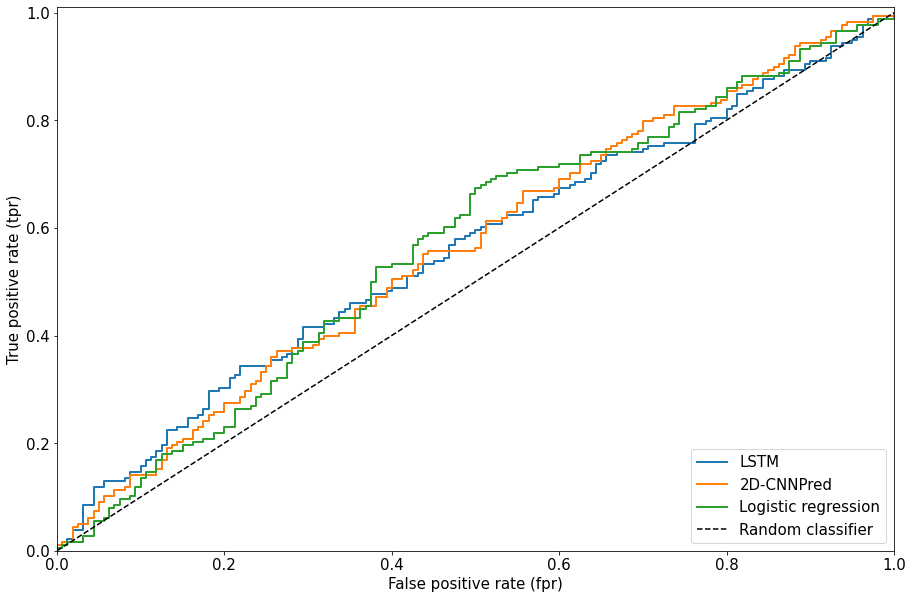

In [124]:
pred_val_probs = np.max(lstm_model.predict(nasdaq_val_X_3D), axis=1)
fpr_lstm, tpr_lstm, thresholds = roc_curve(nasdaq_val_y, pred_val_probs)

    
plot_roc_curve([fpr_lstm, fpr_2d_cnnpred, fpr_log_reg], [tpr_lstm, tpr_2d_cnnpred, tpr_log_reg], labels=["LSTM", "2D-CNNPred", "Logistic regression"])

Looking at the area underneath the curve we can see how well our model performs compared to the random classifier:

In [125]:
roc_auc_score(nasdaq_val_y, pred_val_probs)

0.559691011235955

We report also the graphical representation of the network:

In [126]:
tf.keras.utils.plot_model(lstm_model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


And the plot of the training and validation loss and accuracy (this is the history of the model just trained, as the history of the loaded model is not available):

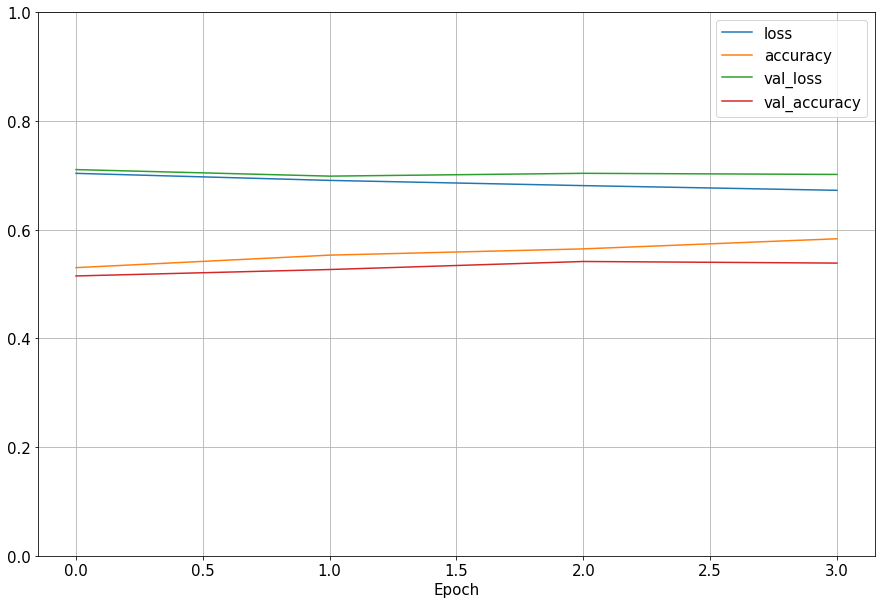

In [127]:
plot_history(history)

## MLP

Another model we are interested in trying is the Multi Layer Perceptron.

This is a neural network composed of fully connected layers. In. this case we use two hidden layers and dropout for each layer to prevent the model from overfitting.

In order to obtain the best model we perform grid search on some hyperparameters. For this purpose we use again the hparam plugin of tensorboard.

The hyperparameters in which we are interested are:


*   Number of units in the first hidden layer
*   Number of units in the second hidden layer
*   Dropout rate for the two layers




### Hyperparameters search

In [128]:
!rm -rf ./logs

HP_NUM_UNITS_HIDDEN1 = hp.HParam('num_units_hidden1', hp.IntInterval(1,200))
HP_NUM_UNITS_HIDDEN2 = hp.HParam('num_units_hidden2', hp.IntInterval(1,200))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0., 0.8))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_HIDDEN1, HP_NUM_UNITS_HIDDEN2, HP_DROPOUT],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

Then we define a function for training the model that is parametric in the hyperparameters and interacts with tensorboard through two callbacks.

This function is very similar to the genear purpose `compile_and_fit` functione, but contains the network layers definition (as for the case of the LSTM) and also performs evaluation outputting the accuracy achieved on the validation set.

In [129]:
def auto_compile_and_fit(hparams, hparam_dir, patience=2, add_dim=False, use_sparse=True, batch_size=32):

    tf.keras.backend.clear_session()

    mlp_model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(hparams[HP_NUM_UNITS_HIDDEN1], activation='tanh'),
        tf.keras.layers.Dropout(rate=hparams[HP_DROPOUT]),
        keras.layers.Dense(hparams[HP_NUM_UNITS_HIDDEN2], activation='tanh'),
        tf.keras.layers.Dropout(rate=hparams[HP_DROPOUT]),
        keras.layers.Dense(units=2, activation='softmax')
    ])

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=hparam_dir, histogram_freq=1)


    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=patience,
                                                mode='auto')

    loss = tf.losses.SparseCategoricalCrossentropy() if use_sparse else tf.losses.BinaryCrossentropy()

    mlp_model.compile(loss=loss,
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.8),
                metrics=['accuracy'])

    history = mlp_model.fit(nasdaq_train_X_3D, nasdaq_train_y, 
                        epochs=MAX_EPOCHS,
                        validation_data=(nasdaq_val_X_3D, nasdaq_val_y),
                        callbacks=[tensorboard_callback, # log metrics
                                    hp.KerasCallback(hparam_dir, hparams),
                                    early_stopping],
                        batch_size=batch_size)
    
    _, accuracy = mlp_model.evaluate(nasdaq_val_X_3D, nasdaq_val_y)
        
    return accuracy

Then, for each hyperparameter that we are interested in, we perform the grid search. Writing the resulting accuracy in the logs file.

This process takes a lot of time. To perform it just uncomment the following cell.

In [130]:
'''

session_num = 0

for num_units_hidden1 in  np.arange(HP_NUM_UNITS_HIDDEN1.domain.min_value, HP_NUM_UNITS_HIDDEN1.domain.max_value, 30):
    for num_units_hidden2 in np.arange(HP_NUM_UNITS_HIDDEN2.domain.min_value, HP_NUM_UNITS_HIDDEN2.domain.max_value, 30):
        for dropout in np.arange(HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value, 0.4):
            hparams = {
                HP_NUM_UNITS_HIDDEN1: num_units_hidden1,
                HP_NUM_UNITS_HIDDEN2: num_units_hidden2,
                HP_DROPOUT: dropout
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run_dir = 'logs/hparam_tuning/' + run_name

            with tf.summary.create_file_writer(run_dir).as_default():
                accuracy = auto_compile_and_fit(hparams, hparam_dir=run_dir)
                tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
            session_num += 1

'''

'\n\nsession_num = 0\n\nfor num_units_hidden1 in  np.arange(HP_NUM_UNITS_HIDDEN1.domain.min_value, HP_NUM_UNITS_HIDDEN1.domain.max_value, 30):\n    for num_units_hidden2 in np.arange(HP_NUM_UNITS_HIDDEN2.domain.min_value, HP_NUM_UNITS_HIDDEN2.domain.max_value, 30):\n        for dropout in np.arange(HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value, 0.4):\n            hparams = {\n                HP_NUM_UNITS_HIDDEN1: num_units_hidden1,\n                HP_NUM_UNITS_HIDDEN2: num_units_hidden2,\n                HP_DROPOUT: dropout\n            }\n            run_name = "run-%d" % session_num\n            print(\'--- Starting trial: %s\' % run_name)\n            print({h.name: hparams[h] for h in hparams})\n            run_dir = \'logs/hparam_tuning/\' + run_name\n\n            with tf.summary.create_file_writer(run_dir).as_default():\n                accuracy = auto_compile_and_fit(hparams, hparam_dir=run_dir)\n                tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)\n

After the search is finished, we are able to visualize in tensorboard the hyperparameters that provide the best results.

In our case these are:

*   181 units in the first layer
*   61 units in the second layer
*   0.4 as dropout rate

In [131]:
%tensorboard --logdir logs/hparam_tuning/

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

### Selected model

Now we train the selected model.

We use $tanh$ as activation function for the hidden layers and $softmax$ for the last layer whcich will output the probabilities of the two classes. Because of this we use `SparseCathegoricalCrossEntropy()` as loss function.

The chose optimizer is Stochastic Gradient Descent as it was proven to be the best for this dataset, with a learning rate of 0.08 foung from the previous models.

In the first part of the next cell we can see the architecture of the network with the chosen hyperparameters.

We create and train 20 models. For each model we compute: accuracy, weighted precision, weighted recall and weigthed f1 on the validation set and on the test set. We perform 20 runs to obtain a fair evaluation of the architeture performance, factoring out the stochasticity introduced by the random initialisation of the weights.

At the end of all the training we take the mean of each metric among the 20 models. We will use this for the final comparison.

In [132]:
validation_mlp = {'accuracy' : [], 'precision' : [], 'recall' : [], 'f1' : []}
test_mlp = {'accuracy' : [], 'precision' : [], 'recall' : [], 'f1' : []}
nyse_test_mlp = {'accuracy' : [], 'precision' : [], 'recall' : [], 'f1' : []}


for i in range(20):

    print(f'\nTraining model number {i+1} of 20\n')

    mlp_model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(units=181, activation='tanh'),
        tf.keras.layers.Dropout(rate=0.4),
        keras.layers.Dense(units=61, activation='tanh'),
        tf.keras.layers.Dropout(rate=0.4),
        keras.layers.Dense(units=2, activation='softmax')
    ])

    history = compile_and_fit(mlp_model, use_sparse=True, optimizer=keras.optimizers.SGD(learning_rate=0.08), patience=3)

    pred_val = tf.argmax(mlp_model.predict(nasdaq_val_X_3D), axis=1)
    report = classification_report(nasdaq_val_y, pred_val, digits=4, output_dict=True)

    validation_mlp['accuracy'].append(report['accuracy'])
    validation_mlp['precision'].append(report['weighted avg']['precision'])
    validation_mlp['recall'].append(report['weighted avg']['recall'])
    validation_mlp['f1'].append(report['weighted avg']['f1-score'])

    pred_test = tf.argmax(mlp_model.predict(nasdaq_test_X_3D), axis=1)
    report = classification_report(nasdaq_test_y, pred_test, digits=4, output_dict=True)

    test_mlp['accuracy'].append(report['accuracy'])
    test_mlp['precision'].append(report['weighted avg']['precision'])
    test_mlp['recall'].append(report['weighted avg']['recall'])
    test_mlp['f1'].append(report['weighted avg']['f1-score'])

    pred_test_nyse = tf.argmax(mlp_model.predict(nyse_test_X_3D), axis=1)
    report = classification_report(nyse_test_y, pred_test_nyse, digits=4, output_dict=True)

    nyse_test_mlp['accuracy'].append(report['accuracy'])
    nyse_test_mlp['precision'].append(report['weighted avg']['precision'])
    nyse_test_mlp['recall'].append(report['weighted avg']['recall'])
    nyse_test_mlp['f1'].append(report['weighted avg']['f1-score'])



Training model number 1 of 20

Epoch 1/20
36/36 [==============================] - 0s 11ms/step - loss: 0.8947 - accuracy: 0.4982 - val_loss: 0.7348 - val_accuracy: 0.5089
Epoch 2/20
36/36 [==============================] - 0s 8ms/step - loss: 0.6617 - accuracy: 0.6115 - val_loss: 0.7069 - val_accuracy: 0.5414
Epoch 3/20
36/36 [==============================] - 0s 8ms/step - loss: 0.6433 - accuracy: 0.6257 - val_loss: 0.7013 - val_accuracy: 0.5562
Epoch 4/20
36/36 [==============================] - 0s 8ms/step - loss: 0.5492 - accuracy: 0.7319 - val_loss: 0.7857 - val_accuracy: 0.5562
Epoch 5/20
36/36 [==============================] - 0s 8ms/step - loss: 0.5024 - accuracy: 0.7522 - val_loss: 0.8839 - val_accuracy: 0.5207
Epoch 6/20
36/36 [==============================] - 0s 8ms/step - loss: 0.4593 - accuracy: 0.7823 - val_loss: 0.9456 - val_accuracy: 0.5828

Training model number 2 of 20

Epoch 1/20
36/36 [==============================] - 1s 14ms/step - loss: 0.8795 - accuracy: 0.4

36/36 [==============================] - 0s 12ms/step - loss: 0.8864 - accuracy: 0.5142 - val_loss: 0.6867 - val_accuracy: 0.5769
Epoch 2/20
36/36 [==============================] - 0s 8ms/step - loss: 0.6944 - accuracy: 0.5752 - val_loss: 0.7422 - val_accuracy: 0.5178
Epoch 3/20
36/36 [==============================] - 0s 8ms/step - loss: 0.6447 - accuracy: 0.6345 - val_loss: 0.7076 - val_accuracy: 0.5296
Epoch 4/20
36/36 [==============================] - 0s 9ms/step - loss: 0.6022 - accuracy: 0.6735 - val_loss: 0.7197 - val_accuracy: 0.5503

Training model number 12 of 20

Epoch 1/20
36/36 [==============================] - 0s 11ms/step - loss: 0.8452 - accuracy: 0.4850 - val_loss: 0.7032 - val_accuracy: 0.5178
Epoch 2/20
36/36 [==============================] - 0s 7ms/step - loss: 0.6829 - accuracy: 0.5903 - val_loss: 0.7056 - val_accuracy: 0.5355
Epoch 3/20
36/36 [==============================] - 0s 7ms/step - loss: 0.6378 - accuracy: 0.6327 - val_loss: 0.6857 - val_accuracy: 0.5

In [133]:
validation_mlp['average'] = {}
validation_mlp['average']['accuarcy'] = np.mean(validation_mlp['accuracy'])
validation_mlp['average']['precision'] = np.mean(validation_mlp['precision'])
validation_mlp['average']['recall'] = np.mean(validation_mlp['recall'])
validation_mlp['average']['f1'] = np.mean(validation_mlp['f1'])


val_performance_acc['MLP'] = validation_mlp['average']['accuarcy']
val_performance_f1_weighted['MLP'] = validation_mlp['average']['f1']

In [134]:
test_mlp['average'] = {}
test_mlp['average']['accuarcy'] = np.mean(test_mlp['accuracy'])
test_mlp['average']['precision'] = np.mean(test_mlp['precision'])
test_mlp['average']['recall'] = np.mean(test_mlp['recall'])
test_mlp['average']['f1'] = np.mean(test_mlp['f1'])


test_performance_acc['MLP'] = test_mlp['average']['accuarcy']
test_performance_f1_weighted['MLP'] = test_mlp['average']['f1']

In [135]:
nyse_test_mlp['average'] = {}
nyse_test_mlp['average']['accuarcy'] = np.mean(nyse_test_mlp['accuracy'])
nyse_test_mlp['average']['precision'] = np.mean(nyse_test_mlp['precision'])
nyse_test_mlp['average']['recall'] = np.mean(nyse_test_mlp['recall'])
nyse_test_mlp['average']['f1'] = np.mean(nyse_test_mlp['f1'])

test_performance_acc_nyse['MLP'] = nyse_test_mlp['average']['accuarcy']
test_performance_f1_weighted_nyse['MLP'] = nyse_test_mlp['average']['f1']

The results just computed over the 20 models will be used later for comparison between different models.

Now, we look into one particular model to go more insights. For this purpose, we load a model that achieved good results. 

If you do not want to use this model just comment the next cell and you will automatically use the last model trained in the set of 20.

In [136]:
mlp_model = tf.keras.models.load_model(mlp_uri)

Let's see the evaluation metrics on the validation set:

In [137]:
pred_val = tf.argmax(mlp_model.predict(nasdaq_val_X_3D), axis=1)
print(classification_report(nasdaq_val_y, pred_val, digits=4))

              precision    recall  f1-score   support

           0     0.5988    0.6250    0.6116       160
           1     0.6491    0.6236    0.6361       178

    accuracy                         0.6243       338
   macro avg     0.6240    0.6243    0.6239       338
weighted avg     0.6253    0.6243    0.6245       338



The confusion matrix:

In [138]:
confusion_matrix(nasdaq_val_y, pred_val)

array([[100,  60],
       [ 67, 111]])

The ROC curve:

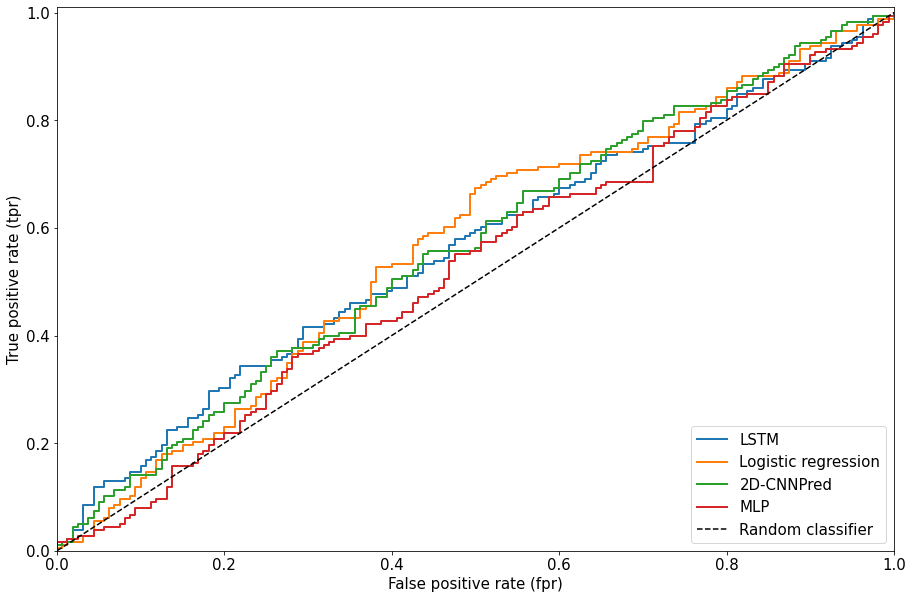

In [139]:
pred_val_probs = np.max(mlp_model.predict(nasdaq_val_X_3D), axis=1)
fpr_mlp, tpr_mlp, thresholds = roc_curve(nasdaq_val_y, pred_val_probs)

    
plot_roc_curve([fpr_lstm, fpr_log_reg, fpr_2d_cnnpred, fpr_mlp], [tpr_lstm, tpr_log_reg, tpr_2d_cnnpred, tpr_mlp], labels=["LSTM", "Logistic regression","2D-CNNPred", "MLP"])

Looking at the area underneath the curve we can see how well our model performs compared to the random classifier:

In [140]:
roc_auc_score(nasdaq_val_y, pred_val_probs)

0.5237008426966292

Let's see the graphical representation of the model:

In [141]:
tf.keras.utils.plot_model(mlp_model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


And a plot of the loss and accuracy:

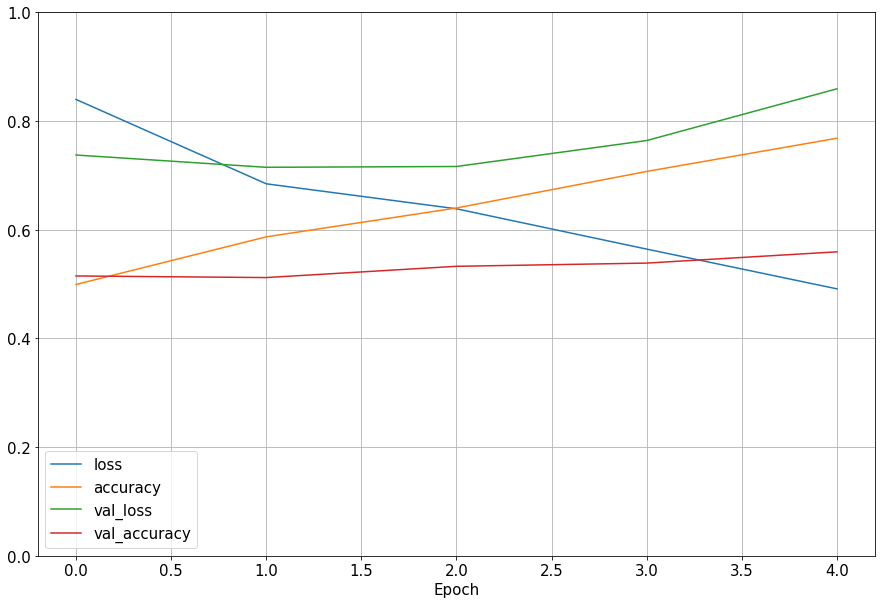

In [142]:
plot_history(history)

## CNN + LSTM

We now build a CNN + LSTM network for this task, using some of the insights gained from reading the paper.

We firstly use a Convolutional layer idenatical to the first layer of 2D-CNNPred. Each filter in this layer convolutes the feature of each day into one single output.

The outputs of this layer is then fed to an LSTM Recurrent Neural Network. Every LSTM cell recieves as input the time series of the features outputted by the filters and models the time series outputting the next value in the sequence.

The output of the LSTM layer is then fed to a fully connected layer with just 2 neurons thet output the probability for each class. The activation for this last layer is softmax in order to output probabilities.

In order to obtain the best model we perform grid search on some hyperparameters.

This time we wrap the keras model and use scikit-learn for tuning the hyperparameters.

The hyperparameters in which we are interested are:

*   Batch size
*   Number of filter units
*   Number of LSTM units





### Hyperparameters search

We first specify the function containing the keras model



In [143]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


def create_model(optimizer='adam', n_filters=32, n_lstm=32):
    
    my_model = keras.models.Sequential([
                                            
        keras.layers.Conv2D(filters=n_filters, kernel_size=(1,83), input_shape=[60, 83, 1], activation='tanh'),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Lambda(lambda x: tf.reshape(x,(-1,60,n_filters))),

        keras.layers.LSTM(units=n_lstm, return_sequences=False),
        keras.layers.Dropout(rate=0.1),
        keras.layers.Dense(units=2, activation='softmax')

    ])
    
    my_model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

    return my_model

Then we wrap the model for scikit-learn:

In [144]:
model = KerasClassifier(build_fn=create_model, verbose=0)

Now we define the hyperparameters in which we are interested:

In [145]:
batches = [6, 32, 128]
n_filters= [8, 32, 100]
n_lstm = [8, 32, 100]

param_grid = dict(batch_size=batches, n_filters=n_filters, n_lstm=n_lstm)

Then we will use the hyperparameter search function of sklearn. 

This function performs cross-validation to see the performance of the paramters. So we will use the `nasdaq_train_val` set that we already used for cross-validation of the sk-learn models.

We could split it in multiple sets, but we decide to just do a classical 2 sets split to keep the computation simple.

In [146]:
tscv = TimeSeriesSplit(n_splits=2)

Now we can define the search.

DIffrently from the other hyperparameters search that we previously performed, with scikit-learn we can choose different metric for evaluation and not use the accuracy metric provided by keras.

Therefore we use `f1_weighted` as our evaluation metric.

We also use all the available CPUs in parallel by setting `n_jobs=-1`.

In [147]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_weighted', cv=tscv.split(nasdaq_train_val_X_3D[:,:,:,np.newaxis], nasdaq_train_val_y), n_jobs=-1, verbose=1)

The search takes a lot of computational time, to perform it and see the output just uncomment the following cells.

In [148]:
# grid_result = grid.fit(nasdaq_train_val_X_3D[:,:,:,np.newaxis], nasdaq_train_val_y)

And now let's output the best parameters and some infos of the runs.

In [149]:
'''
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

cv_results = grid_result.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(np.sqrt(-mean_score), params)
'''

'\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\n\ncv_results = grid_result.cv_results_\nfor mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):\n    print(np.sqrt(-mean_score), params)\n'

The best found parameters are:


*   Bath size = 6
*   Number of filter units = 8
*   Number of LSTM units = 8



### Selected model

Now we train the selected model.

We use $tanh$ as activation function for the hidden layers and $softmax$ for the last layer whcich will output the probabilities of the two classes. Because of this we use `SparseCathegoricalCrossEntropy()` as loss function.

In the middle we have a lambda layer to adjust the shape of the tensor for the LSTM layer.

In the first part of the next cell we can see the architecture of the network with the chosen hyperparameters.

We create and train 20 models. For each model we compute: accuracy, weighted precision, weighted recall and weigthed f1 on the validation set and on the test set. We perform 20 runs to obtain a fair evaluation of the architeture performance, factoring out the stochasticity introduced by the random initialisation of the weights.

At the end of all the training we take the mean of each metric among the 20 models. We will use this for the final comparison.

In [150]:
validation_cnn_lstm = {'accuracy' : [], 'precision' : [], 'recall' : [], 'f1' : []}
test_cnn_lstm = {'accuracy' : [], 'precision' : [], 'recall' : [], 'f1' : []}
nyse_test_cnn_lstm = {'accuracy' : [], 'precision' : [], 'recall' : [], 'f1' : []}


for i in range(20):

    print(f'\nTraining model number {i+1} of 20\n')

    cnn_lstm = keras.models.Sequential([
                                                
        keras.layers.Conv2D(filters=8, kernel_size=(1,83), input_shape=[60, 83, 1], activation='tanh'),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Lambda(lambda x: tf.reshape(x,(-1,60,8))),

        keras.layers.LSTM(units=8, return_sequences=False),
        keras.layers.Dropout(rate=0.1),
        keras.layers.Dense(units=2, activation='softmax')

    ])

    history = compile_and_fit(cnn_lstm, use_sparse=True, add_dim=True, optimizer=tf.keras.optimizers.SGD(0.08), batch_size=6, patience=6)

    pred_val = tf.argmax(cnn_lstm.predict(nasdaq_val_X_3D[:,:,:,np.newaxis]), axis=1)
    report = classification_report(nasdaq_val_y, pred_val, digits=4, output_dict=True)

    validation_cnn_lstm['accuracy'].append(report['accuracy'])
    validation_cnn_lstm['precision'].append(report['weighted avg']['precision'])
    validation_cnn_lstm['recall'].append(report['weighted avg']['recall'])
    validation_cnn_lstm['f1'].append(report['weighted avg']['f1-score'])

    pred_test = tf.argmax(cnn_lstm.predict(nasdaq_test_X_3D[:,:,:,np.newaxis]), axis=1)
    report = classification_report(nasdaq_test_y, pred_test, digits=4, output_dict=True)

    test_cnn_lstm['accuracy'].append(report['accuracy'])
    test_cnn_lstm['precision'].append(report['weighted avg']['precision'])
    test_cnn_lstm['recall'].append(report['weighted avg']['recall'])
    test_cnn_lstm['f1'].append(report['weighted avg']['f1-score'])

    pred_test_nyse = tf.argmax(cnn_lstm.predict(nyse_test_X_3D[:,:,:,np.newaxis]), axis=1)
    report = classification_report(nyse_test_y, pred_test_nyse, digits=4, output_dict=True)

    nyse_test_cnn_lstm['accuracy'].append(report['accuracy'])
    nyse_test_cnn_lstm['precision'].append(report['weighted avg']['precision'])
    nyse_test_cnn_lstm['recall'].append(report['weighted avg']['recall'])
    nyse_test_cnn_lstm['f1'].append(report['weighted avg']['f1-score'])




Training model number 1 of 20

Epoch 1/20
189/189 [==============================] - 7s 35ms/step - loss: 0.6993 - accuracy: 0.5310 - val_loss: 0.6928 - val_accuracy: 0.5178
Epoch 2/20
189/189 [==============================] - 6s 33ms/step - loss: 0.6899 - accuracy: 0.5381 - val_loss: 0.6914 - val_accuracy: 0.5414
Epoch 3/20
189/189 [==============================] - 6s 33ms/step - loss: 0.6883 - accuracy: 0.5451 - val_loss: 0.6920 - val_accuracy: 0.5296
Epoch 4/20
189/189 [==============================] - 6s 34ms/step - loss: 0.6875 - accuracy: 0.5319 - val_loss: 0.6941 - val_accuracy: 0.5266
Epoch 5/20
189/189 [==============================] - 6s 31ms/step - loss: 0.6850 - accuracy: 0.5504 - val_loss: 0.6890 - val_accuracy: 0.5385
Epoch 6/20
189/189 [==============================] - 6s 34ms/step - loss: 0.6838 - accuracy: 0.5655 - val_loss: 0.6890 - val_accuracy: 0.5207
Epoch 7/20
189/189 [==============================] - 6s 32ms/step - loss: 0.6795 - accuracy: 0.5708 - val_los

Epoch 4/20
189/189 [==============================] - 6s 32ms/step - loss: 0.6819 - accuracy: 0.5611 - val_loss: 0.6995 - val_accuracy: 0.5118
Epoch 5/20
189/189 [==============================] - 7s 35ms/step - loss: 0.6773 - accuracy: 0.5788 - val_loss: 0.6992 - val_accuracy: 0.5266
Epoch 6/20
189/189 [==============================] - 5s 29ms/step - loss: 0.6750 - accuracy: 0.5735 - val_loss: 0.6964 - val_accuracy: 0.5148
Epoch 7/20
189/189 [==============================] - 6s 31ms/step - loss: 0.6682 - accuracy: 0.5920 - val_loss: 0.7158 - val_accuracy: 0.5178
Epoch 8/20
189/189 [==============================] - 6s 32ms/step - loss: 0.6665 - accuracy: 0.5929 - val_loss: 0.7057 - val_accuracy: 0.4793
Epoch 9/20
189/189 [==============================] - 6s 34ms/step - loss: 0.6605 - accuracy: 0.6009 - val_loss: 0.7094 - val_accuracy: 0.5355
Epoch 10/20
189/189 [==============================] - 6s 31ms/step - loss: 0.6596 - accuracy: 0.6053 - val_loss: 0.7085 - val_accuracy: 0.488

/Users/Matteo/opt/anaconda3/envs/data_science/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training model number 9 of 20

Epoch 1/20
189/189 [==============================] - 7s 36ms/step - loss: 0.6953 - accuracy: 0.5381 - val_loss: 0.6943 - val_accuracy: 0.5266
Epoch 2/20
189/189 [==============================] - 6s 33ms/step - loss: 0.6885 - accuracy: 0.5566 - val_loss: 0.6943 - val_accuracy: 0.5030
Epoch 3/20
189/189 [==============================] - 6s 32ms/step - loss: 0.6870 - accuracy: 0.5575 - val_loss: 0.6961 - val_accuracy: 0.5325
Epoch 4/20
189/189 [==============================] - 6s 32ms/step - loss: 0.6880 - accuracy: 0.5513 - val_loss: 0.6983 - val_accuracy: 0.5266
Epoch 5/20
189/189 [==============================] - 6s 33ms/step - loss: 0.6848 - accuracy: 0.5611 - val_loss: 0.6968 - val_accuracy: 0.5207
Epoch 6/20
189/189 [==============================] - 6s 32ms/step - loss: 0.6803 - accuracy: 0.5593 - val_loss: 0.6928 - val_accuracy: 0.5237
Epoch 7/20
189/189 [==============================] - 6s 31ms/step - loss: 0.6778 - accuracy: 0.5743 - val_los

Epoch 1/20
189/189 [==============================] - 6s 34ms/step - loss: 0.6922 - accuracy: 0.5496 - val_loss: 0.6954 - val_accuracy: 0.5266
Epoch 2/20
189/189 [==============================] - 7s 35ms/step - loss: 0.6880 - accuracy: 0.5522 - val_loss: 0.6923 - val_accuracy: 0.5237
Epoch 3/20
189/189 [==============================] - 6s 34ms/step - loss: 0.6880 - accuracy: 0.5407 - val_loss: 0.6967 - val_accuracy: 0.5266
Epoch 4/20
189/189 [==============================] - 6s 32ms/step - loss: 0.6845 - accuracy: 0.5558 - val_loss: 0.6958 - val_accuracy: 0.5266
Epoch 5/20
189/189 [==============================] - 6s 30ms/step - loss: 0.6845 - accuracy: 0.5584 - val_loss: 0.6907 - val_accuracy: 0.5207
Epoch 6/20
189/189 [==============================] - 6s 31ms/step - loss: 0.6846 - accuracy: 0.5522 - val_loss: 0.6887 - val_accuracy: 0.5266
Epoch 7/20
189/189 [==============================] - 6s 32ms/step - loss: 0.6801 - accuracy: 0.5726 - val_loss: 0.7053 - val_accuracy: 0.5266

189/189 [==============================] - 6s 33ms/step - loss: 0.6795 - accuracy: 0.5681 - val_loss: 0.7081 - val_accuracy: 0.5266
Epoch 8/20
189/189 [==============================] - 6s 32ms/step - loss: 0.6783 - accuracy: 0.5602 - val_loss: 0.6883 - val_accuracy: 0.5296
Epoch 9/20
189/189 [==============================] - 6s 33ms/step - loss: 0.6692 - accuracy: 0.5965 - val_loss: 0.6908 - val_accuracy: 0.5355
Epoch 10/20
189/189 [==============================] - 6s 32ms/step - loss: 0.6760 - accuracy: 0.5655 - val_loss: 0.6938 - val_accuracy: 0.5237
Epoch 11/20
189/189 [==============================] - 6s 31ms/step - loss: 0.6697 - accuracy: 0.5991 - val_loss: 0.7039 - val_accuracy: 0.5266
Epoch 12/20
189/189 [==============================] - 6s 33ms/step - loss: 0.6694 - accuracy: 0.5982 - val_loss: 0.6876 - val_accuracy: 0.5651

Training model number 19 of 20

Epoch 1/20
189/189 [==============================] - 7s 36ms/step - loss: 0.6965 - accuracy: 0.5451 - val_loss: 0.70

In [151]:
validation_cnn_lstm['average'] = {}
validation_cnn_lstm['average']['accuarcy'] = np.mean(validation_cnn_lstm['accuracy'])
validation_cnn_lstm['average']['precision'] = np.mean(validation_cnn_lstm['precision'])
validation_cnn_lstm['average']['recall'] = np.mean(validation_cnn_lstm['recall'])
validation_cnn_lstm['average']['f1'] = np.mean(validation_cnn_lstm['f1'])


val_performance_acc['CNN + LSTM'] = validation_cnn_lstm['average']['accuarcy']
val_performance_f1_weighted['CNN + LSTM'] = validation_cnn_lstm['average']['f1']

In [152]:
test_cnn_lstm['average'] = {}
test_cnn_lstm['average']['accuarcy'] = np.mean(test_cnn_lstm['accuracy'])
test_cnn_lstm['average']['precision'] = np.mean(test_cnn_lstm['precision'])
test_cnn_lstm['average']['recall'] = np.mean(test_cnn_lstm['recall'])
test_cnn_lstm['average']['f1'] = np.mean(test_cnn_lstm['f1'])


test_performance_acc['CNN + LSTM'] = test_cnn_lstm['average']['accuarcy']
test_performance_f1_weighted['CNN + LSTM'] = test_cnn_lstm['average']['f1']

In [153]:
nyse_test_cnn_lstm['average'] = {}
nyse_test_cnn_lstm['average']['accuarcy'] = np.mean(nyse_test_cnn_lstm['accuracy'])
nyse_test_cnn_lstm['average']['precision'] = np.mean(nyse_test_cnn_lstm['precision'])
nyse_test_cnn_lstm['average']['recall'] = np.mean(nyse_test_cnn_lstm['recall'])
nyse_test_cnn_lstm['average']['f1'] = np.mean(nyse_test_cnn_lstm['f1'])

test_performance_acc_nyse['CNN + LSTM'] = nyse_test_cnn_lstm['average']['accuarcy']
test_performance_f1_weighted_nyse['CNN + LSTM'] = nyse_test_cnn_lstm['average']['f1']

The results just computed over the 20 models will be used later for comparison between different models.

Now, we look into one particular model to go more insights. For this purpose, we load a model that achieved good results. 

If you do not want to use this model just comment the next cell and you will automatically use the last model trained in the set of 20.

In [154]:
cnn_lstm = tf.keras.models.load_model(cnn_lstm_uri)

Let's see the evaluation metrics on the validation set:

In [155]:
pred_val = tf.argmax(cnn_lstm.predict(nasdaq_val_X_3D[:,:,:,np.newaxis]), axis=1)
print(classification_report(nasdaq_val_y, pred_val, digits=4))

              precision    recall  f1-score   support

           0     0.5000    0.3187    0.3893       160
           1     0.5381    0.7135    0.6135       178

    accuracy                         0.5266       338
   macro avg     0.5191    0.5161    0.5014       338
weighted avg     0.5201    0.5266    0.5074       338



The confusion matrix:

In [156]:
confusion_matrix(nasdaq_val_y, pred_val)

array([[ 51, 109],
       [ 51, 127]])

The ROC curve:

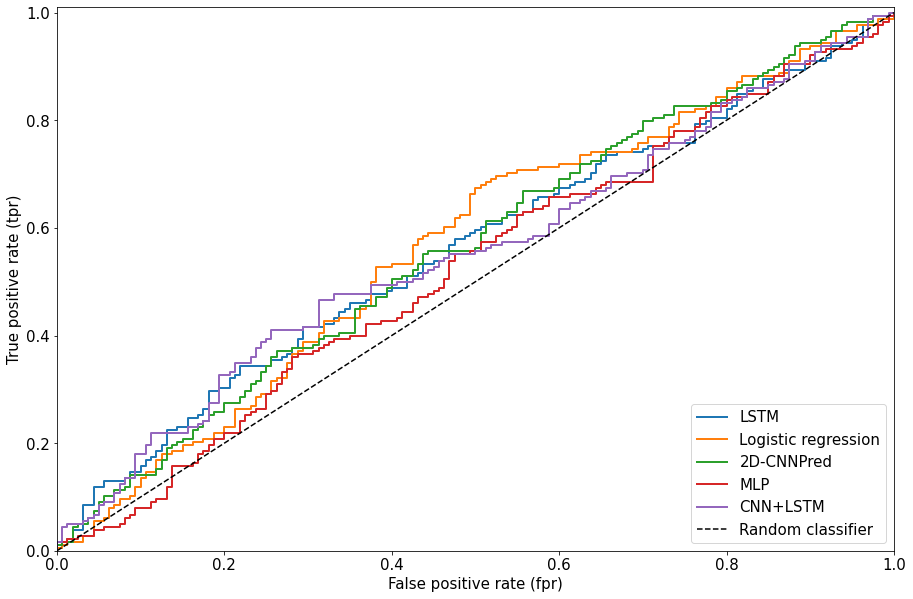

In [157]:
pred_val_probs = np.max(cnn_lstm.predict(nasdaq_val_X_3D[:,:,:,np.newaxis]), axis=1)
fpr_my, tpr_my, thresholds = roc_curve(nasdaq_val_y, pred_val_probs)

plot_roc_curve([fpr_lstm, fpr_log_reg, fpr_2d_cnnpred, fpr_mlp, fpr_my], [tpr_lstm, tpr_log_reg, tpr_2d_cnnpred, tpr_mlp, tpr_my], labels=["LSTM", "Logistic regression","2D-CNNPred", "MLP", "CNN+LSTM"])

Looking at the area underneath the curve we can see how well our model performs compared to the random classifier:

In [158]:
roc_auc_score(nasdaq_val_y, pred_val_probs)

0.5538974719101124

Let's see graphically the model

In [159]:
tf.keras.utils.plot_model(cnn_lstm, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


And a plot of the loss and accuracy:

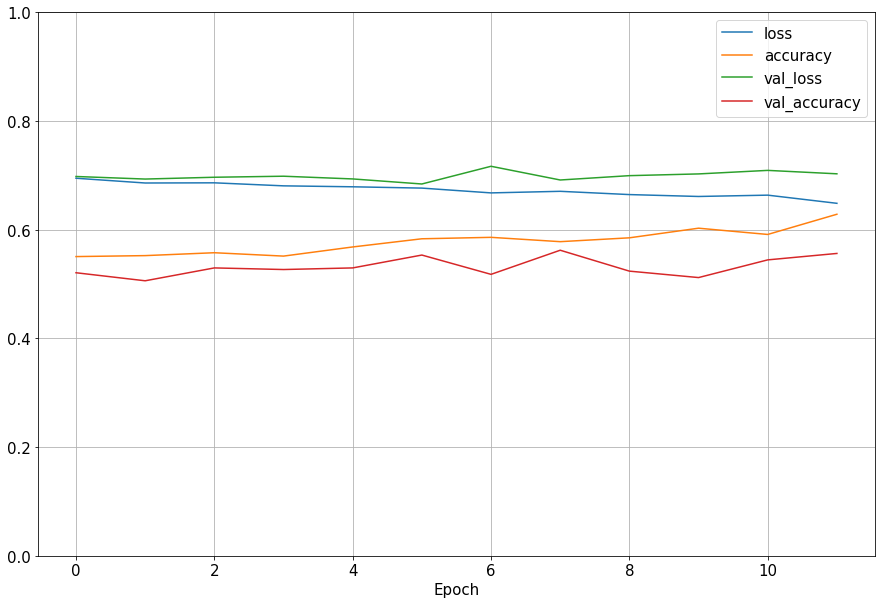

In [160]:
plot_history(history)

## Other classifiers

We have also tried a selection of various classifiers which have been less succesfull.

Here we briefly report them:

### Bagging classifier

In [161]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

#use bootstrap=False for pasting
bag_clf = BaggingClassifier(
    SGDClassifier(max_iter=300, tol=None, random_state=42,
                        loss="log", eta0=0.4, learning_rate="adaptive", penalty=None, n_jobs=-1),
    n_estimators=200,
    max_samples=nasdaq_train_X.shape[0], max_features=0.8, 
    bootstrap=True, bootstrap_features=False,
    n_jobs=-1, random_state=42)

bag_clf.fit(nasdaq_train_X, nasdaq_train_y)

BaggingClassifier(base_estimator=SGDClassifier(eta0=0.4,
                                               learning_rate='adaptive',
                                               loss='log', max_iter=300,
                                               n_jobs=-1, penalty=None,
                                               random_state=42, tol=None),
                  max_features=0.8, max_samples=1130, n_estimators=200,
                  n_jobs=-1, random_state=42)

In [162]:
pred_val = bag_clf.predict(nasdaq_val_X)
print(classification_report(nasdaq_val_y, pred_val, digits=3))

              precision    recall  f1-score   support

           0      0.553     0.519     0.535       160
           1      0.590     0.624     0.607       178

    accuracy                          0.574       338
   macro avg      0.572     0.571     0.571       338
weighted avg      0.573     0.574     0.573       338



### Random forrest

In [163]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=300, max_leaf_nodes=40, 
                                 n_jobs=-1, random_state=42)

rnd_clf.fit(nasdaq_train_X, nasdaq_train_y)

RandomForestClassifier(max_leaf_nodes=40, n_estimators=300, n_jobs=-1,
                       random_state=42)

In [164]:
pred_val = rnd_clf.predict(nasdaq_val_X)
print(classification_report(nasdaq_val_y, pred_val, digits=3))

              precision    recall  f1-score   support

           0      0.625     0.031     0.060       160
           1      0.530     0.983     0.689       178

    accuracy                          0.533       338
   macro avg      0.578     0.507     0.374       338
weighted avg      0.575     0.533     0.391       338



# Results

Let's now compare the performance of the trained models.

FIrst we look only at the performance during validation.

We will plot:

*   Accuracy
*   Weighted $F_1$ Score

Note that the metrics reported in this section are computed from the average of 20 models per each architecture


## Validation

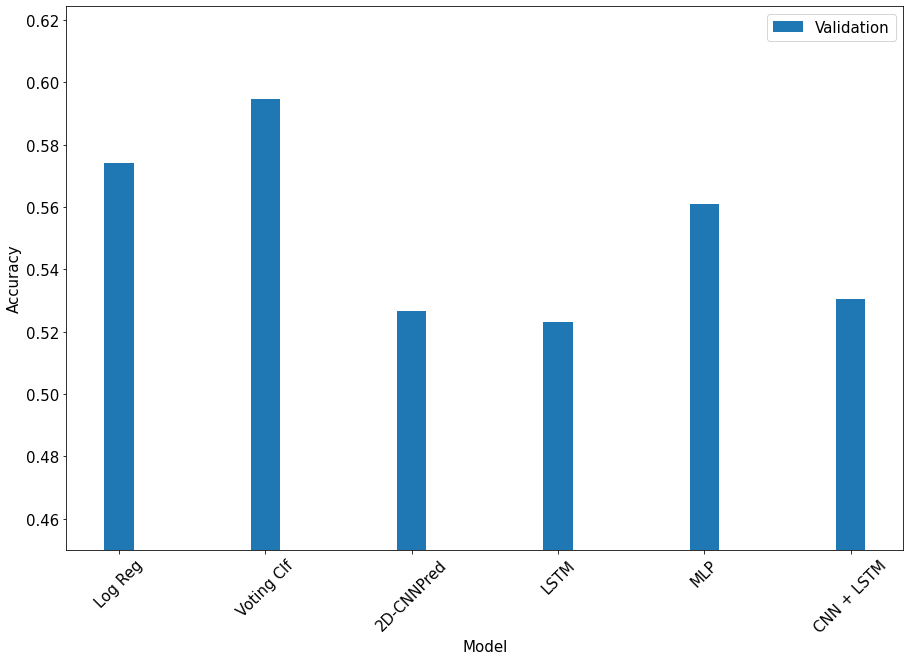

In [165]:
x = np.arange(len(val_performance_acc))
width = 0.2
val_acc = list(val_performance_acc.values())


plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.bar(x, val_acc, width, label='Validation')

plt.xticks(ticks=x, labels=val_performance_acc.keys(),
           rotation=45)
plt.ylim(0.45)
plt.legend()

The Voting Classifier achieves the best accuracy of all models on the validation set. All the neural networks perform slightly similar with 2D-CNNPred achieving the worst result.

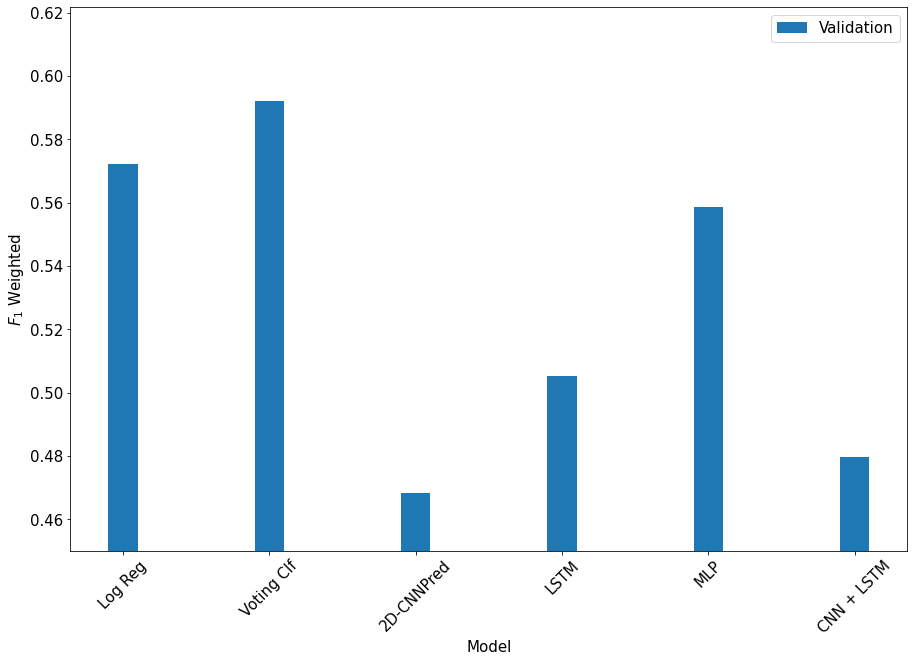

In [166]:
x = np.arange(len(val_performance_f1_weighted))
width = 0.2
val_f1 = list(val_performance_f1_weighted.values())


plt.ylabel('$F_1$ Weighted')
plt.xlabel('Model')
plt.bar(x, val_f1, width, label='Validation')

plt.xticks(ticks=x, labels=val_performance_acc.keys(),
           rotation=45)

plt.ylim(0.45)
plt.legend()



For the $F_1$ score the situation remain similar to the one observed for the accuracy.

From the evaluation results we can see that the best performing models are the two traditional classifiers. The worst results are obtained by the convolutional and recurrent neural networks with our custom architecture obtaining the worst result. These results, however, are not totally truthful of the model quality. Being the validation set temporally close to the training set, models that may have overfitted the training set will still achieve a good result during validation. This may have happened for the MLP and the two traditional classifiers. 


## Test

Now let's compare the results obtained on the validation set with those obtained on the test set.

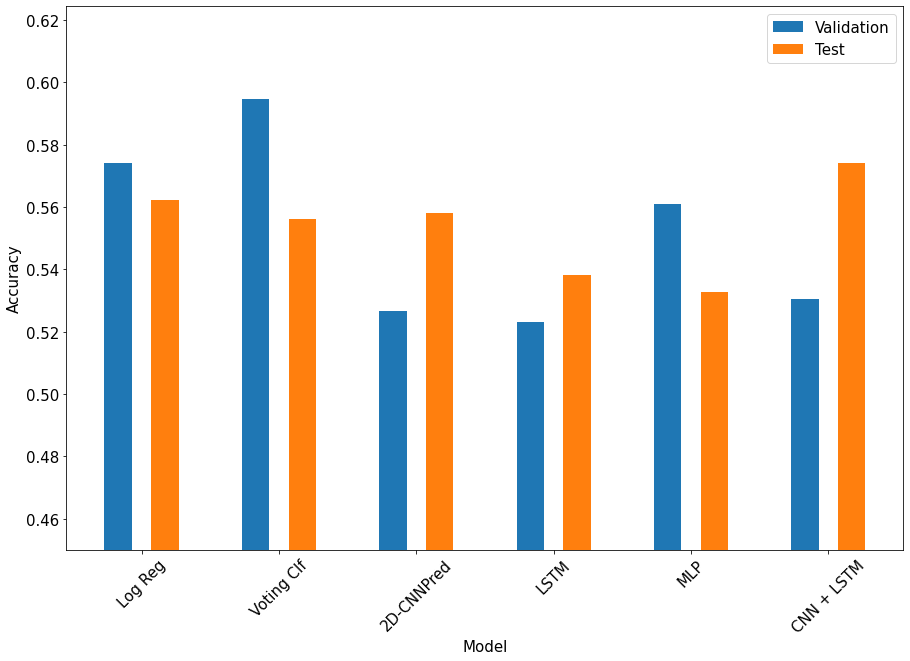

In [167]:
x = np.arange(len(test_performance_acc))
width = 0.2

val_acc = list(val_performance_acc.values())
test_acc = list(test_performance_acc.values())

plt.bar(x - 0.17, val_acc, width, label='Validation')
plt.bar(x + 0.17, test_acc, width, label='Test')

plt.ylabel('Accuracy')
plt.xlabel('Model')

plt.xticks(ticks=x, labels=test_performance_acc.keys(),
           rotation=45)

plt.ylim(0.45)
plt.legend()



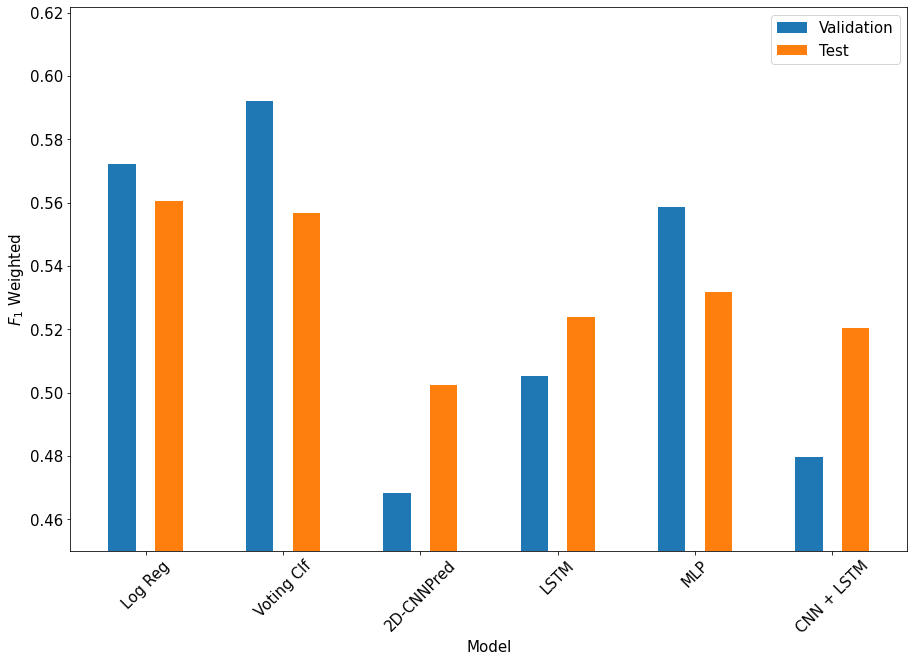

In [168]:
x = np.arange(len(test_performance_f1_weighted))
width = 0.2

val_f1 = list(val_performance_f1_weighted.values())
test_f1 = list(test_performance_f1_weighted.values())

plt.bar(x - 0.17, val_f1, width, label='Validation')
plt.bar(x + 0.17, test_f1, width, label='Test')

plt.ylabel('$F_1$ Weighted')
plt.xlabel('Model')

plt.xticks(ticks=x, labels=test_performance_f1_weighted.keys(),
           rotation=45)
plt.ylim(0.45)

plt.legend()


We observe the same trend also on the $F_1$ metric.

Looking for the first time at the results on the test set, we can confirm our suspicions. Indeed, we observe a worsening result for the two traditional classifiers, which are now failing to generalise on the test data. On the other hand, we see a strong increase in the performance of CNN-based models. Furthermore, our custom architecture outperforms 2D-CNNPred on both metrics, almost obtaining the best accuracy, showing that combining the power of CNN and LSTM for stock market prediction we can achieve a good solution.

### Testing on NYSE

In this section we test our models on the NYSE dataset.

Real further tests must be conducted on further days in the NASDAQ market to really see the power of our models.

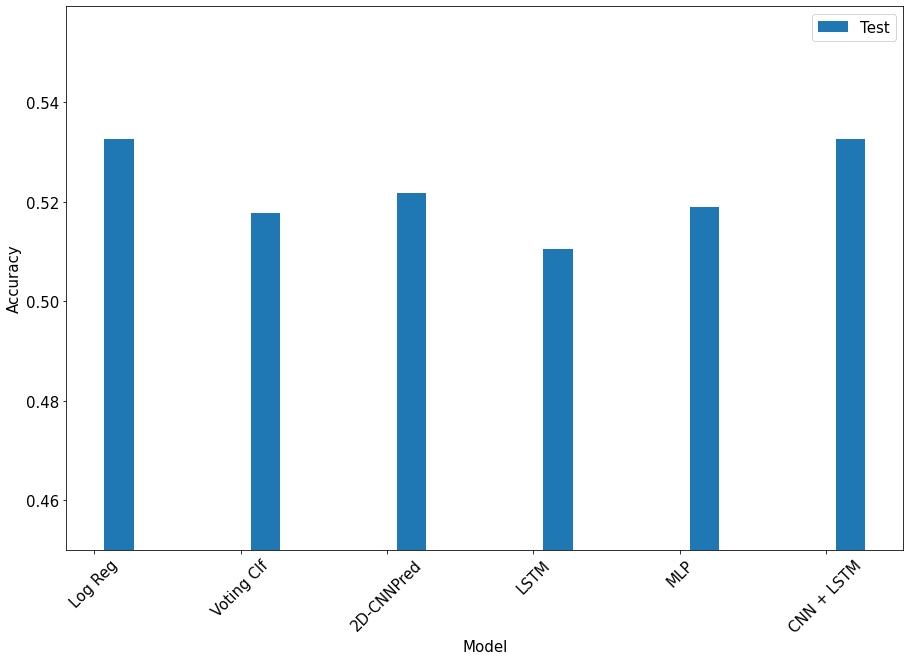

In [169]:
x = np.arange(len(test_performance_acc_nyse))
width = 0.2

test_acc = list(test_performance_acc_nyse.values())

plt.bar(x + 0.17, test_acc, width, label='Test')

plt.ylabel('Accuracy')
plt.xlabel('Model')

plt.xticks(ticks=x, labels=test_performance_acc_nyse.keys(),
           rotation=45)
plt.ylim(0.45)

plt.legend()



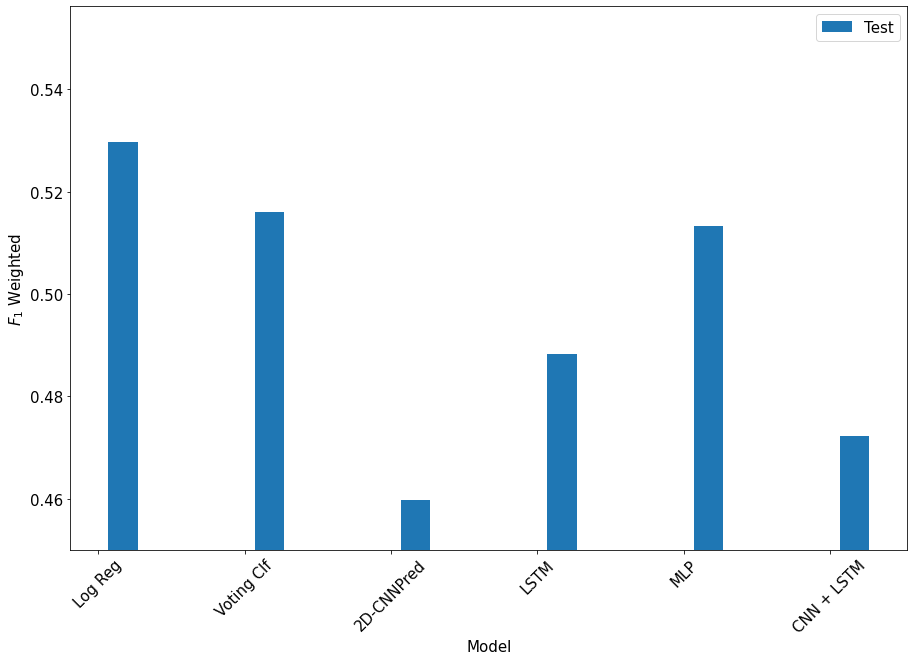

In [170]:
x = np.arange(len(test_performance_f1_weighted_nyse))
width = 0.2

test_f1 = list(test_performance_f1_weighted_nyse.values())

plt.bar(x + 0.17, test_f1, width, label='Test')

plt.ylabel('$F_1$ Weighted')
plt.xlabel('Model')

plt.xticks(ticks=x, labels=test_performance_f1_weighted_nyse.keys(),
           rotation=45)
plt.ylim(0.45)

plt.legend()
